In [3]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
torch.__version__

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427652


'2.0.1'

In [4]:
#Raw data training
starttime=time.time()
target='raw'
labeled_data=2000
layer_loss_list=[]
Epochs=1000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data

wand_dict={}
batchsize=128
layers=[64]*11
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
valloader=DataLoader(val_data,batch_size=512,shuffle=True,num_workers=0)
encoder=M.fc_net_extra(training_data.b[0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)


relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    for batch, (b,rho,num_targets) in enumerate(trainloader):
        optimizer.zero_grad()

        b=b.to(device)
        rho=rho.to(device)    
        if labeled_data==1:
            b=b.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)  
            rho=rho.squeeze().unsqueeze(0).repeat(128,1).unsqueeze(1)
        font_size = 50
        rho_hat=encoder(b)
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid':
            #rho_hat=rho_hat-rho
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        if encoder_out=='sigmoid' or encoder_out=='softmax':
            #print(rho_hat.shape, rh.shape)
            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            bce_loss.backward() 
            train_lossavg+=bce_loss.item()/len(trainloader)

        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            L2_loss.backward()
            train_lossavg+=L2_loss.item()/len(trainloader)
        optimizer.step()
    if epoch==Epochs-1:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        finish=time.time()-starttime
        print(f"time for labeled: {finish}")
    wand_dict['train loss']=train_lossavg
    val_loss=0
    encoder.eval()
    for batch, (b,rho,num_targets) in enumerate(valloader):
        b=b.to(device)
        rho=rho.to(device)    
        font_size = 50
        rho_hat=encoder(b)
        if encoder_out=='sigmoid':
            rho_hat=sigmoid(rho_hat)
        elif encoder_out=='softmax':
            rho_hat=5*softmax(rho_hat.squeeze())
        elif encoder_out=='relu':
            rho_hat=relu(rho_hat.squeeze())
        #rho_hat=relu(rho_hat.squeeze())
        #H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5)    
        rh, _=torch.split(rho, 400, dim=-1)
        if encoder_out=='sigmoid' or encoder_out=='softmax':

            bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
            val_loss+=bce_loss.item()/len(valloader)
        else:
            L2_loss=L2_loss_fn(rho_hat.squeeze(), rh.squeeze())    
            val_loss+=L2_loss.item()/len(valloader)
    wand_dict['val loss']=val_loss
    if epoch==Epochs-1:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    if Track_run:
        wandb.log(wand_dict)

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (2000, 400), B: (2000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
591664
Data shapes: 1450.0 200.0


KeyboardInterrupt: 

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427652
Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
G_0 initialization successful: True
2147168
Data shapes: 1450.0 200.0


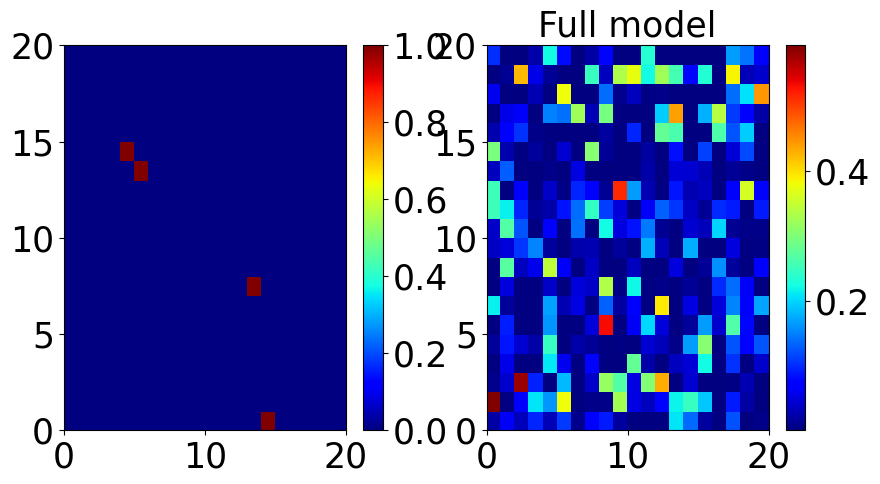

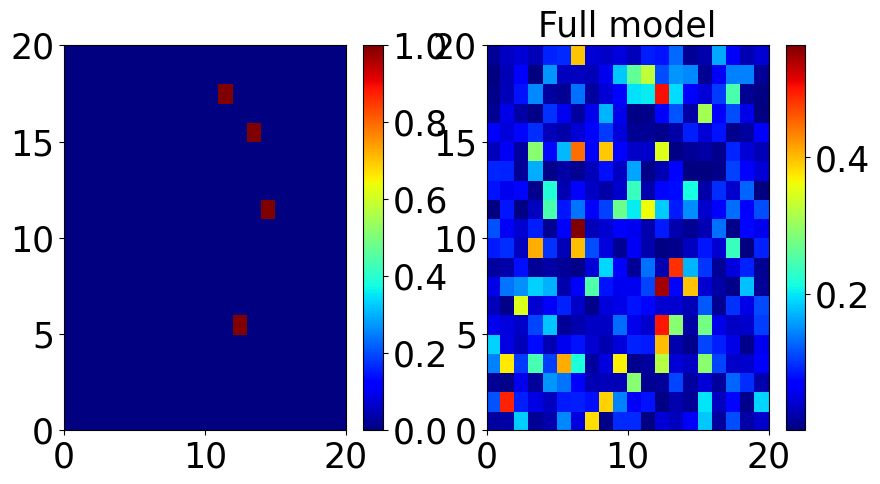

epoch: 0, train loss: 0.02175012631341815, L1 loss: 0.12519603944383562, val loss: 0.020524753257632256, max avg inners: 0.26533195126507847, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 0.01993698505684733, L1 loss: 0.03202103404328227, val loss: 0.02260003238916397, max avg inners: 0.3183919133105846, GELMA loss: -0.0026292621267202778, num indices: 0
epoch: 2, train loss: 0.01874245028011501, L1 loss: 0.01273491999018006, val loss: 0.022407950833439827, max avg inners: 0.37773628060485526, GELMA loss: 0.00011294251216895643, num indices: 0
epoch: 3, train loss: 0.017859424464404586, L1 loss: 0.010949235496809706, val loss: 0.023168638348579407, max avg inners: 0.4430721013234276, GELMA loss: -6.727068757754755e-05, num indices: 0
epoch: 4, train loss: 0.016950776195153592, L1 loss: 0.010022045040386729, val loss: 0.022836731746792793, max avg inners: 0.5116640276183616, GELMA loss: 0.0005838167533511295, num indices: 0
epoch: 5, train loss: 0.016127186641097073, L1 loss: 0.0

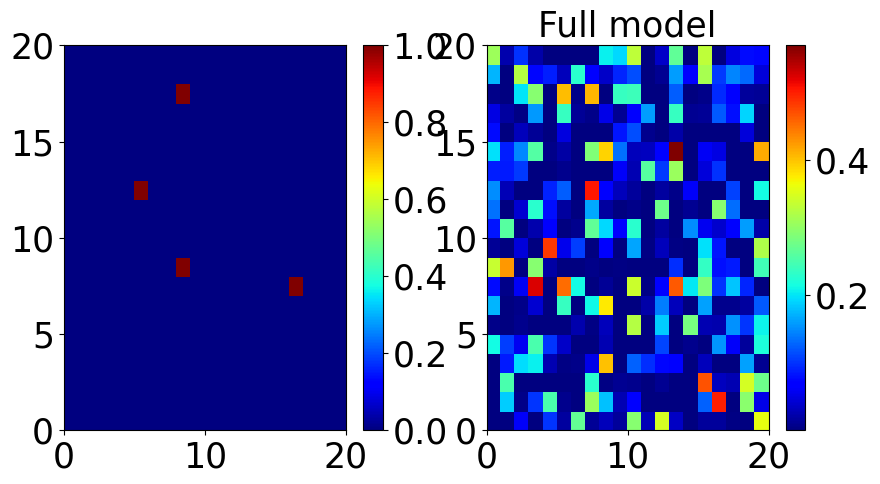

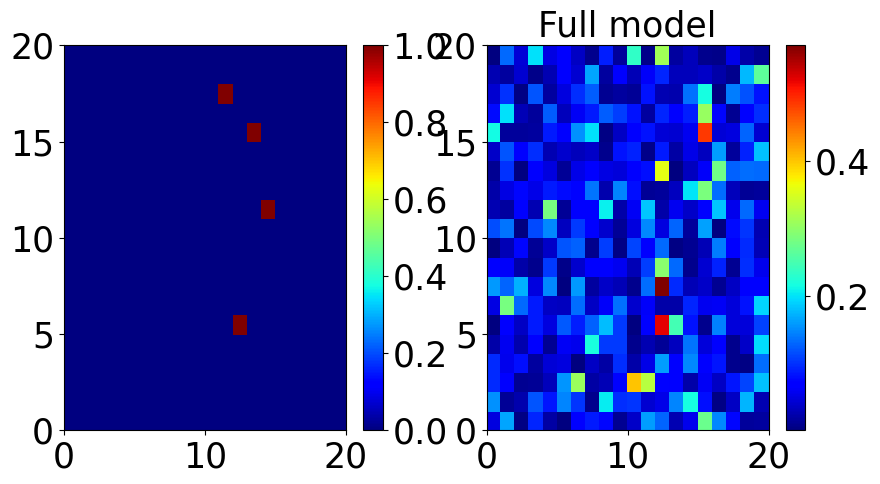

epoch: 50, train loss: 0.020826621772721415, L1 loss: 0.12186788907274604, val loss: 0.02061387524008751, max avg inners: 0.802686701782159, GELMA loss: -0.0012545423218398356, num indices: 0
epoch: 51, train loss: 0.01572881354950368, L1 loss: 0.0309173830319196, val loss: 0.023870954290032387, max avg inners: 0.8050978097742539, GELMA loss: -0.00035224592211306993, num indices: 0
epoch: 52, train loss: 0.012670142459683117, L1 loss: 0.018535072216764092, val loss: 0.02352011203765869, max avg inners: 0.8077214857670293, GELMA loss: 0.00011622487581917084, num indices: 0
epoch: 53, train loss: 0.011758539476431904, L1 loss: 0.01826920037274249, val loss: 0.023400770500302315, max avg inners: 0.8093654820881407, GELMA loss: -0.00013063746955594983, num indices: 0
epoch: 54, train loss: 0.010615267045795913, L1 loss: 0.01740306691499427, val loss: 0.02342391386628151, max avg inners: 0.8107412650039904, GELMA loss: -7.17139871994732e-05, num indices: 0
epoch: 55, train loss: 0.010183368

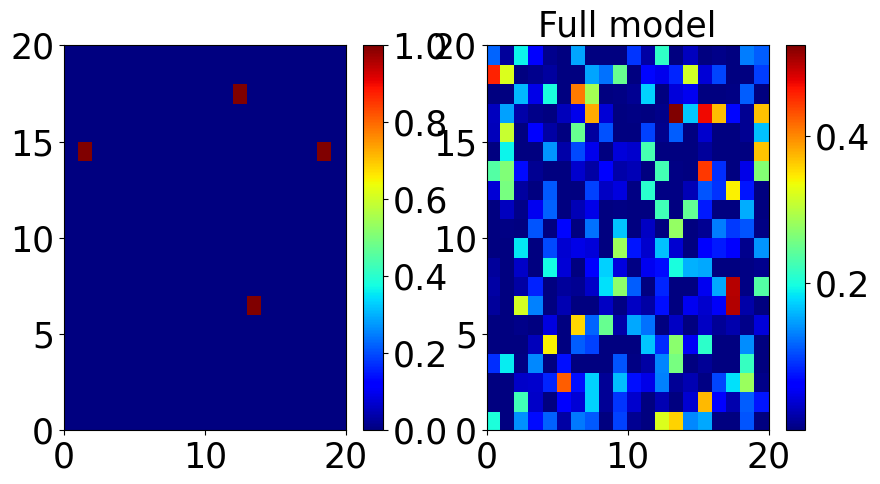

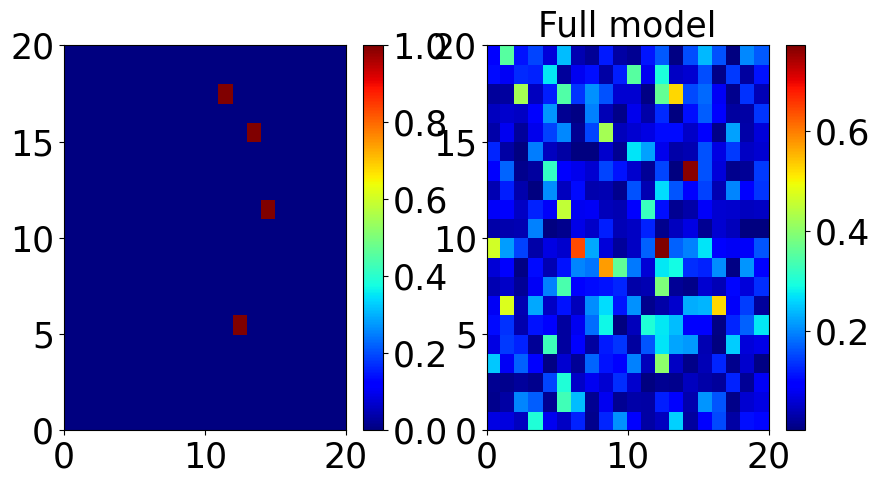

epoch: 100, train loss: 0.020560568850487473, L1 loss: 0.12050963961519301, val loss: 0.020539915189146996, max avg inners: 0.8194680123116559, GELMA loss: -0.0018862500834075043, num indices: 0
epoch: 101, train loss: 0.015385878388769926, L1 loss: 0.02541991267935373, val loss: 0.023211250081658363, max avg inners: 0.8204869312354006, GELMA loss: -0.00022894684298080392, num indices: 0
epoch: 102, train loss: 0.012712782016023992, L1 loss: 0.011305642692605034, val loss: 0.023509416729211807, max avg inners: 0.8223233489268418, GELMA loss: 5.559406781685537e-06, num indices: 0
epoch: 103, train loss: 0.011345450882799918, L1 loss: 0.009467031515669078, val loss: 0.02336001582443714, max avg inners: 0.8230739535955606, GELMA loss: -0.00039540781726827835, num indices: 0
epoch: 104, train loss: 0.010974207334220406, L1 loss: 0.009081980984774418, val loss: 0.023340515792369843, max avg inners: 0.8237042825559964, GELMA loss: -0.00019756803267227956, num indices: 0
epoch: 105, train los

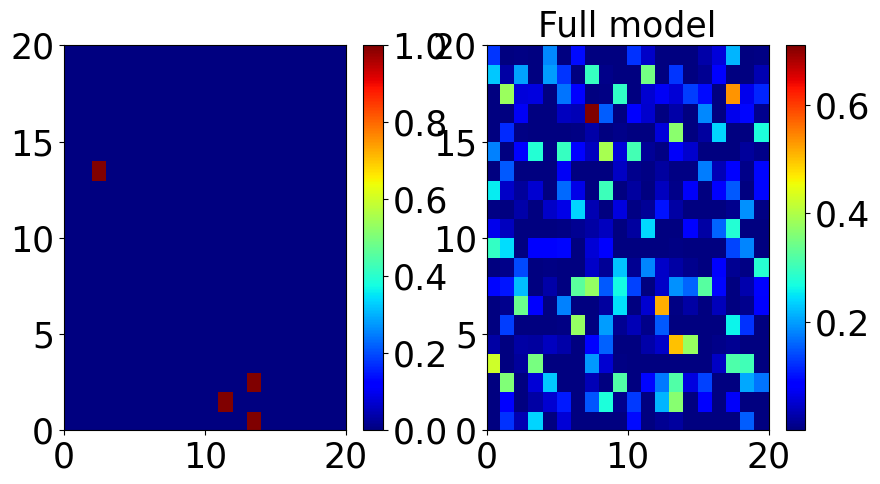

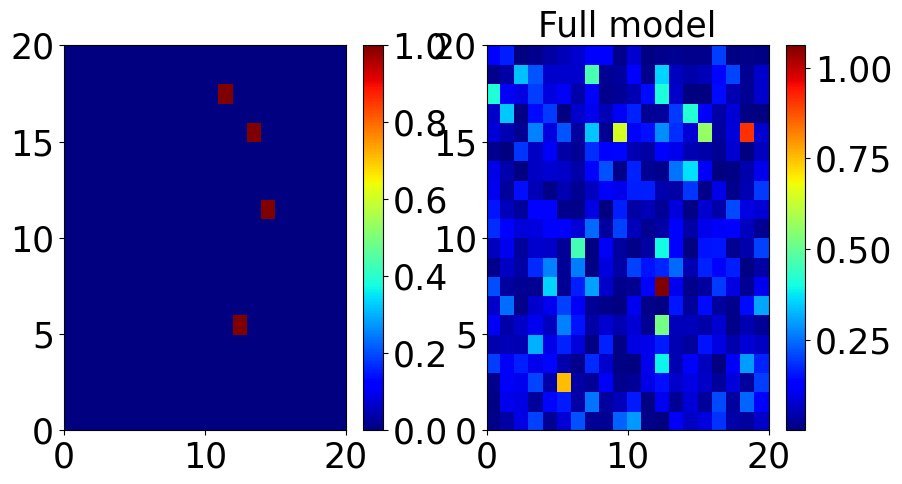

epoch: 150, train loss: 0.02056606872938573, L1 loss: 0.12075505568645895, val loss: 0.020332766696810722, max avg inners: 0.8250101276438544, GELMA loss: -0.001910794276773231, num indices: 0
epoch: 151, train loss: 0.015163391199894252, L1 loss: 0.031140894920099527, val loss: 0.02359830029308796, max avg inners: 0.8269033072198052, GELMA loss: -0.0007110350255970845, num indices: 0
epoch: 152, train loss: 0.01231143514160067, L1 loss: 0.018961653870064765, val loss: 0.02315458469092846, max avg inners: 0.8283781128835134, GELMA loss: -9.869489549600984e-05, num indices: 0
epoch: 153, train loss: 0.01071788368280977, L1 loss: 0.01803368260152638, val loss: 0.02333187311887741, max avg inners: 0.8291062011814831, GELMA loss: 0.0001755957056957413, num indices: 0
epoch: 154, train loss: 0.010528981126844883, L1 loss: 0.01796255589579232, val loss: 0.02331303432583809, max avg inners: 0.8293789654468279, GELMA loss: -0.00012336177496763412, num indices: 0
epoch: 155, train loss: 0.00974

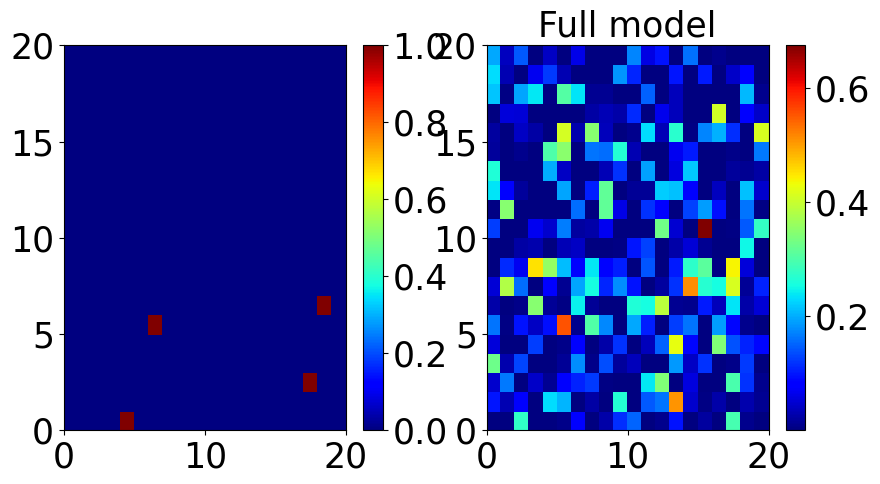

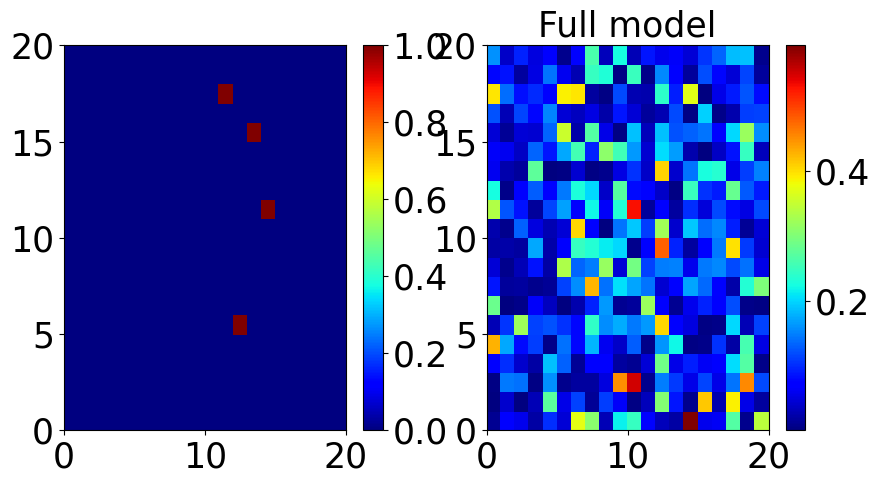

epoch: 200, train loss: 0.020402823667973285, L1 loss: 0.12084063747897744, val loss: 0.02037138305604458, max avg inners: 0.8338311602554722, GELMA loss: -0.0013912325448472986, num indices: 10
epoch: 201, train loss: 0.015290886699222028, L1 loss: 0.031252925749868155, val loss: 0.0234096460044384, max avg inners: 0.8351737518560973, GELMA loss: -0.0004890661264653316, num indices: 3
epoch: 202, train loss: 0.01271162035409361, L1 loss: 0.01914624936762266, val loss: 0.023390965536236763, max avg inners: 0.8363119896156309, GELMA loss: -0.0002838682485162281, num indices: 0
epoch: 203, train loss: 0.011080856854096054, L1 loss: 0.017844857735326514, val loss: 0.02316039614379406, max avg inners: 0.8369265412821068, GELMA loss: 0.00012596088563441297, num indices: 0
epoch: 204, train loss: 0.010671865823678671, L1 loss: 0.01765107811661437, val loss: 0.023241950199007988, max avg inners: 0.8369811599914359, GELMA loss: 0.00010183014383073894, num indices: 0
epoch: 205, train loss: 0.0

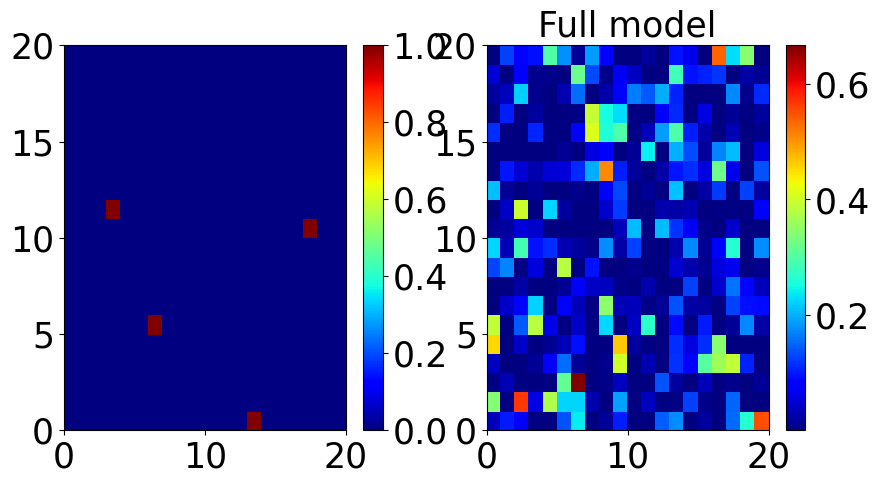

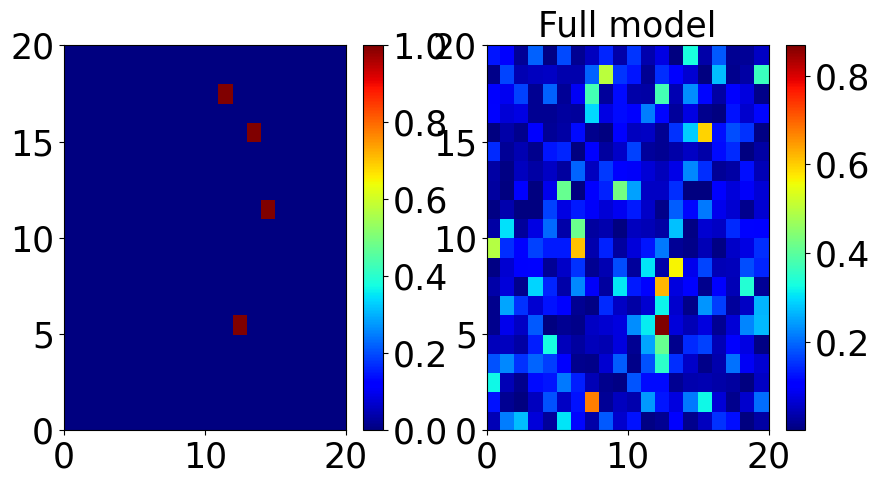

epoch: 250, train loss: 0.020398632530122994, L1 loss: 0.12000224972143769, val loss: 0.020329661667346954, max avg inners: 0.8396438574529429, GELMA loss: -0.0014270199724705892, num indices: 12
epoch: 251, train loss: 0.01514584724791348, L1 loss: 0.030795593018410727, val loss: 0.023336954414844513, max avg inners: 0.840822324558577, GELMA loss: -0.0007664835640753152, num indices: 10
epoch: 252, train loss: 0.012593446904793384, L1 loss: 0.018886397971073166, val loss: 0.02340981923043728, max avg inners: 0.8417944545212699, GELMA loss: -0.0005519535454368452, num indices: 4
epoch: 253, train loss: 0.011251493939198555, L1 loss: 0.01783442494343035, val loss: 0.02314954251050949, max avg inners: 0.842012715065773, GELMA loss: -0.00015175867192738224, num indices: 3
epoch: 254, train loss: 0.010662666545249522, L1 loss: 0.017548577685374767, val loss: 0.023146377876400948, max avg inners: 0.8420304366523981, GELMA loss: -0.00018111778481397778, num indices: 2
epoch: 255, train loss:

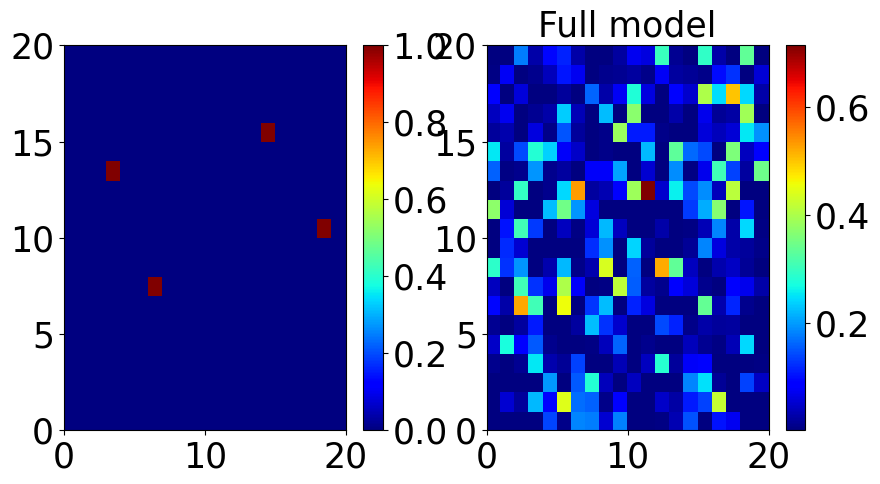

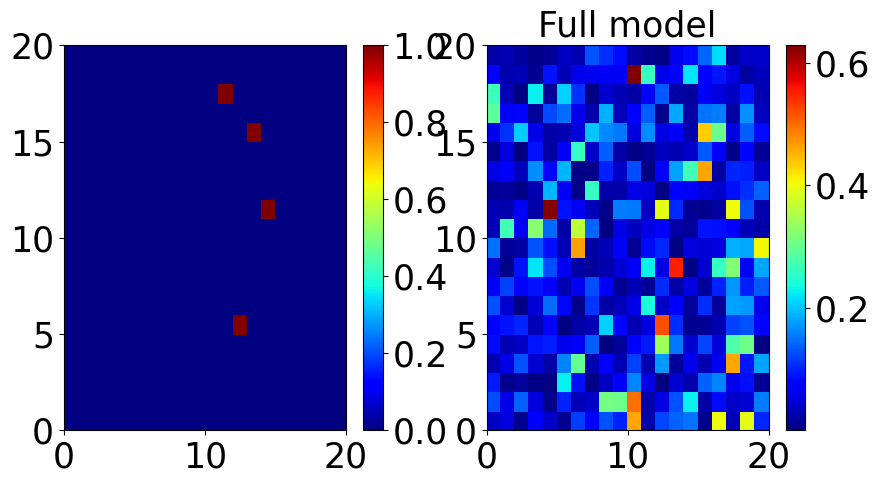

epoch: 300, train loss: 0.020165010122582316, L1 loss: 0.11854039668105543, val loss: 0.020128708332777023, max avg inners: 0.8433257685082518, GELMA loss: -0.002113342507800553, num indices: 19
epoch: 301, train loss: 0.014665458886884149, L1 loss: 0.03065969207091257, val loss: 0.023159194737672806, max avg inners: 0.8442783078461111, GELMA loss: -0.00020582206416293048, num indices: 12
epoch: 302, train loss: 0.011863365559838713, L1 loss: 0.0187055466521997, val loss: 0.02302844636142254, max avg inners: 0.8447460146591314, GELMA loss: -0.00036324652937764763, num indices: 10
epoch: 303, train loss: 0.010835533845238388, L1 loss: 0.017906141438288614, val loss: 0.022977204993367195, max avg inners: 0.8448588336940642, GELMA loss: 5.836423370055855e-05, num indices: 5
epoch: 304, train loss: 0.01012687610927969, L1 loss: 0.017281267239013687, val loss: 0.023153003305196762, max avg inners: 0.8447876192327726, GELMA loss: 3.456464182818308e-05, num indices: 1
epoch: 305, train loss: 

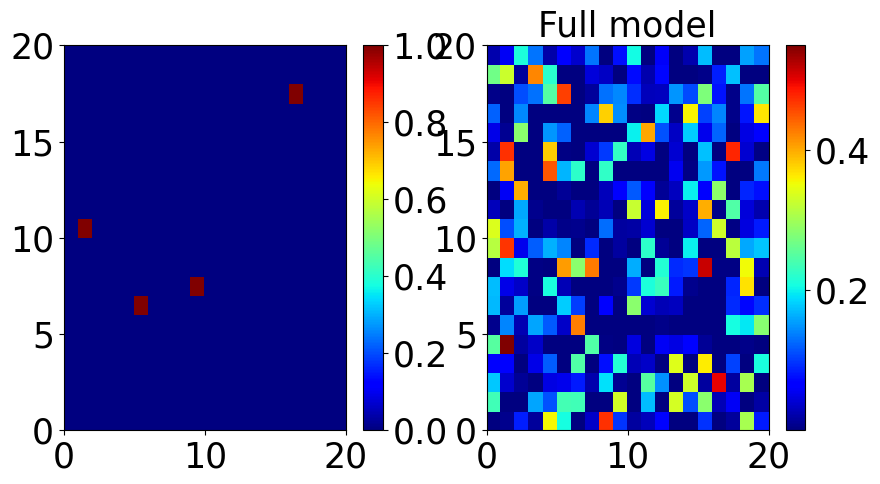

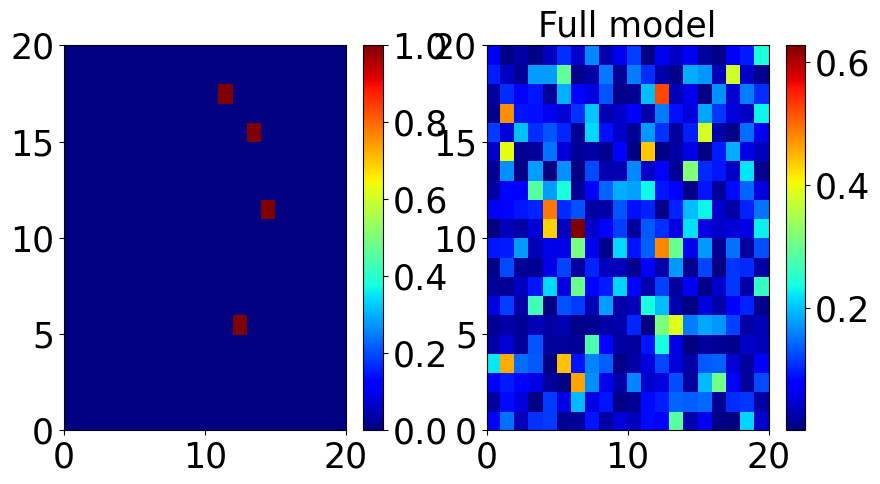

epoch: 350, train loss: 0.02029346828348934, L1 loss: 0.12063793116249144, val loss: 0.020150069147348404, max avg inners: 0.8471120147709543, GELMA loss: -0.0014979501254856588, num indices: 26
epoch: 351, train loss: 0.014809076697565617, L1 loss: 0.03128699748776853, val loss: 0.022897018119692802, max avg inners: 0.8480418326327591, GELMA loss: -0.00016325391115969994, num indices: 26
epoch: 352, train loss: 0.011788985854946078, L1 loss: 0.018438585539115593, val loss: 0.02288295514881611, max avg inners: 0.8488580894160295, GELMA loss: -0.00042120384532609025, num indices: 19
epoch: 353, train loss: 0.010725167416967453, L1 loss: 0.017612950498005375, val loss: 0.022935764864087105, max avg inners: 0.8492274364450609, GELMA loss: 0.00011718493115040471, num indices: 11
epoch: 354, train loss: 0.009978768182918431, L1 loss: 0.01704902609344572, val loss: 0.022687427699565887, max avg inners: 0.8493110493732674, GELMA loss: -0.0002997149636939866, num indices: 8
epoch: 355, train l

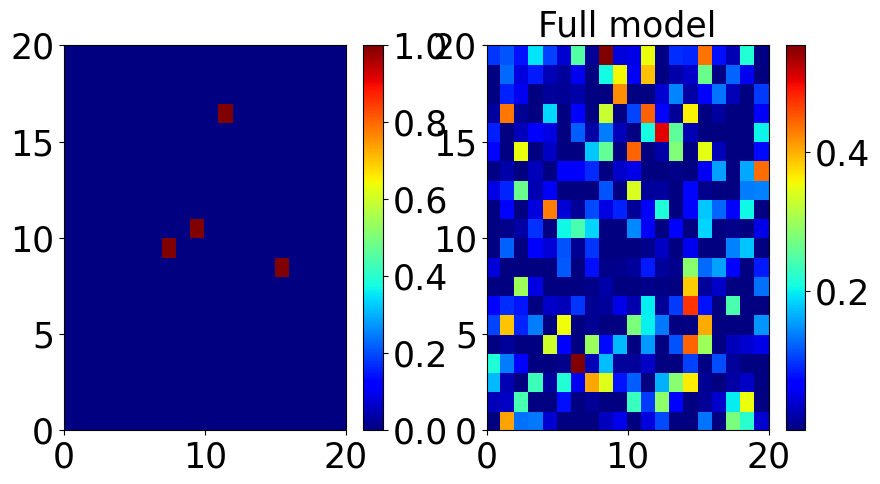

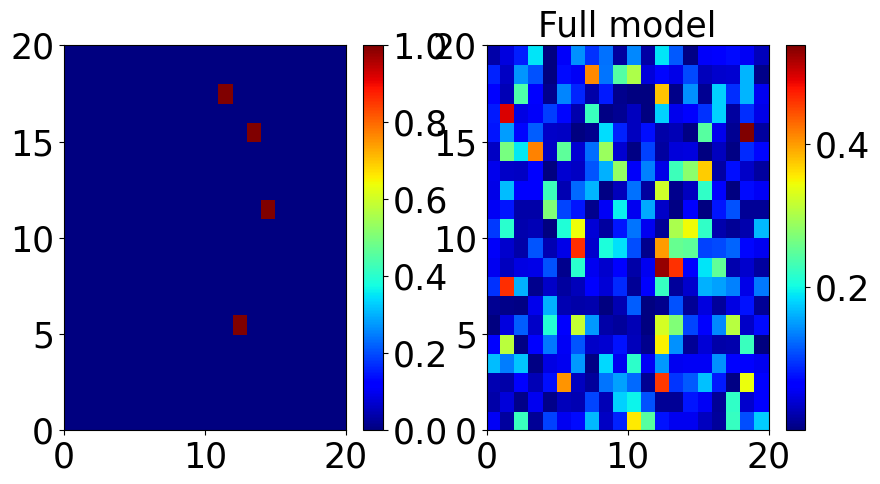

epoch: 400, train loss: 0.020332413772121076, L1 loss: 0.1199272247031331, val loss: 0.02020275965332985, max avg inners: 0.8526045121310536, GELMA loss: -0.0014187591885274746, num indices: 25
epoch: 401, train loss: 0.014914204063825307, L1 loss: 0.031098541134269908, val loss: 0.023030143231153488, max avg inners: 0.8533147075706556, GELMA loss: -0.0006194871330080785, num indices: 24
epoch: 402, train loss: 0.012052885442972183, L1 loss: 0.01879608110175468, val loss: 0.022847335785627365, max avg inners: 0.8537319309728443, GELMA loss: -0.0002965668005344924, num indices: 22
epoch: 403, train loss: 0.010939813312143085, L1 loss: 0.017832695855759084, val loss: 0.02269016019999981, max avg inners: 0.8537271288136652, GELMA loss: -0.0001924806972965598, num indices: 15
epoch: 404, train loss: 0.009992067283019422, L1 loss: 0.0170714836276602, val loss: 0.022798744961619377, max avg inners: 0.8535481146862343, GELMA loss: 9.135529908235186e-05, num indices: 8
epoch: 405, train loss: 

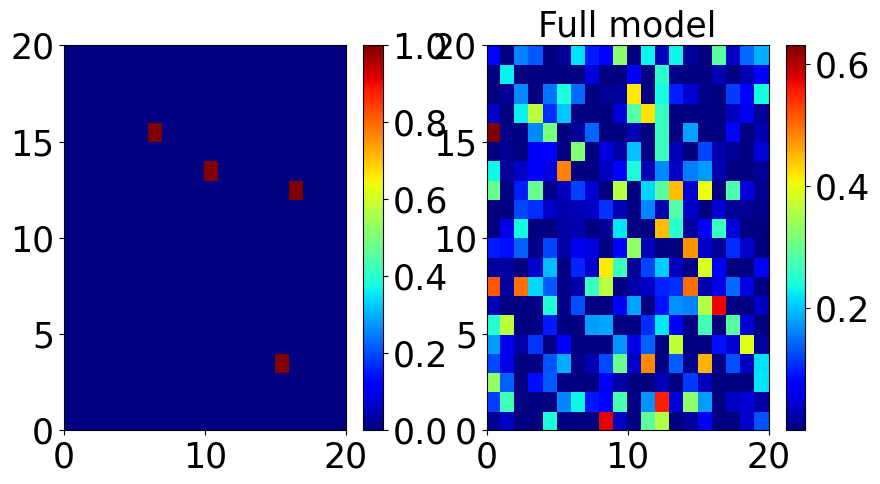

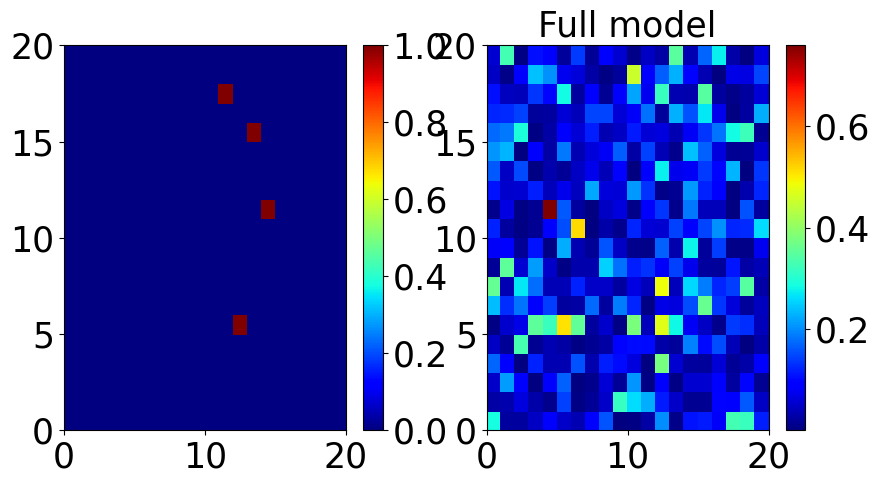

epoch: 450, train loss: 0.020362483663484456, L1 loss: 0.12095400178804994, val loss: 0.020377572625875473, max avg inners: 0.857519544730989, GELMA loss: -0.00085529397620121, num indices: 34
epoch: 451, train loss: 0.01522920457646251, L1 loss: 0.031292528234189376, val loss: 0.023110870271921158, max avg inners: 0.8582024342321175, GELMA loss: -0.000720387159890379, num indices: 30
epoch: 452, train loss: 0.012082981038838628, L1 loss: 0.018496641103411093, val loss: 0.022680912166833878, max avg inners: 0.8588626267417107, GELMA loss: -0.0004409818109706975, num indices: 29
epoch: 453, train loss: 0.011507185618393123, L1 loss: 0.018249412125442177, val loss: 0.022917546331882477, max avg inners: 0.8591640135799709, GELMA loss: -0.0002671250615094323, num indices: 20
epoch: 454, train loss: 0.010795574286021292, L1 loss: 0.017496801126981154, val loss: 0.023063912987709045, max avg inners: 0.8591703257252259, GELMA loss: -0.00015237548868753952, num indices: 14
epoch: 455, train lo

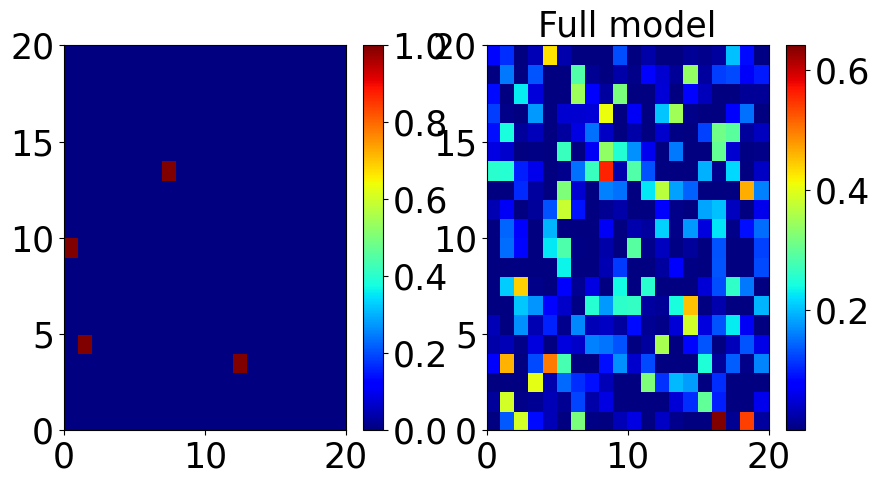

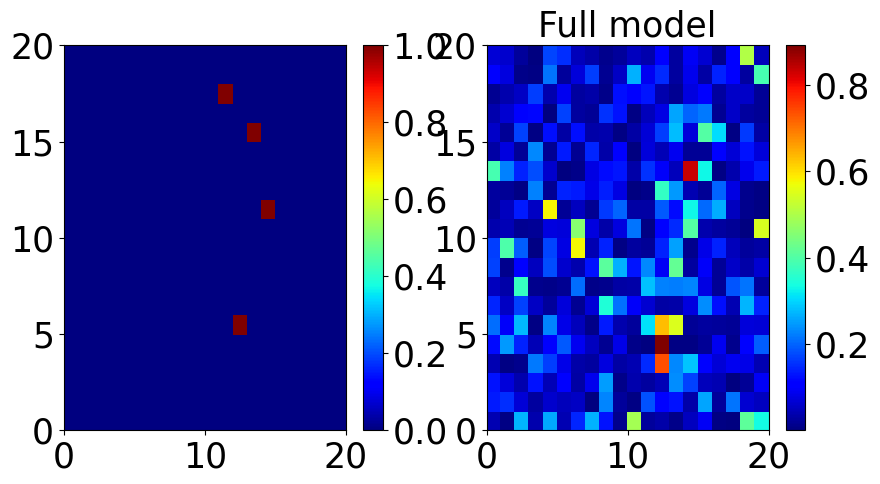

epoch: 500, train loss: 0.020172646408900614, L1 loss: 0.11874218308366835, val loss: 0.02012384682893753, max avg inners: 0.863684228535613, GELMA loss: -0.0014649169766926208, num indices: 35
epoch: 501, train loss: 0.014602489513345062, L1 loss: 0.03033764791325666, val loss: 0.02320561371743679, max avg inners: 0.8641978766906386, GELMA loss: -0.0008059452215093187, num indices: 34
epoch: 502, train loss: 0.012283184216357764, L1 loss: 0.01867614107322879, val loss: 0.02272365614771843, max avg inners: 0.8645513701292187, GELMA loss: 1.835803814174141e-05, num indices: 29
epoch: 503, train loss: 0.01119586005806923, L1 loss: 0.017936241783900186, val loss: 0.022794706746935844, max avg inners: 0.8645496913468145, GELMA loss: 2.1220141934463704e-05, num indices: 25
epoch: 504, train loss: 0.010658186115324498, L1 loss: 0.01749280307558365, val loss: 0.022907692939043045, max avg inners: 0.8643600980453792, GELMA loss: 1.5781237743794923e-05, num indices: 15
epoch: 505, train loss: 0

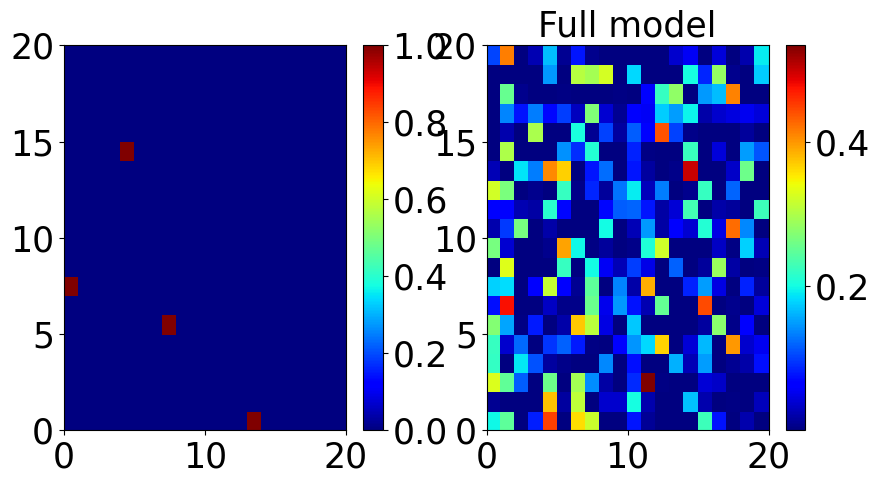

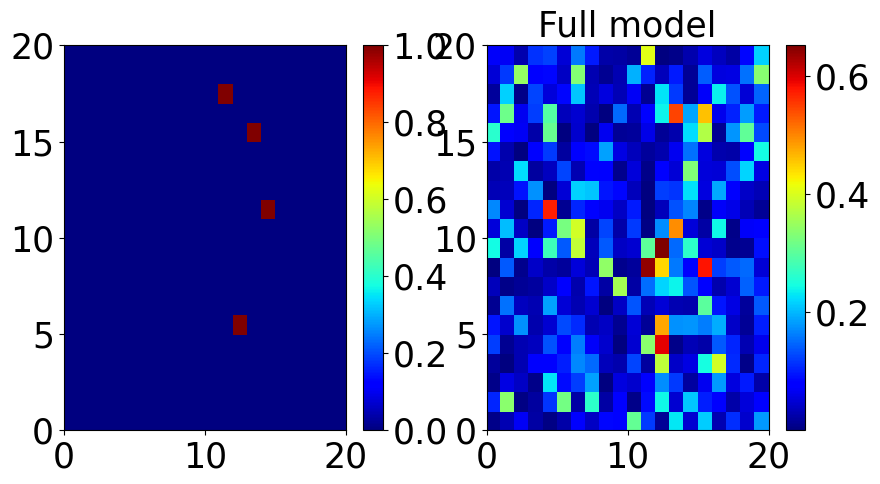

epoch: 550, train loss: 0.020129946013912558, L1 loss: 0.11926210834644735, val loss: 0.02007005736231804, max avg inners: 0.8668562485724637, GELMA loss: -0.001695039551850641, num indices: 42
epoch: 551, train loss: 0.014663618174381552, L1 loss: 0.03139669485972263, val loss: 0.02275674231350422, max avg inners: 0.8674091023581747, GELMA loss: -0.0007231691073684487, num indices: 37
epoch: 552, train loss: 0.012564500956796112, L1 loss: 0.019633503223303705, val loss: 0.02239670790731907, max avg inners: 0.8678629628351263, GELMA loss: -6.9705900386907e-06, num indices: 36
epoch: 553, train loss: 0.01099644508212805, L1 loss: 0.01771717640804127, val loss: 0.02249612659215927, max avg inners: 0.8678506181395198, GELMA loss: -0.0001372972925310023, num indices: 34
epoch: 554, train loss: 0.009854490449652075, L1 loss: 0.01690230067470111, val loss: 0.022586066275835037, max avg inners: 0.8677533393779154, GELMA loss: -0.00014256672520787105, num indices: 28


In [7]:
#Raw data training unlabeled only
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
L1_weight=5e-2
THRESH_HOLD_VAL=.01
layers=[256]*10
#[500,500,500,300,300,400,800]#[3000,1000,500,300,300,300,300,300,300,300,300,300,300,300]#[3000,1500,1000,500,500,500,300,300,300,400,400,800]#[1000,1000,1000,500,500,500,300,300,300,400,400,400,800]
GELMA_layers=layers#[500,500,500,300,300,400,800]
CE=False
KM_in=False
INV_weight=0
RESHUFFLE=False
LR=1e-3
GELMA=5e-2
TIME_reverse=False
E_list=0
RESETS=50
GELMA_MAX=.5
GELMA_inc=0
G_0=True
Epochs=3000
index_list=[]
GELMA_MAX=.5
GELMA_inc=5e-4
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='89a70fbc572a495206df640bd6c9cbf2a4a0dcaa' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['unlabeled_data']=unlabeled_data 
    wandb.config['L1_weight']=L1_weight
    wandb.config['layers']=layers
    wandb.config['GELMA']=GELMA
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, normalize=True)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim*2, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
#decoder=M.fc_net_extra(outdim, layers[::-1], indim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}


if G_0:
    #G_0_w=np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])#
    G_0_w=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0_w.real), torch.tensor(G_0_w.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    print(f'G_0 initialization successful: {torch.allclose(medium_hat, G_0_w.T)}')


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)
relu=nn.ReLU()
leaky_relu=nn.LeakyReLU(THRESH_HOLD_VAL)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)


tanh=nn.Tanh()
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss() 
Threshold=nn.Threshold(THRESH_HOLD_VAL, 0)  
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1).to(device)

softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(enc_dim, GELMA_layers,enc_dim, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=LR, maximize=True)
    GELMA_net.to(device)
    #GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets#,outdim, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
#decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}


def rescale_rho(z):
    minimum, _=torch.min(z, -1, keepdim=True)
    maxium, _=torch.max(z, -1,   keepdim=True)
    z=(z-minimum)/(maxium-minimum)
    return z
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
if E_list>0:
    encs=[M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5) for i in range(E_list)]
    opts=[torch.optim.AdamW(enc.parameters(), lr=LR) for enc in encs]
    for enc in encs:
        enc.to(device)
for epoch in range(Epochs):
    if RESETS>0 and epoch%RESETS==0:
        encoder=M.fc_net_extra(enc_dim, layers,outdim*2, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)

#        encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
        encoder.to(device)
        if GELMA>0:
            GELMA_net=M.fc_net_batch(enc_dim, GELMA_layers,enc_dim, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
            optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=LR, maximize=True)
            GELMA_net.to(device)
            #decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
        #if G_0:
        #    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
        #    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
        #    G_0_w=G_0_w.float()
        #    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
        #    decoder.to(device)
        #    medium_hat=decoder(Complex_eye).squeeze()
        #    medium_hat=F.normalize(medium_hat, dim=-1)
        optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
        optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)
    train_lossavg=0
    train_lossavg=0
    L1_loss_avg=0
    coupled_grad=0
    project_grad=0

    inner_loss_term_avg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if E_list>0:
                for enc in encs:
                    enc.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            elif TIME_reverse:
                rho_hat=encoder(decoder.time_reverse(b.squeeze()))
            else:
                rho_hat=encoder(b)

            if E_list>0:
                rho_hats=[enc(b) for enc in encs]
                rho_hats=[relu(rho_hat) for rho_hat in rho_hats]
                for rho_hat_l in rho_hats:
                    max_rho_l, _=torch.max(rho_hat_l, dim=-1, keepdim=True)
                    rho_hat_l=rho_hat_l/max_rho_l

                b_hats=[decoder(rho_hat_l) for rho_hat_l in rho_hats]
                L2_loss=sum([L2_loss_fn(b_hat_l.squeeze(), b.squeeze()) for b_hat_l in b_hats])/len(b_hats)
                L2_loss.backward()
                for opt in opts:
                    opt.step()
            #rho_hat=sigmoid(rho_hat)
            #rho_hat=softmax(rho_hat)
            #rho_hat=relu(rho_hat)
            rho_hat=leaky_relu(rho_hat)
            max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
            rho_hat=abs(rho_hat)/max_rho
            #rho_hat=rescale_rho(rho_hat)
            #rho_hat=Threshold(abs(rho_hat))
            #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            #rho_hat=rho_hat/max_rho
            #rho_hat=tanh(rho_hat)

            

            b_hat=decoder(rho_hat)
            if INV_weight>0:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                complex_mat=Mhat_real+1j*Mhat_imag
                #print(f'og complex mat shape: {complex_mat.shape}')
                complex_mat=complex_mat.T #yes
                complex_mat=torch.linalg.pinv(complex_mat.T.conj()@complex_mat, hermitian=True)@complex_mat.T.conj()  
                complex_b=b_real+1j*b_imag
                complex_b=complex_b.T
                #print(complex_mat.shape, complex_b.shape)

                rho_inv=complex_mat@complex_b
                rho_inv=rho_inv.T
                rho_inv_real=rho_inv.real
                rho_inv_imag=rho_inv.imag
                INV_loss=L2_loss_fn(rho_inv_real, rho_hat)*INV_weight
                INV_loss.backward(retain_graph=True)
                INV_loss=INV_loss.item()/INV_weight
                


                
                
                




            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss_avg+=L1_loss.item()/L1_weight/len(trainloader)
            else:
                L1_loss=-1

            if CE>0:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)*CE
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()/CE

             
            
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward(retain_graph=True)

            L2_enc_grad=0
            for param in encoder.parameters():
                if param.grad is not None:
                    L2_enc_grad+=torch.sum(param.grad**2)
            L2_enc_grad=torch.sqrt(L2_enc_grad)
            L2_dec_grad=0
            for param in decoder.parameters():
                if param.grad is not None:
                    L2_dec_grad+=torch.sum(param.grad**2)
            L2_dec_grad=torch.sqrt(L2_dec_grad)
            #if epoch>10 and batch==0:
            #    print(f'enc grad: {L2_enc_grad}, dec grad: {L2_dec_grad}')



            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()/len(trainloader)


            if GELMA>0 and epoch>0:
                optimizer_GELMA.zero_grad()
                optimizer.zero_grad()
                optimizer_decod.zero_grad()
                
                GELMA_out=GELMA_net(b).squeeze()
                GELMA_out=F.normalize(GELMA_out, dim=-1).squeeze()
                b_hat=b_hat.squeeze()

                GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_coupled=sum(GELMA_inners_coupled)/(torch.numel(GELMA_inners_coupled))
                GELMA_inners_project=(torch.inner((b).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_project=sum(GELMA_inners_project)/(torch.numel(GELMA_inners_project))
                (GELMA_inners_project+GELMA_inners_coupled).backward(retain_graph=True)
                
                optimizer_GELMA.step()
                optimizer_GELMA.zero_grad()



                inner_loss_term_avg+=(GELMA_inners_project+GELMA_inners_coupled).item()/len(trainloader)
                optimizer.zero_grad()
                optimizer_decod.zero_grad()
                GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_coupled=GELMA*sum(GELMA_inners_coupled)/(torch.numel(GELMA_inners_coupled))
                GELMA_inners_coupled.backward()
                optimizer.step()
                optimizer_decod.step()
            
            else:
                inner_loss_term_avg=-1

    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%49==0:
        rho_hat_real, rho_hat_imag=torch.split(rho_hat, int(rho_hat.shape[1]/2), dim=-1)
        rho_hat=(rho_hat_real**2+rho_hat_imag**2)**1/2

        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()
    #if GELMA_inc>0 and GELMA<GELMA_MAX:
    #    GELMA=GELMA*GELMA_inc
    #    if GELMA>GELMA_MAX:
    #        GELMA=GELMA_MAX
    #        print('GELMA max reached')

    if INV_weight>0 and INV_weight<1e-1:
        INV_weight=INV_weight*(1.03)


    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    #rho_hat=sigmoid(rho_hat)
    #rho_hat=relu(rho_hat)
    #rho_hat=leaky_relu(rho_hat)
    #max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
    #rho_hat=abs(rho_hat)/max_rho
    #rho_hat=softmax(rho_hat)
    #rho_hat=rescale_rho(rho_hat)
    #rho_hat=Threshold(abs(rho_hat))
    #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
    #rho_hat=rho_hat/max_rho
    #rho_hat=tanh(rho_hat)torch.split(rho, int(rho.shape[-1]/2), dim=-1)
    
    b_hat=decoder(rho_hat) 
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%49==0:
        rho_hat_real, rho_hat_imag=torch.split(rho_hat, int(rho_hat.shape[1]/2), dim=-1)
        rho_hat=(rho_hat_real**2+rho_hat_imag**2)**1/2

        H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        index_list=[]
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.99 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        #print(f'coupled grad: {coupled_grad}, project grad: {project_grad}')
        wand_dict['train loss']=train_lossavg
        wand_dict['val loss']=val_lossavg
        if L1_loss>0:
            wand_dict['L1 loss']=L1_loss
        if GELMA>0:
            wand_dict['GELMA loss']=inner_loss_term_avg

    
        wand_dict['max avg inners']=max_avg_inners_original
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [21]:
class norm_linear_complex(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(norm_linear_complex, self).__init__()
        self.weight=nn.Parameter((torch.rand(out_dim, in_dim)-.5)/(in_dim**(1/2)))
    
    def forward(self,x):
        x=x.squeeze()
        weights=F.normalize(self.weight,dim=0)
        weights=weights.t()
        print(weights.shape, x.shape)
        weights_real, weights_imag=torch.split(weights, int(weights.shape[1]/2), dim=-1)
        x_real, x_imag=torch.split(x.squeeze(), int(x.shape[1]/2), dim=-1)
        out_real=torch.matmul(x_real,weights_real)-torch.matmul(x_imag,weights_imag)
        out_imag=torch.matmul(x_real,weights_imag)+torch.matmul(x_imag,weights_real)
        out=torch.cat((out_real,out_imag),-1)
        out=F.normalize(out,dim=-1)
        return out
    
    def time_reverse(self, x):
        weights=F.normalize(self.weight,dim=1)
        weights_real, weights_imag=torch.split(weights.t(), int(weights.t().shape[1]/2), dim=-1)
        weights_imag=-weights_imag
        x_real, x_imag=torch.split(x, int(x.shape[1]/2), dim=-1)
        out_real=torch.matmul(x_real,weights_real.t())-torch.matmul(x_imag,weights_imag.t())
        out_imag=torch.matmul(x_real,weights_imag.t())+torch.matmul(x_imag,weights_real.t())
        out=torch.cat((out_real,out_imag),-1)
        out=out.squeeze()
        return out
decoder=norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
decoder.to(device)
print(rho_val.shape,Complex_eye.shape)
Complex_eye=torch.eye(int(training_data.rho[0].shape[0]/2)).to(device)
medium_hat=decoder(Complex_eye).squeeze()
medium_hat=decoder(rho_val).squeeze()

torch.Size([3000, 800]) torch.Size([400, 400])


NameError: name 'out_dim' is not defined

In [3]:
encoder

fc_net_extra(
  (dropout): Dropout(p=0, inplace=False)
  (layers): ModuleList(
    (0): complex_linear_layer(
      (dropout): Dropout(p=0, inplace=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (real_layer): Linear(in_features=1450, out_features=512, bias=True)
      (real_batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (imag_layer): Linear(in_features=1450, out_features=512, bias=True)
      (imag_batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1-9): 9 x complex_linear_layer(
      (dropout): Dropout(p=0, inplace=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (real_layer): Linear(in_features=512, out_features=512, bias=True)
      (real_batch): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (imag_layer): Linear(in_features=512, out_features=512, bias=True)
      (imag_batch): BatchNorm1d(512, eps=1e-05, momentum=0

(1450, 400)
(400, 400)
coherence of data:  0.7119395644427652
Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
G_0 initialization successful: True
12848304
Data shapes: 1450.0 200.0


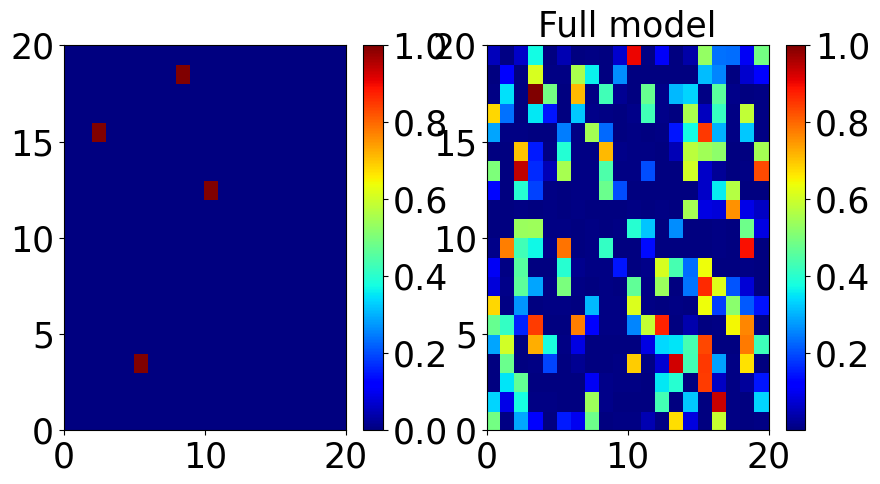

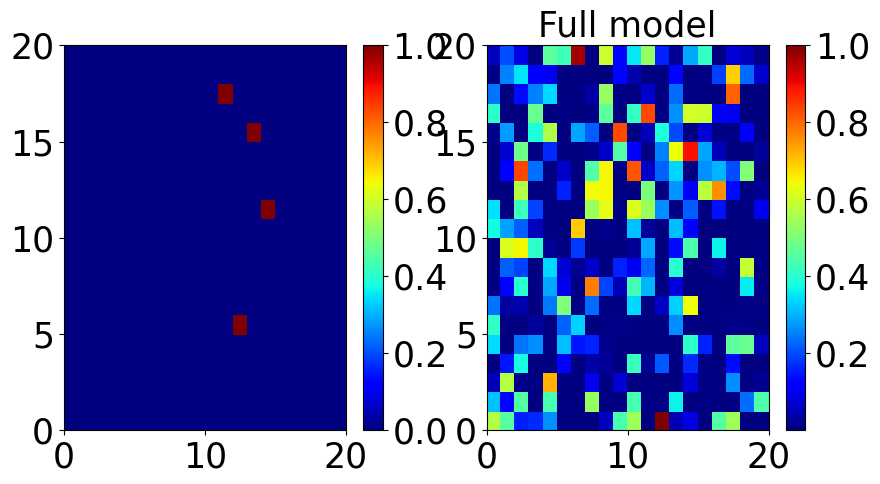

epoch: 0, train loss: 0.02290896810591221, L1 loss: 0, val loss: 0.02338600531220436, max avg inners: 0.2985769452254454, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 0.02223243243061006, L1 loss: 0, val loss: 0.021225595846772194, max avg inners: 0.32775961797213266, GELMA loss: -1, num indices: 0
epoch: 2, train loss: 0.019938334310427304, L1 loss: 0, val loss: 0.020632153376936913, max avg inners: 0.3832859749073014, GELMA loss: -1, num indices: 0
epoch: 3, train loss: 0.019199635973200197, L1 loss: 0, val loss: 0.020470593124628067, max avg inners: 0.4379682814210167, GELMA loss: -1, num indices: 0
epoch: 4, train loss: 0.018507583998143673, L1 loss: 0, val loss: 0.02040572091937065, max avg inners: 0.48019818637127515, GELMA loss: -1, num indices: 0
epoch: 5, train loss: 0.018255798425525428, L1 loss: 0, val loss: 0.019802110269665718, max avg inners: 0.5138419530319136, GELMA loss: -1, num indices: 0
epoch: 6, train loss: 0.017621519463136795, L1 loss: 0, val loss: 0.0191

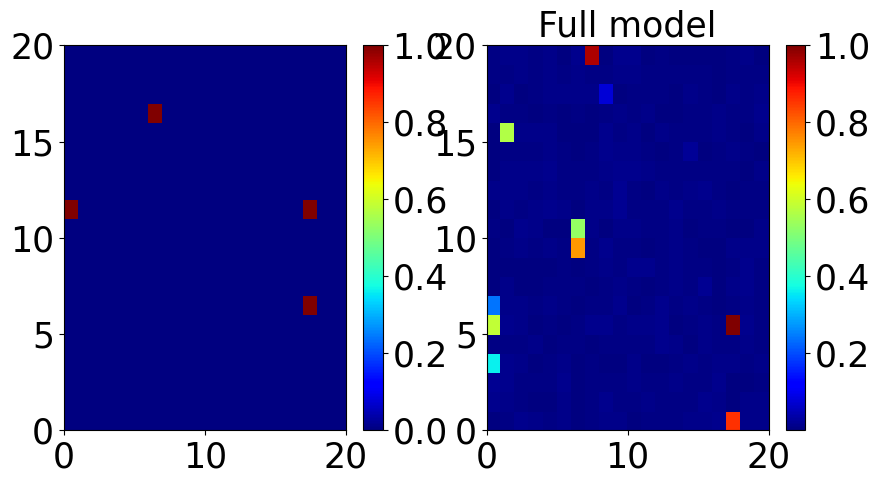

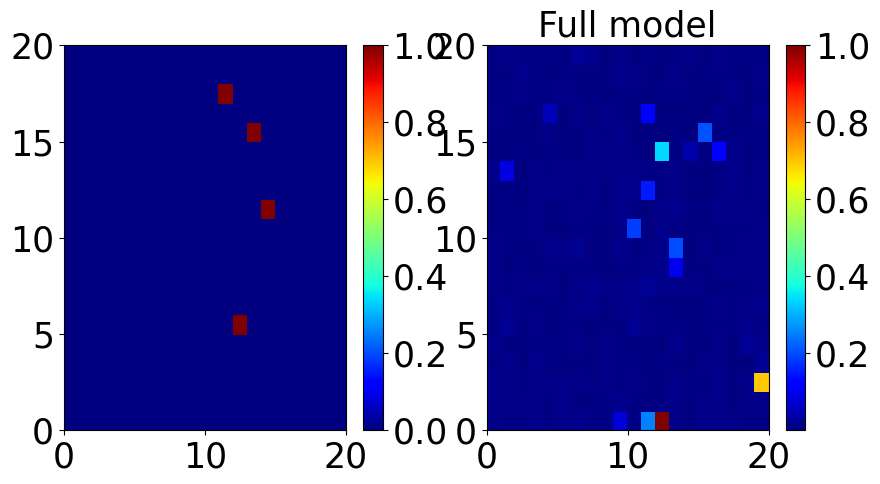

epoch: 50, train loss: 0.007765144330915063, L1 loss: 0, val loss: 0.015338685363531113, max avg inners: 0.8470452408067498, GELMA loss: -1, num indices: 98
epoch: 51, train loss: 0.007738451403565705, L1 loss: 0, val loss: 0.015281238593161106, max avg inners: 0.848181496260326, GELMA loss: -1, num indices: 98
epoch: 52, train loss: 0.00764845284866169, L1 loss: 0, val loss: 0.015283675864338875, max avg inners: 0.8490784458036722, GELMA loss: -1, num indices: 100
epoch: 53, train loss: 0.0077748343115672455, L1 loss: 0, val loss: 0.015317987650632858, max avg inners: 0.8506349837911641, GELMA loss: -1, num indices: 104
epoch: 54, train loss: 0.007637561718001963, L1 loss: 0, val loss: 0.015271693468093872, max avg inners: 0.8511876169103262, GELMA loss: -1, num indices: 103
epoch: 55, train loss: 0.0074894922552630324, L1 loss: 0, val loss: 0.01523006334900856, max avg inners: 0.8521275012947119, GELMA loss: -1, num indices: 106
epoch: 56, train loss: 0.007362699543591589, L1 loss: 0

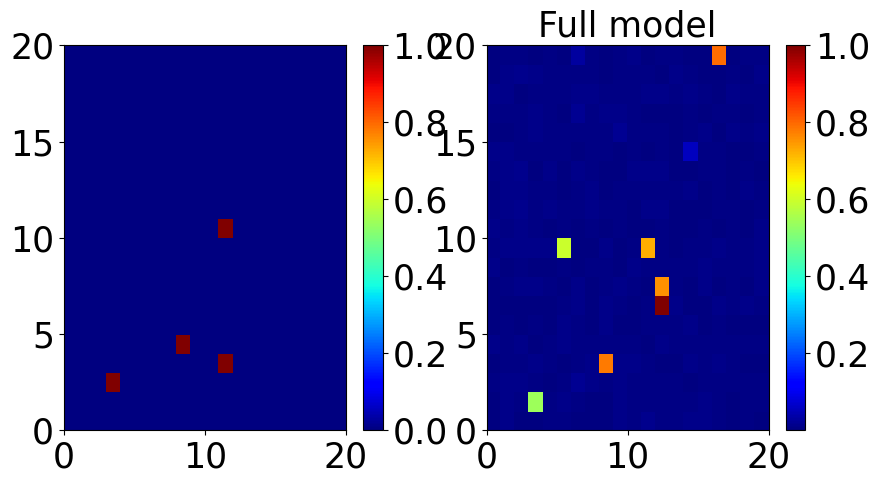

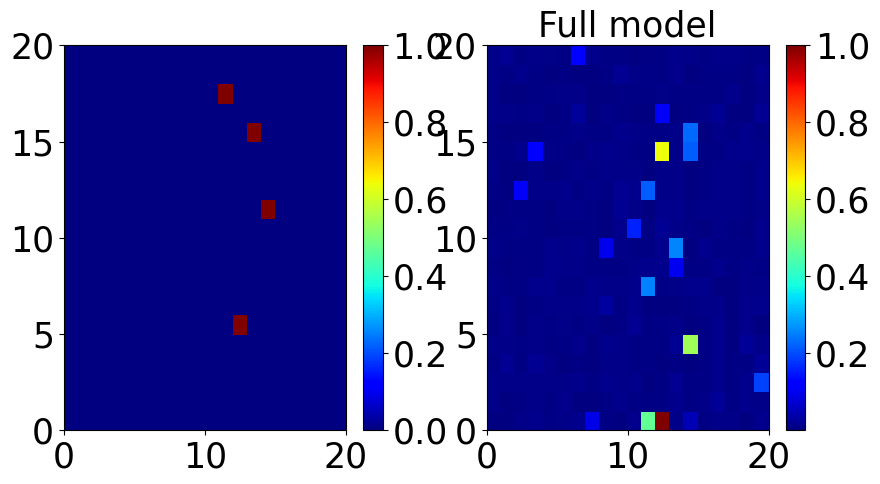

epoch: 100, train loss: 0.006290171563159676, L1 loss: 0, val loss: 0.015046590939164162, max avg inners: 0.871393118880115, GELMA loss: -1, num indices: 157
epoch: 101, train loss: 0.0063730109250172955, L1 loss: 0, val loss: 0.0150820417329669, max avg inners: 0.8715077687538478, GELMA loss: -1, num indices: 155
epoch: 102, train loss: 0.006351967062801122, L1 loss: 0, val loss: 0.015176660381257534, max avg inners: 0.8718497040706733, GELMA loss: -1, num indices: 155
epoch: 103, train loss: 0.006419510627165437, L1 loss: 0, val loss: 0.015175383538007736, max avg inners: 0.8720611167659791, GELMA loss: -1, num indices: 154
epoch: 104, train loss: 0.00636051190085709, L1 loss: 0, val loss: 0.01504398975521326, max avg inners: 0.8719609893530493, GELMA loss: -1, num indices: 155
epoch: 105, train loss: 0.006283848325256259, L1 loss: 0, val loss: 0.01501529011875391, max avg inners: 0.8722424273187501, GELMA loss: -1, num indices: 157
epoch: 106, train loss: 0.006171028071548789, L1 lo

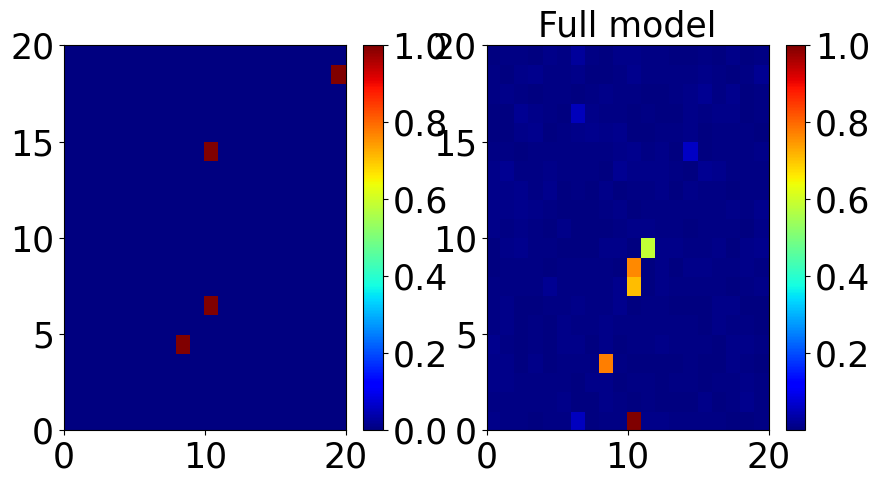

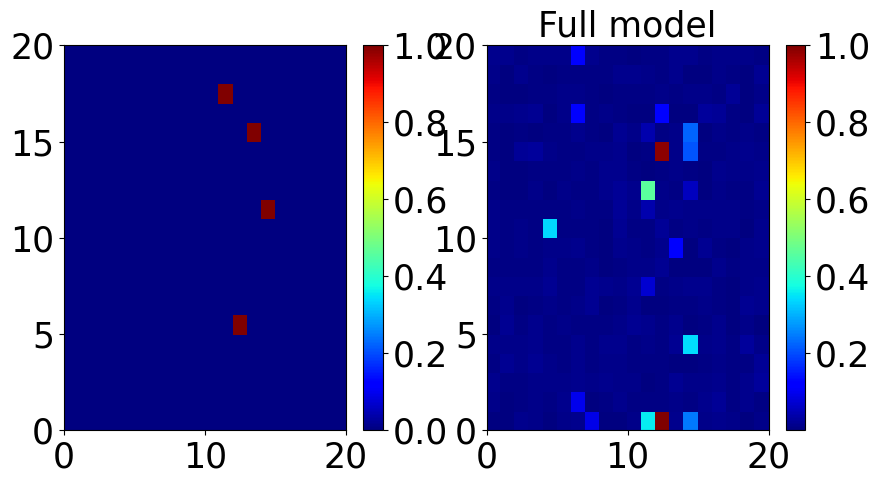

epoch: 150, train loss: 0.006002868863288313, L1 loss: 0, val loss: 0.015182070434093475, max avg inners: 0.8804024537840067, GELMA loss: -1, num indices: 180
epoch: 151, train loss: 0.005950781912542879, L1 loss: 0, val loss: 0.015141974203288555, max avg inners: 0.8803857566187486, GELMA loss: -1, num indices: 178
epoch: 152, train loss: 0.005978145066183061, L1 loss: 0, val loss: 0.015203404240310192, max avg inners: 0.8805613782632093, GELMA loss: -1, num indices: 180
epoch: 153, train loss: 0.006038707029074429, L1 loss: 0, val loss: 0.015216255560517311, max avg inners: 0.8807613363649943, GELMA loss: -1, num indices: 182
epoch: 154, train loss: 0.006072847929317505, L1 loss: 0, val loss: 0.015277991071343422, max avg inners: 0.8804417940507409, GELMA loss: -1, num indices: 179
epoch: 155, train loss: 0.0060632628155872234, L1 loss: 0, val loss: 0.01530832052230835, max avg inners: 0.8806752415420408, GELMA loss: -1, num indices: 183
epoch: 156, train loss: 0.00607497242745012, L

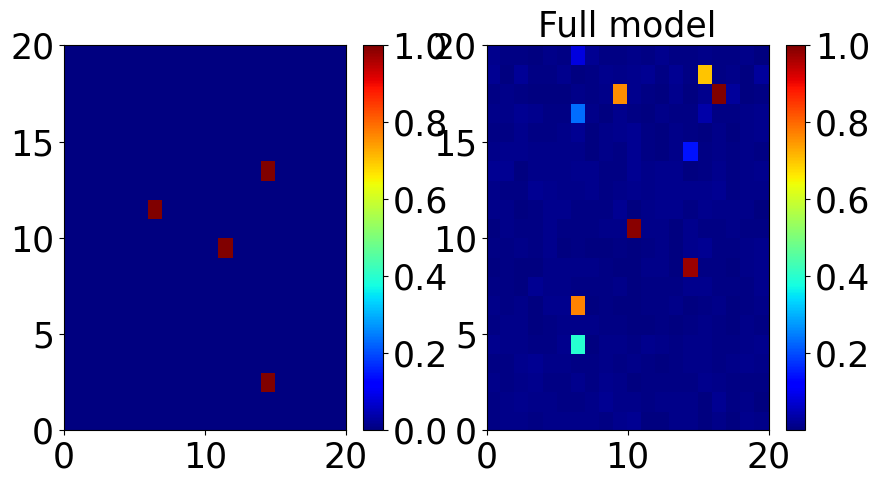

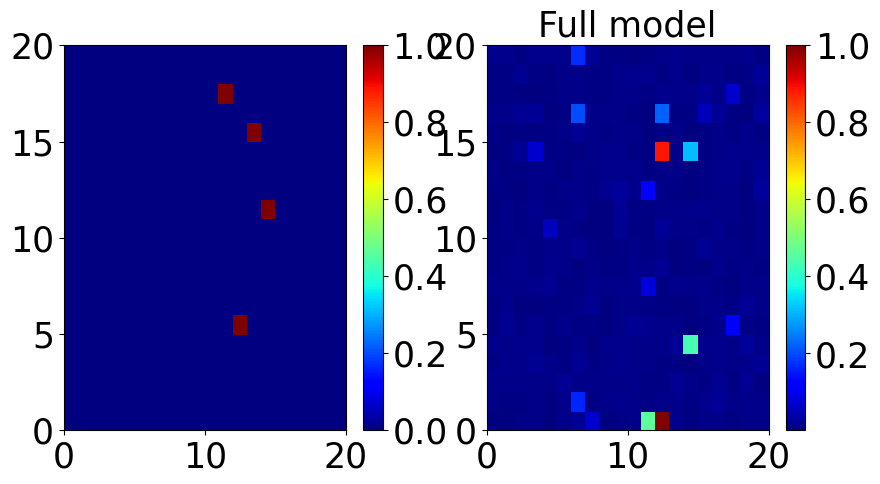

epoch: 200, train loss: 0.006237726227845997, L1 loss: 0, val loss: 0.015790048986673355, max avg inners: 0.8847884635564073, GELMA loss: -1, num indices: 188
epoch: 201, train loss: 0.006037082604598255, L1 loss: 0, val loss: 0.015659140422940254, max avg inners: 0.8850314720084731, GELMA loss: -1, num indices: 188
epoch: 202, train loss: 0.0060815564589574945, L1 loss: 0, val loss: 0.015746796503663063, max avg inners: 0.8852943359499545, GELMA loss: -1, num indices: 188
epoch: 203, train loss: 0.006016858899965882, L1 loss: 0, val loss: 0.015781782567501068, max avg inners: 0.885306328154722, GELMA loss: -1, num indices: 189
epoch: 204, train loss: 0.006027153308968992, L1 loss: 0, val loss: 0.015692992135882378, max avg inners: 0.8854474368668416, GELMA loss: -1, num indices: 189
epoch: 205, train loss: 0.005990337359253318, L1 loss: 0, val loss: 0.015615306794643402, max avg inners: 0.8854823666321748, GELMA loss: -1, num indices: 189
epoch: 206, train loss: 0.00590268869418651, L

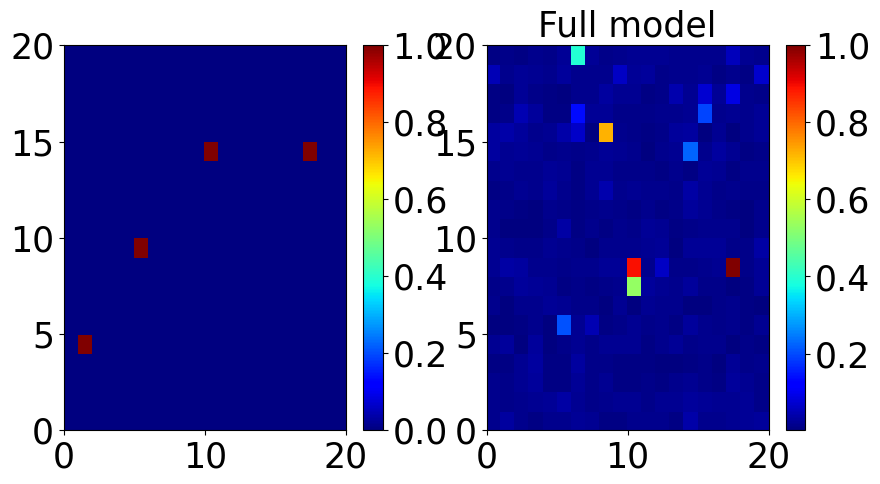

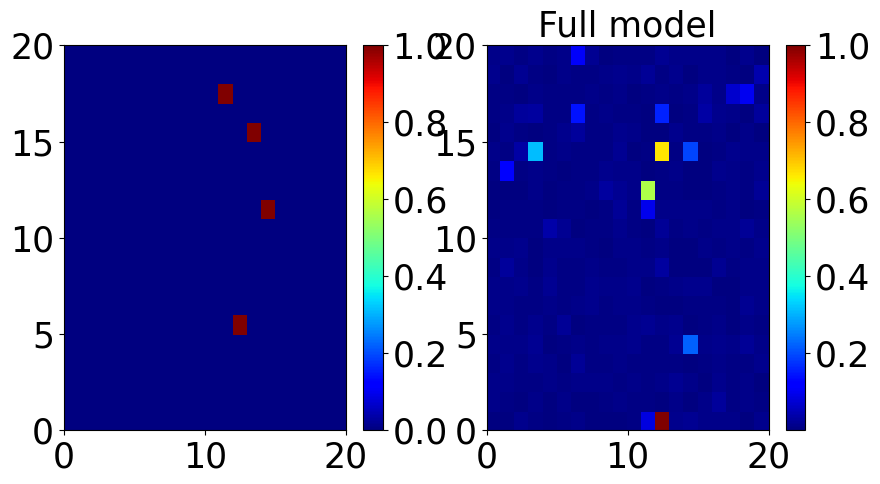

epoch: 250, train loss: 0.005812922667246313, L1 loss: 0, val loss: 0.01601734198629856, max avg inners: 0.8880940212400583, GELMA loss: -1, num indices: 197
epoch: 251, train loss: 0.005812796473037453, L1 loss: 0, val loss: 0.0162152461707592, max avg inners: 0.888124199700661, GELMA loss: -1, num indices: 197
epoch: 252, train loss: 0.005920364696066824, L1 loss: 0, val loss: 0.016093958169221878, max avg inners: 0.8881498817836555, GELMA loss: -1, num indices: 197
epoch: 253, train loss: 0.0059189594234339915, L1 loss: 0, val loss: 0.016159893944859505, max avg inners: 0.8882593712471022, GELMA loss: -1, num indices: 197
epoch: 254, train loss: 0.005903664440847934, L1 loss: 0, val loss: 0.016204271465539932, max avg inners: 0.8884635269318784, GELMA loss: -1, num indices: 197
epoch: 255, train loss: 0.005874035914894191, L1 loss: 0, val loss: 0.01618293859064579, max avg inners: 0.888600954665673, GELMA loss: -1, num indices: 197
epoch: 256, train loss: 0.00586795259732753, L1 los

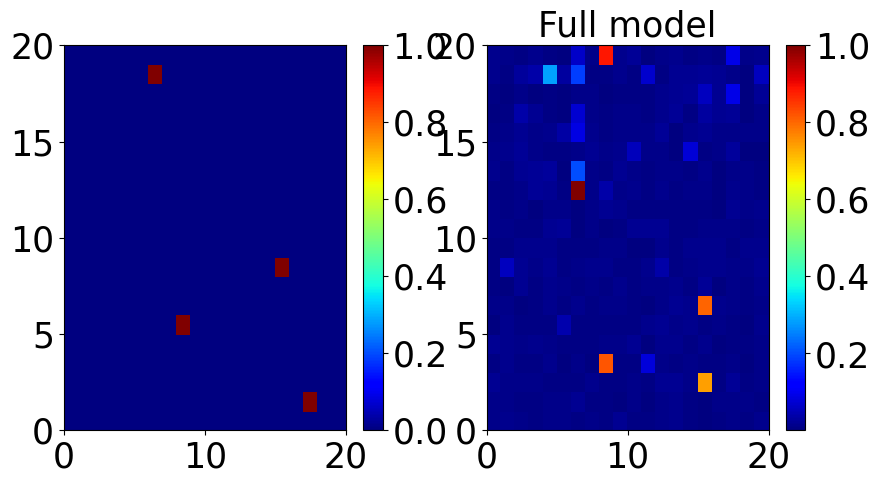

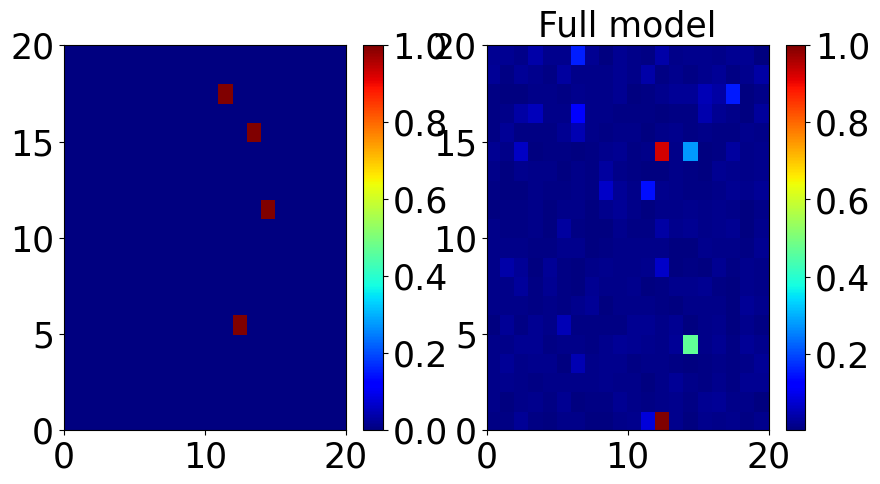

epoch: 300, train loss: 0.0055748292827047415, L1 loss: 0, val loss: 0.016421090811491013, max avg inners: 0.8914608162206267, GELMA loss: -1, num indices: 203
epoch: 301, train loss: 0.005573071434628218, L1 loss: 0, val loss: 0.016381094232201576, max avg inners: 0.8914857092676681, GELMA loss: -1, num indices: 203
epoch: 302, train loss: 0.005595059867482632, L1 loss: 0, val loss: 0.016517378389835358, max avg inners: 0.8915934693568244, GELMA loss: -1, num indices: 203
epoch: 303, train loss: 0.00563710198039189, L1 loss: 0, val loss: 0.016446739435195923, max avg inners: 0.8915394905209676, GELMA loss: -1, num indices: 203
epoch: 304, train loss: 0.0055825399002060305, L1 loss: 0, val loss: 0.016500432044267654, max avg inners: 0.8915981056525639, GELMA loss: -1, num indices: 202
epoch: 305, train loss: 0.005693441315088422, L1 loss: 0, val loss: 0.016492750495672226, max avg inners: 0.8918825821098757, GELMA loss: -1, num indices: 203
epoch: 306, train loss: 0.0055439385352656235

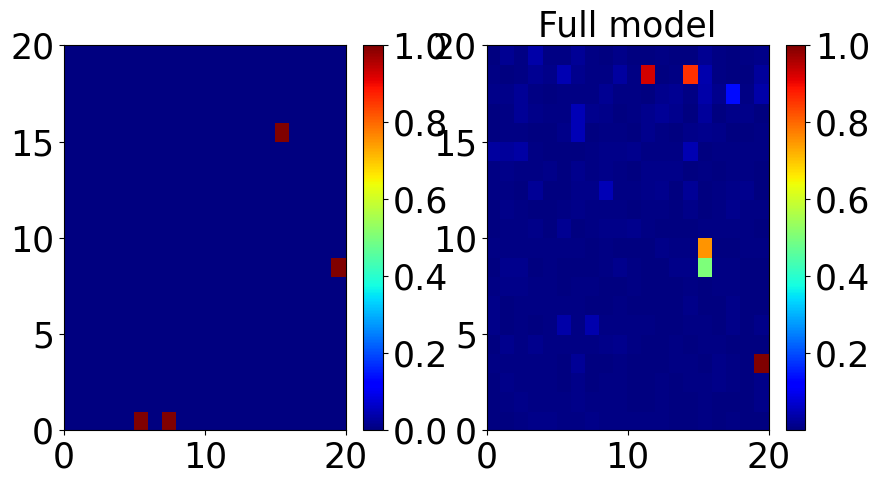

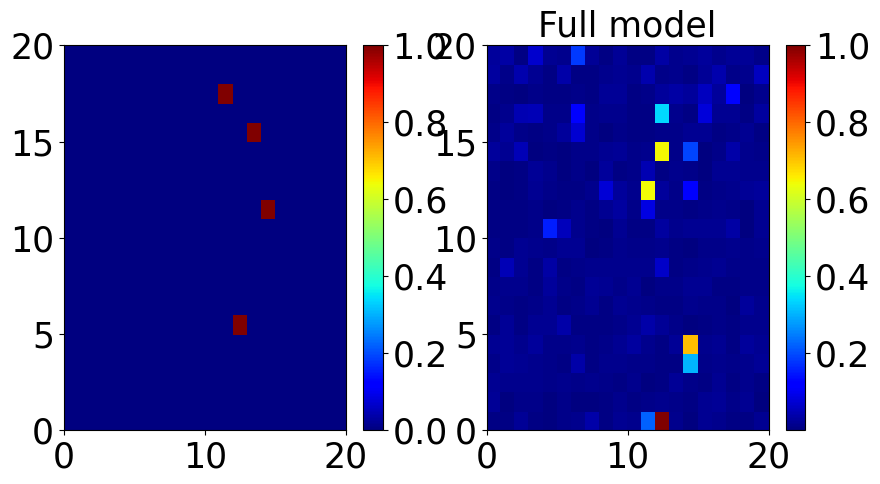

epoch: 350, train loss: 0.005261995049659162, L1 loss: 0, val loss: 0.016730917617678642, max avg inners: 0.8946373409693216, GELMA loss: -1, num indices: 215
epoch: 351, train loss: 0.005227173934690655, L1 loss: 0, val loss: 0.016639824956655502, max avg inners: 0.8947309863672475, GELMA loss: -1, num indices: 214
epoch: 352, train loss: 0.005271392711438239, L1 loss: 0, val loss: 0.016655247658491135, max avg inners: 0.8947777570832605, GELMA loss: -1, num indices: 216
epoch: 353, train loss: 0.005262154061347248, L1 loss: 0, val loss: 0.01662876456975937, max avg inners: 0.8947514367008981, GELMA loss: -1, num indices: 214
epoch: 354, train loss: 0.005223780346568674, L1 loss: 0, val loss: 0.01667102426290512, max avg inners: 0.8948839890912847, GELMA loss: -1, num indices: 216
epoch: 355, train loss: 0.005202716693747788, L1 loss: 0, val loss: 0.016659574583172798, max avg inners: 0.8948865665723011, GELMA loss: -1, num indices: 216
epoch: 356, train loss: 0.005222052440512926, L1

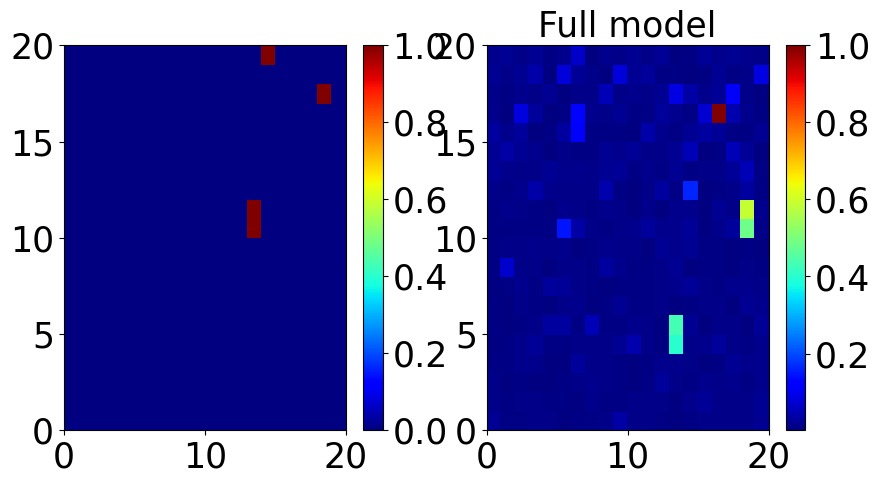

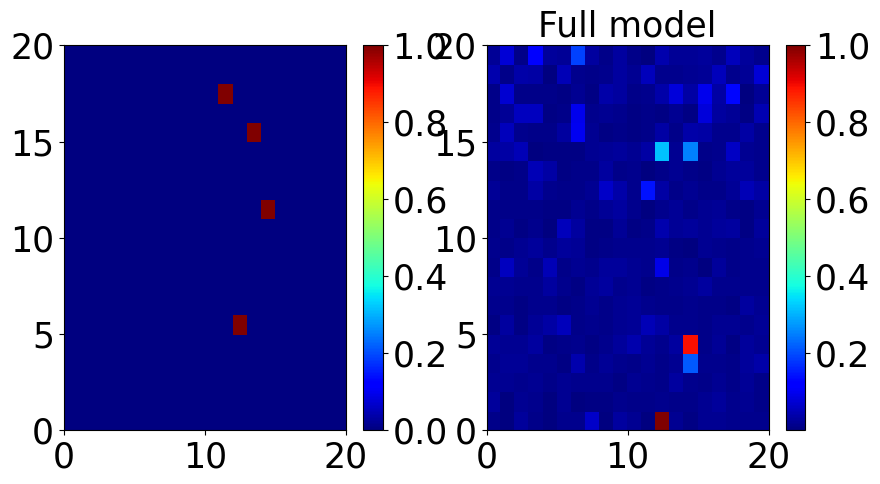

epoch: 400, train loss: 0.0049954725895076995, L1 loss: 0, val loss: 0.016909005120396614, max avg inners: 0.898070623127754, GELMA loss: -1, num indices: 219
epoch: 401, train loss: 0.0050830147578381, L1 loss: 0, val loss: 0.016974246129393578, max avg inners: 0.8983213623169182, GELMA loss: -1, num indices: 220
epoch: 402, train loss: 0.0050973418634384865, L1 loss: 0, val loss: 0.016968749463558197, max avg inners: 0.8982611382119198, GELMA loss: -1, num indices: 220
epoch: 403, train loss: 0.005028827651403844, L1 loss: 0, val loss: 0.016943899914622307, max avg inners: 0.8982806578099699, GELMA loss: -1, num indices: 218
epoch: 404, train loss: 0.0050150049268268045, L1 loss: 0, val loss: 0.01695510745048523, max avg inners: 0.8983383035333022, GELMA loss: -1, num indices: 217
epoch: 405, train loss: 0.005010517628397793, L1 loss: 0, val loss: 0.01698330231010914, max avg inners: 0.8984225867002293, GELMA loss: -1, num indices: 219
epoch: 406, train loss: 0.004958008846733719, L1

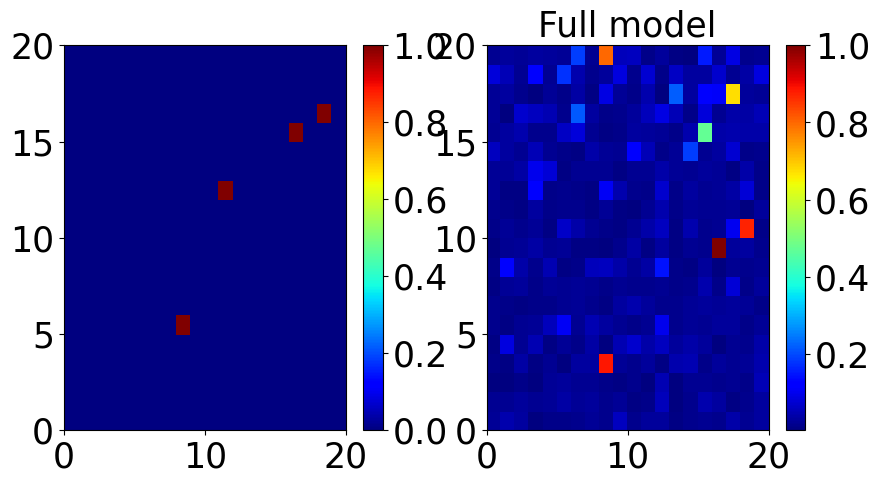

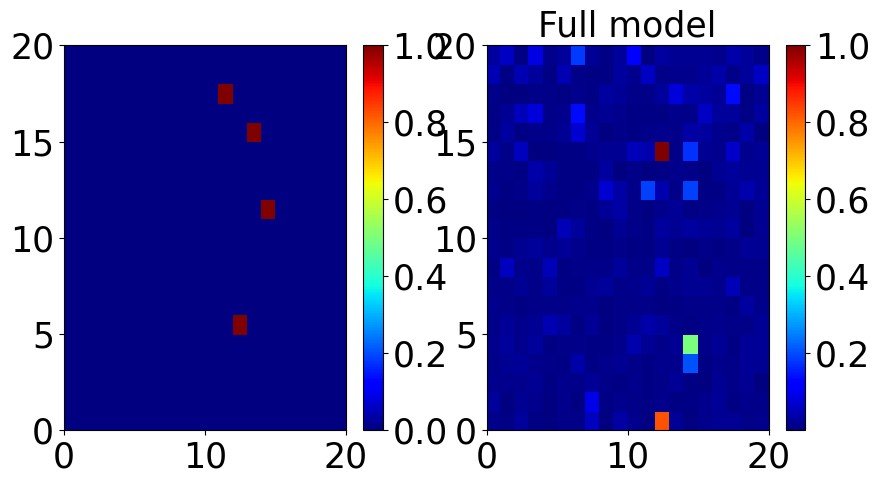

epoch: 450, train loss: 0.004748805158305914, L1 loss: 0, val loss: 0.017076846212148666, max avg inners: 0.901066460906124, GELMA loss: -1, num indices: 220
epoch: 451, train loss: 0.004750811832491308, L1 loss: 0, val loss: 0.01705808937549591, max avg inners: 0.9011106151327759, GELMA loss: -1, num indices: 222
epoch: 452, train loss: 0.00470621766289696, L1 loss: 0, val loss: 0.017062561586499214, max avg inners: 0.9011383643398768, GELMA loss: -1, num indices: 221
epoch: 453, train loss: 0.004781116161029784, L1 loss: 0, val loss: 0.017101867124438286, max avg inners: 0.9011404599124196, GELMA loss: -1, num indices: 221
epoch: 454, train loss: 0.004678877262631431, L1 loss: 0, val loss: 0.017097504809498787, max avg inners: 0.9011686386652855, GELMA loss: -1, num indices: 221
epoch: 455, train loss: 0.004729702800977975, L1 loss: 0, val loss: 0.017148498445749283, max avg inners: 0.9013731075224, GELMA loss: -1, num indices: 221
epoch: 456, train loss: 0.004778578912373632, L1 los

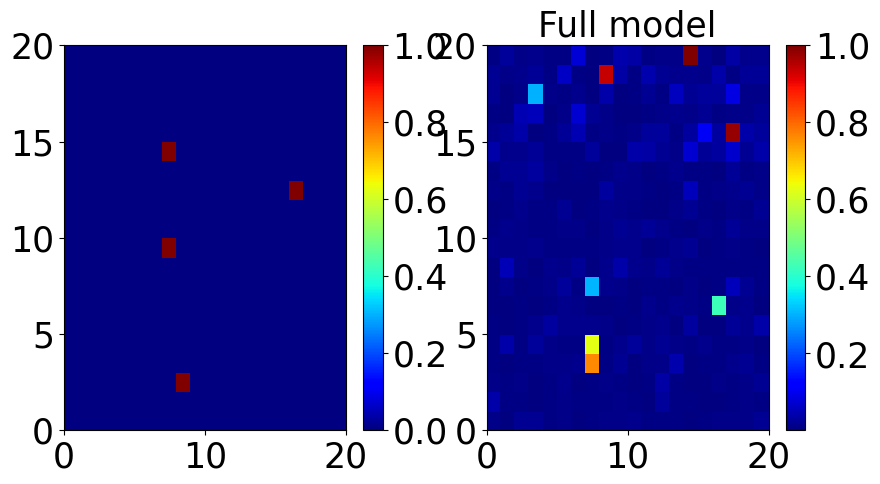

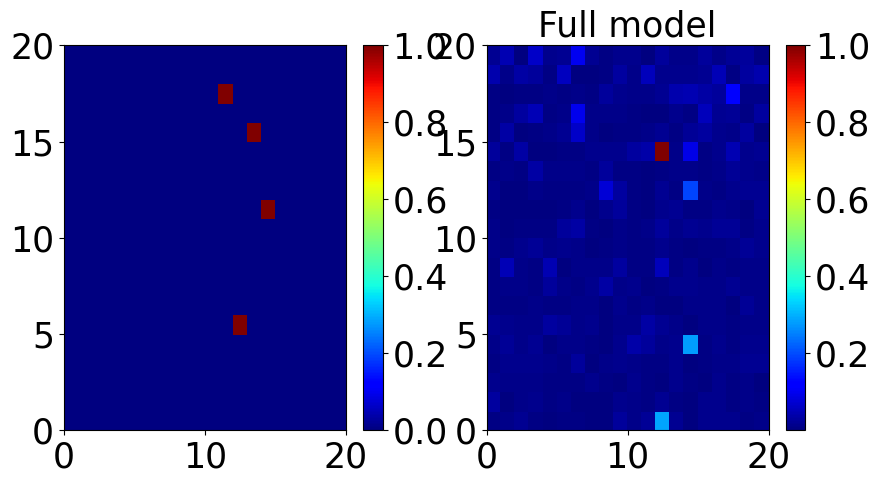

epoch: 500, train loss: 0.004633596760686487, L1 loss: 0, val loss: 0.017254041507840157, max avg inners: 0.9039319308074346, GELMA loss: -1, num indices: 224
epoch: 501, train loss: 0.004570410365704448, L1 loss: 0, val loss: 0.01723117008805275, max avg inners: 0.9039730550648966, GELMA loss: -1, num indices: 224
epoch: 502, train loss: 0.00456721925875172, L1 loss: 0, val loss: 0.017217902466654778, max avg inners: 0.9039997523105774, GELMA loss: -1, num indices: 225
epoch: 503, train loss: 0.0045345284976065145, L1 loss: 0, val loss: 0.01720457337796688, max avg inners: 0.9040777414111999, GELMA loss: -1, num indices: 224
epoch: 504, train loss: 0.004541429062373936, L1 loss: 0, val loss: 0.01729707419872284, max avg inners: 0.9042080250854742, GELMA loss: -1, num indices: 225
epoch: 505, train loss: 0.004604547785129396, L1 loss: 0, val loss: 0.017300475388765335, max avg inners: 0.9043784470192813, GELMA loss: -1, num indices: 225
epoch: 506, train loss: 0.004603944893460721, L1 

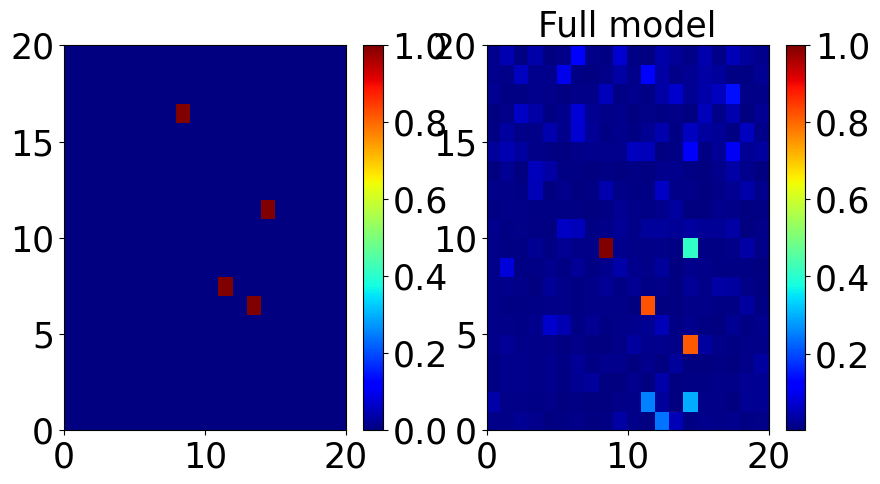

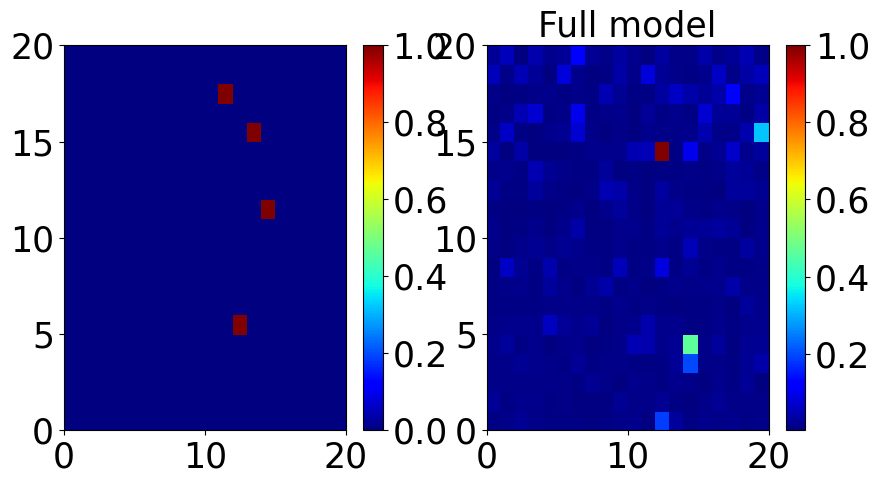

epoch: 550, train loss: 0.004586407722672448, L1 loss: 0, val loss: 0.01747715286910534, max avg inners: 0.9069122303465776, GELMA loss: -1, num indices: 229
epoch: 551, train loss: 0.004619193123653531, L1 loss: 0, val loss: 0.01741538755595684, max avg inners: 0.9070374360409136, GELMA loss: -1, num indices: 229
epoch: 552, train loss: 0.004557898407801986, L1 loss: 0, val loss: 0.017398394644260406, max avg inners: 0.9070691648460687, GELMA loss: -1, num indices: 229
epoch: 553, train loss: 0.0045916914357803755, L1 loss: 0, val loss: 0.017421651631593704, max avg inners: 0.907114999643499, GELMA loss: -1, num indices: 230
epoch: 554, train loss: 0.004591340071056037, L1 loss: 0, val loss: 0.017406057566404343, max avg inners: 0.9072356370939627, GELMA loss: -1, num indices: 229
epoch: 555, train loss: 0.004588842403609305, L1 loss: 0, val loss: 0.01751558482646942, max avg inners: 0.9072357920707215, GELMA loss: -1, num indices: 229
epoch: 556, train loss: 0.004583514673868194, L1 

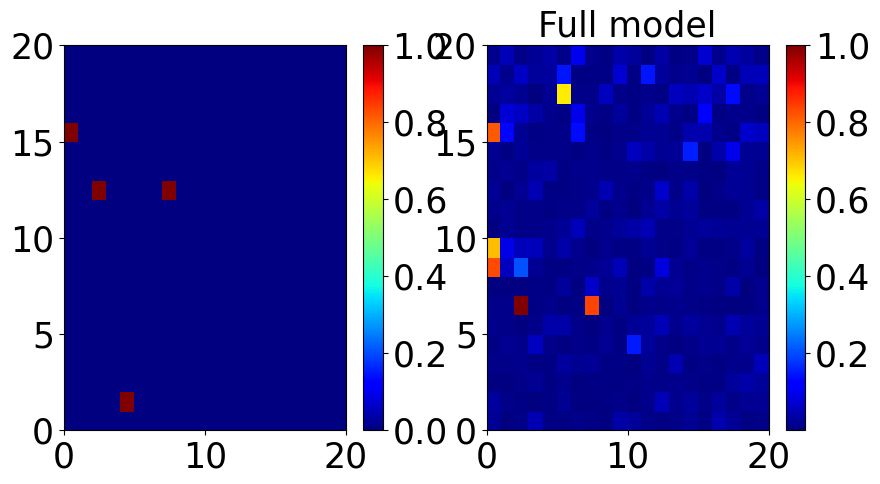

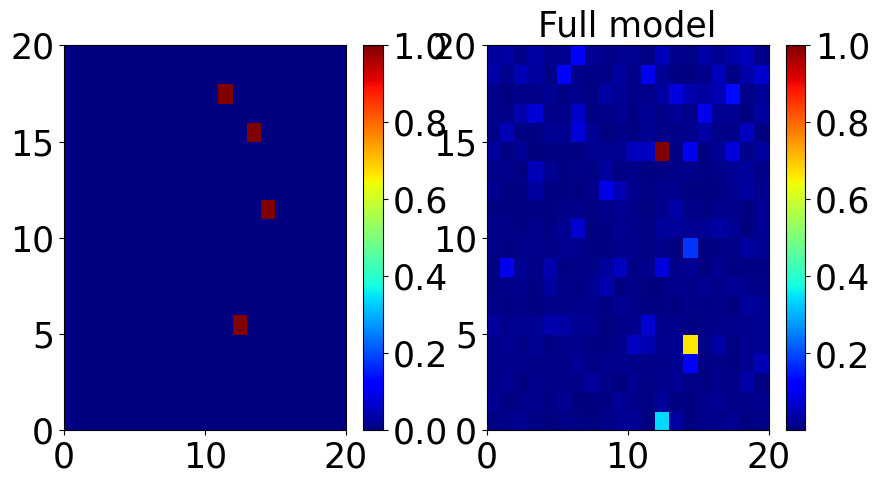

epoch: 600, train loss: 0.004438673349795863, L1 loss: 0, val loss: 0.017641769722104073, max avg inners: 0.9099649046327508, GELMA loss: -1, num indices: 234
epoch: 601, train loss: 0.004511773306876421, L1 loss: 0, val loss: 0.017615115270018578, max avg inners: 0.9100810590464858, GELMA loss: -1, num indices: 234
epoch: 602, train loss: 0.004557718918658793, L1 loss: 0, val loss: 0.017511388286948204, max avg inners: 0.9103503253948786, GELMA loss: -1, num indices: 235
epoch: 603, train loss: 0.004477237979881465, L1 loss: 0, val loss: 0.017510557547211647, max avg inners: 0.9104077114061074, GELMA loss: -1, num indices: 236
epoch: 604, train loss: 0.004437677020905539, L1 loss: 0, val loss: 0.017510268837213516, max avg inners: 0.9104951458013981, GELMA loss: -1, num indices: 235
epoch: 605, train loss: 0.0044875287683680655, L1 loss: 0, val loss: 0.017518017441034317, max avg inners: 0.9105842810393823, GELMA loss: -1, num indices: 236
epoch: 606, train loss: 0.004428087139967829,

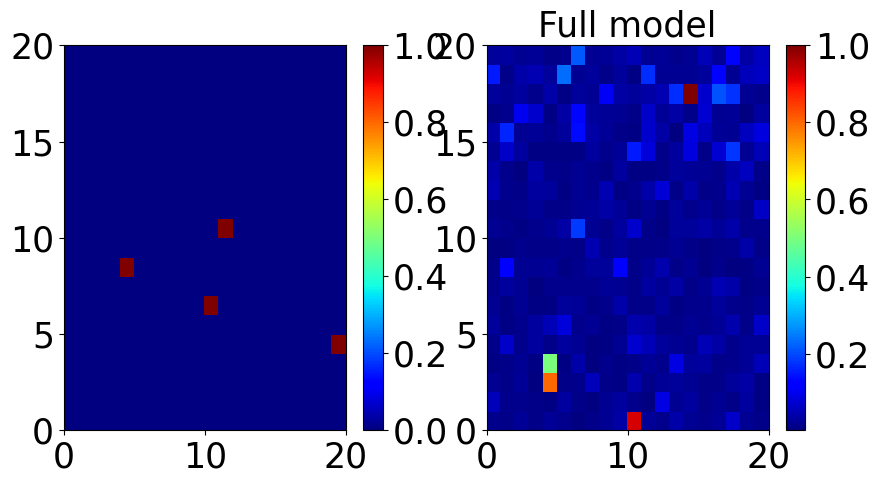

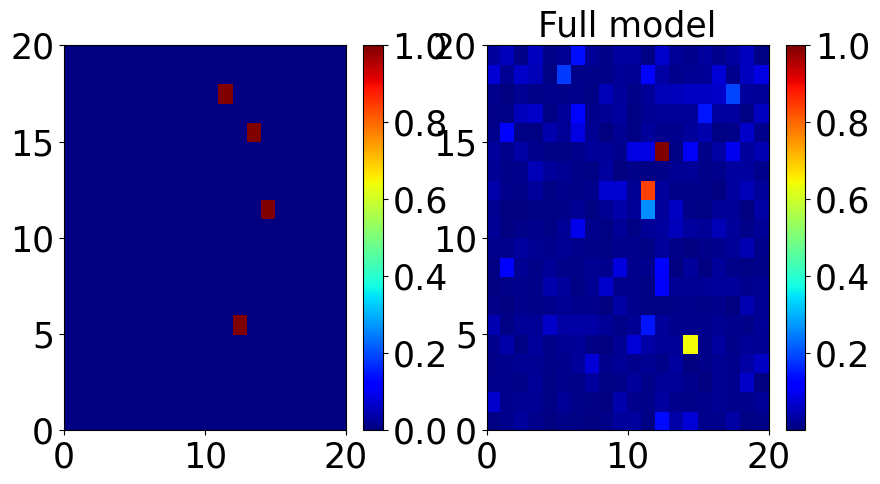

epoch: 650, train loss: 0.004467252071481199, L1 loss: 0, val loss: 0.017674637958407402, max avg inners: 0.9128170900493946, GELMA loss: -1, num indices: 238
epoch: 651, train loss: 0.004482868919149041, L1 loss: 0, val loss: 0.017666514962911606, max avg inners: 0.9128670415490256, GELMA loss: -1, num indices: 238
epoch: 652, train loss: 0.004438265139469877, L1 loss: 0, val loss: 0.017724348232150078, max avg inners: 0.9128661727777185, GELMA loss: -1, num indices: 238
epoch: 653, train loss: 0.004462027311092242, L1 loss: 0, val loss: 0.017667697742581367, max avg inners: 0.9130348320410482, GELMA loss: -1, num indices: 238
epoch: 654, train loss: 0.004423297580797226, L1 loss: 0, val loss: 0.01770416833460331, max avg inners: 0.91292503791195, GELMA loss: -1, num indices: 239
epoch: 655, train loss: 0.004421067447401584, L1 loss: 0, val loss: 0.01771198771893978, max avg inners: 0.9130049258743057, GELMA loss: -1, num indices: 238
epoch: 656, train loss: 0.0044205691490788014, L1 

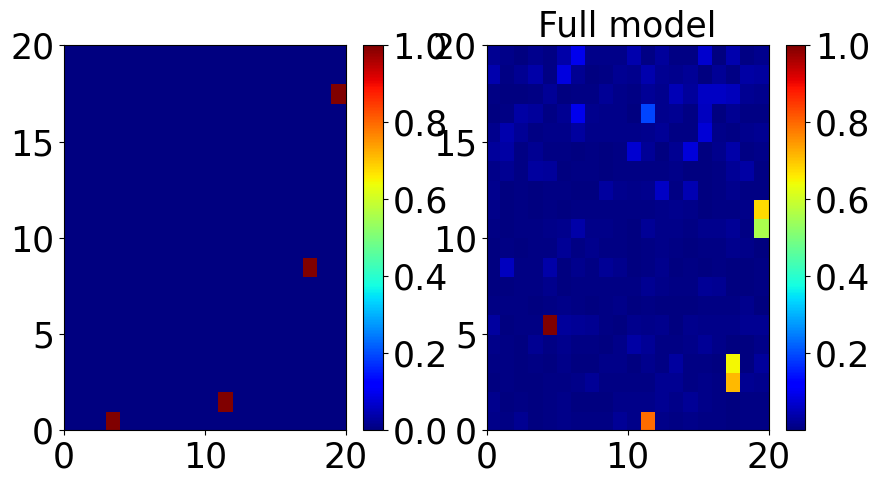

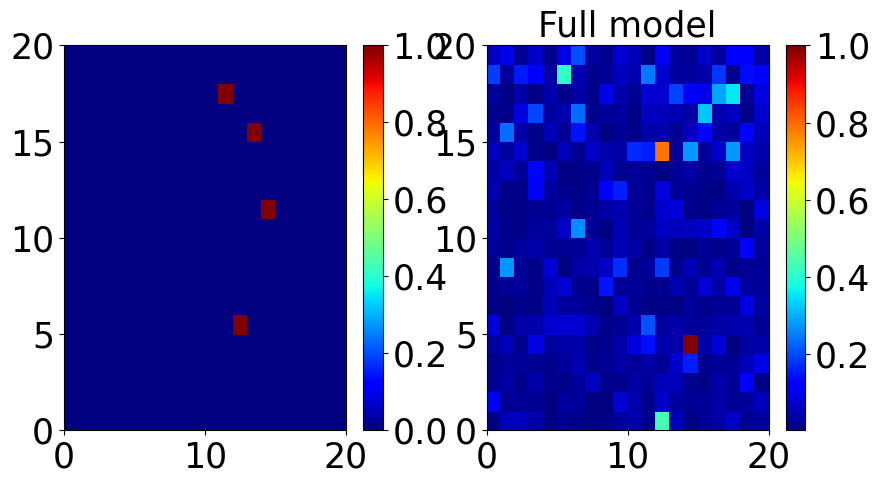

epoch: 700, train loss: 0.0044232540472876275, L1 loss: 0, val loss: 0.017822615802288055, max avg inners: 0.9154124790480513, GELMA loss: -1, num indices: 240
epoch: 701, train loss: 0.004390271205920726, L1 loss: 0, val loss: 0.01778244599699974, max avg inners: 0.9154285875049573, GELMA loss: -1, num indices: 239
epoch: 702, train loss: 0.004380286973901093, L1 loss: 0, val loss: 0.017817949876189232, max avg inners: 0.9154785912862716, GELMA loss: -1, num indices: 240
epoch: 703, train loss: 0.004392305709188804, L1 loss: 0, val loss: 0.01779458113014698, max avg inners: 0.9156071500800951, GELMA loss: -1, num indices: 239
epoch: 704, train loss: 0.004332999995676801, L1 loss: 0, val loss: 0.017790433019399643, max avg inners: 0.9156579223263748, GELMA loss: -1, num indices: 240
epoch: 705, train loss: 0.004369243455585092, L1 loss: 0, val loss: 0.017783045768737793, max avg inners: 0.9157644718919998, GELMA loss: -1, num indices: 240
epoch: 706, train loss: 0.004353956418344751, L

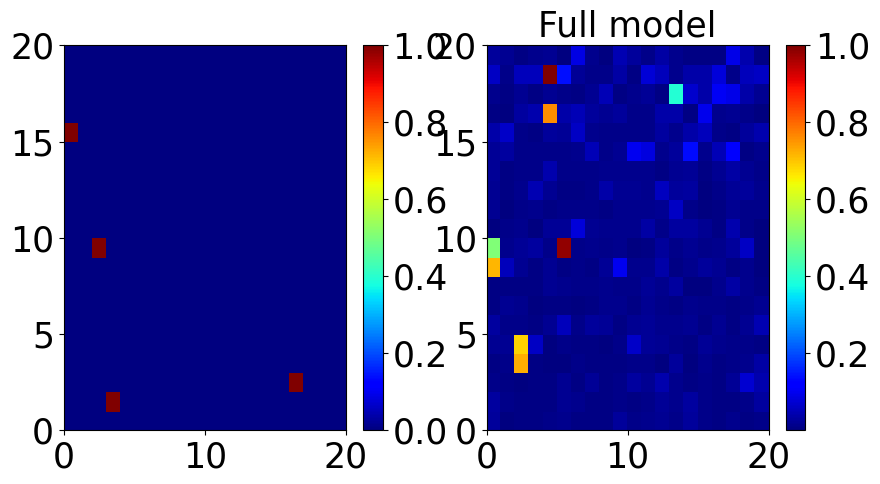

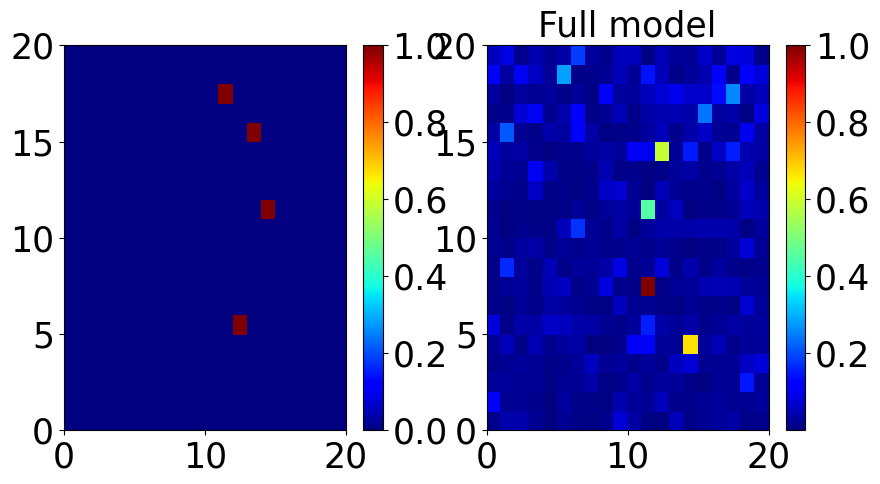

epoch: 750, train loss: 0.004347394092474134, L1 loss: 0, val loss: 0.017983943223953247, max avg inners: 0.9178728966385821, GELMA loss: -1, num indices: 246
epoch: 751, train loss: 0.004324354761047288, L1 loss: 0, val loss: 0.01789921708405018, max avg inners: 0.9179720580917642, GELMA loss: -1, num indices: 246
epoch: 752, train loss: 0.004346290329704062, L1 loss: 0, val loss: 0.017880883067846298, max avg inners: 0.9180913811320366, GELMA loss: -1, num indices: 247
epoch: 753, train loss: 0.004295692365849389, L1 loss: 0, val loss: 0.017918478697538376, max avg inners: 0.9181224081130013, GELMA loss: -1, num indices: 247
epoch: 754, train loss: 0.0043243851570878185, L1 loss: 0, val loss: 0.017956595867872238, max avg inners: 0.9181291560314166, GELMA loss: -1, num indices: 248
epoch: 755, train loss: 0.004311124415835366, L1 loss: 0, val loss: 0.01795787923038006, max avg inners: 0.9181699277126509, GELMA loss: -1, num indices: 249
epoch: 756, train loss: 0.00435657097841613, L1

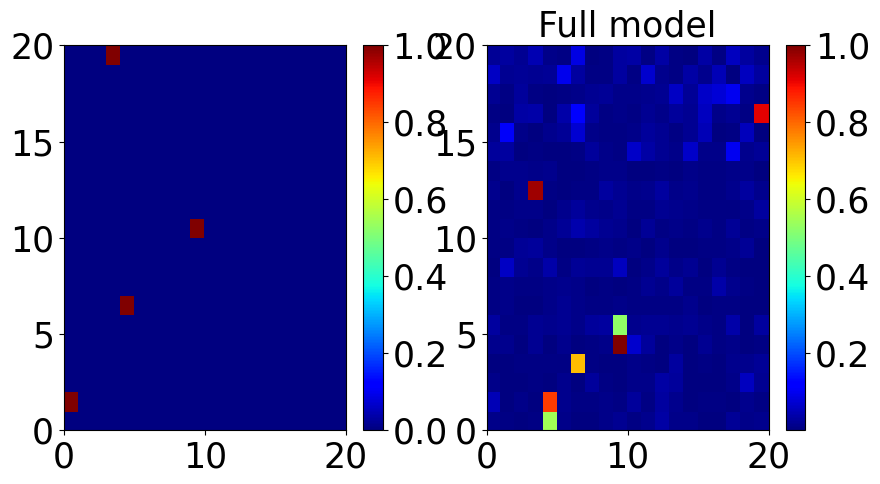

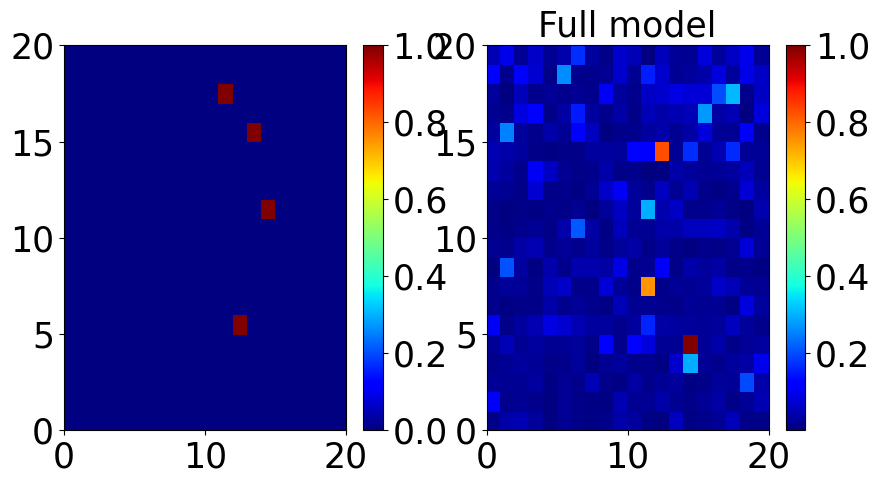

epoch: 800, train loss: 0.004308746691094711, L1 loss: 0, val loss: 0.018016057088971138, max avg inners: 0.9203228008222759, GELMA loss: -1, num indices: 250
epoch: 801, train loss: 0.004233439348172397, L1 loss: 0, val loss: 0.018005957826972008, max avg inners: 0.92030924662542, GELMA loss: -1, num indices: 250
epoch: 802, train loss: 0.004280683281831443, L1 loss: 0, val loss: 0.018032580614089966, max avg inners: 0.9203076225477461, GELMA loss: -1, num indices: 251
epoch: 803, train loss: 0.0042302679968997834, L1 loss: 0, val loss: 0.01803533360362053, max avg inners: 0.9202331593874145, GELMA loss: -1, num indices: 251
epoch: 804, train loss: 0.004245200968580321, L1 loss: 0, val loss: 0.018061377108097076, max avg inners: 0.920281467222458, GELMA loss: -1, num indices: 251
epoch: 805, train loss: 0.004272631369531155, L1 loss: 0, val loss: 0.01811787486076355, max avg inners: 0.9204492983554385, GELMA loss: -1, num indices: 251
epoch: 806, train loss: 0.004373576393118127, L1 l

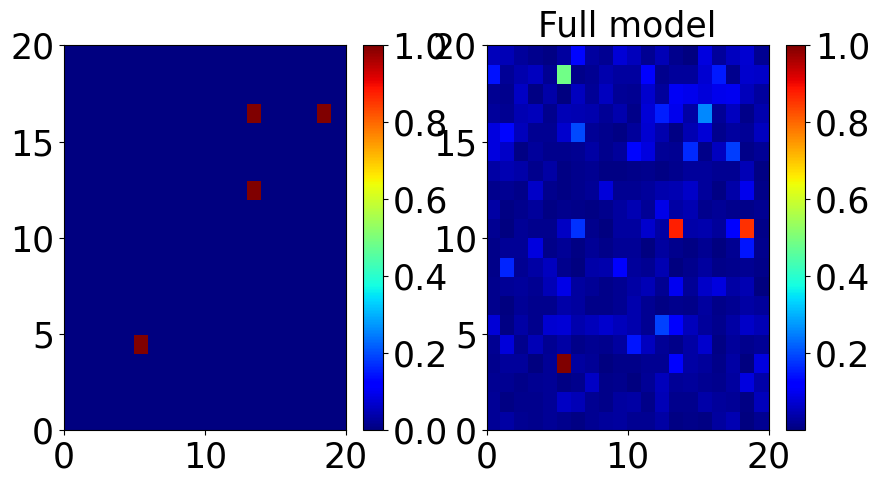

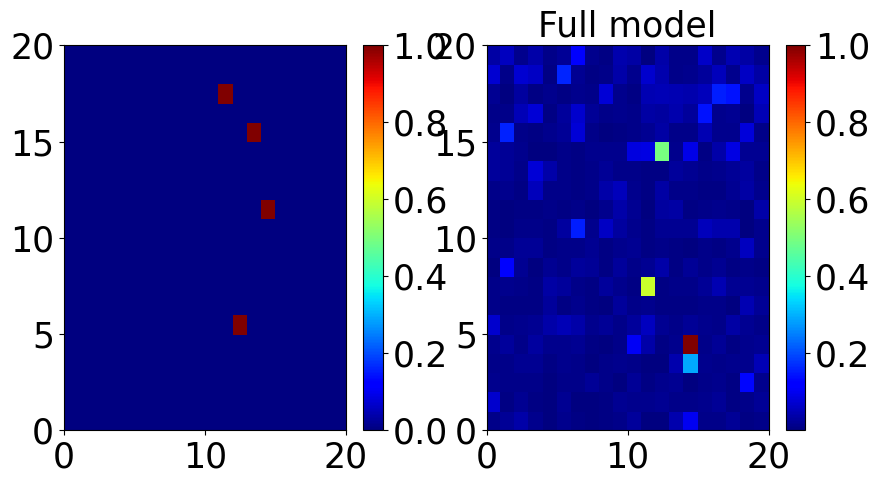

epoch: 850, train loss: 0.004283723060507326, L1 loss: 0, val loss: 0.01813615672290325, max avg inners: 0.9220315424499843, GELMA loss: -1, num indices: 255
epoch: 851, train loss: 0.004326584911905229, L1 loss: 0, val loss: 0.018316011875867844, max avg inners: 0.9221232465122184, GELMA loss: -1, num indices: 255
epoch: 852, train loss: 0.004334502952406184, L1 loss: 0, val loss: 0.018167560920119286, max avg inners: 0.9222364602484501, GELMA loss: -1, num indices: 255
epoch: 853, train loss: 0.004250903881620616, L1 loss: 0, val loss: 0.018119197338819504, max avg inners: 0.9222033855163467, GELMA loss: -1, num indices: 255
epoch: 854, train loss: 0.004220268147764727, L1 loss: 0, val loss: 0.01815268211066723, max avg inners: 0.9223127555563521, GELMA loss: -1, num indices: 255
epoch: 855, train loss: 0.004267767845885829, L1 loss: 0, val loss: 0.018172629177570343, max avg inners: 0.922268052635379, GELMA loss: -1, num indices: 255
epoch: 856, train loss: 0.00420988019905053, L1 l

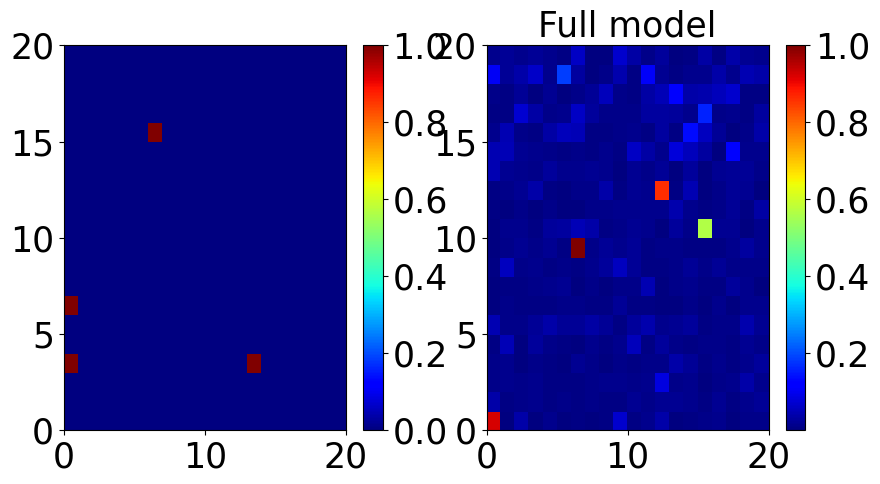

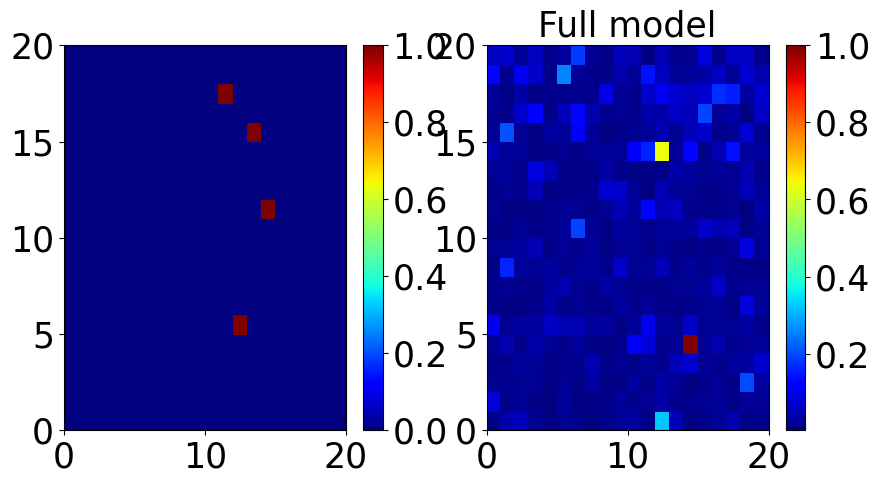

epoch: 900, train loss: 0.004284076613839716, L1 loss: 0, val loss: 0.01840948686003685, max avg inners: 0.9240523997226988, GELMA loss: -1, num indices: 258
epoch: 901, train loss: 0.004435265663778409, L1 loss: 0, val loss: 0.01841316930949688, max avg inners: 0.9240443852308755, GELMA loss: -1, num indices: 259
epoch: 902, train loss: 0.004426989541389048, L1 loss: 0, val loss: 0.018451277166604996, max avg inners: 0.9240547779172017, GELMA loss: -1, num indices: 258
epoch: 903, train loss: 0.004316183313494548, L1 loss: 0, val loss: 0.01828373782336712, max avg inners: 0.9242856451765833, GELMA loss: -1, num indices: 258
epoch: 904, train loss: 0.004287914303131402, L1 loss: 0, val loss: 0.018256543204188347, max avg inners: 0.9242497506272376, GELMA loss: -1, num indices: 258
epoch: 905, train loss: 0.004306164459558203, L1 loss: 0, val loss: 0.01828210987150669, max avg inners: 0.9242707095736109, GELMA loss: -1, num indices: 257
epoch: 906, train loss: 0.004252934083342552, L1 l

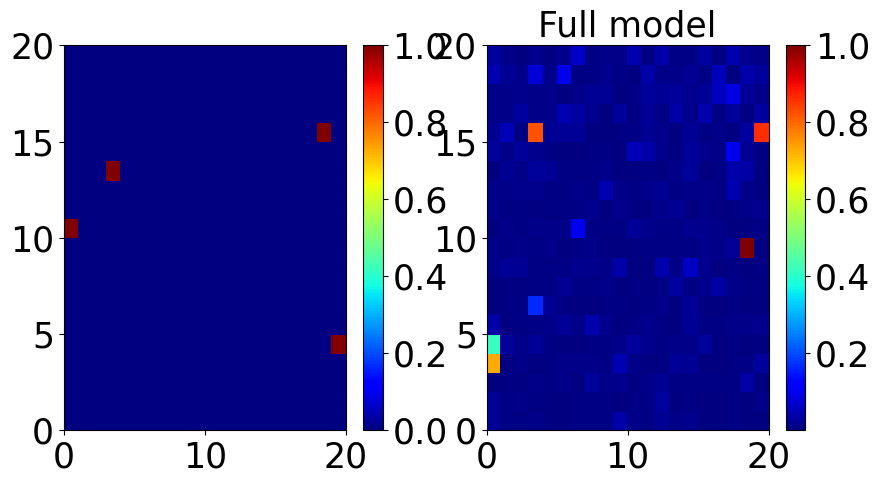

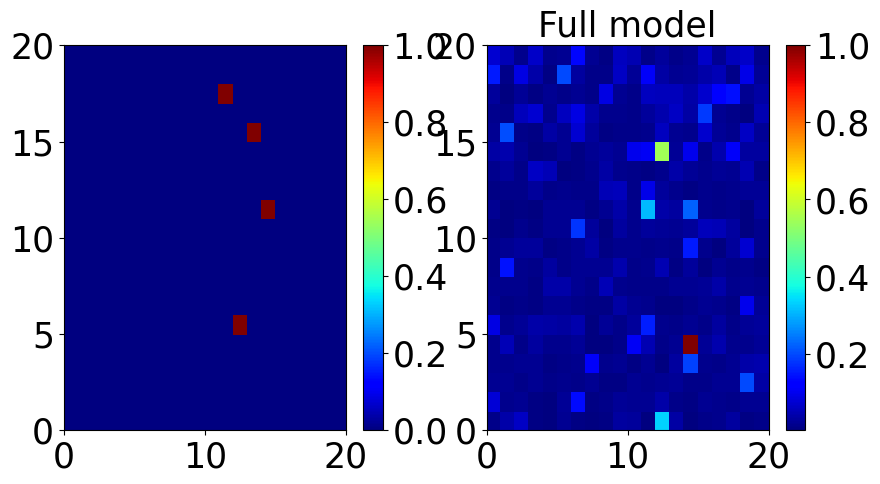

epoch: 950, train loss: 0.004236077435780317, L1 loss: 0, val loss: 0.018468229100108147, max avg inners: 0.9254876020023631, GELMA loss: -1, num indices: 262
epoch: 951, train loss: 0.0042578964726999406, L1 loss: 0, val loss: 0.018501918762922287, max avg inners: 0.9254796033807388, GELMA loss: -1, num indices: 262
epoch: 952, train loss: 0.004203128552762792, L1 loss: 0, val loss: 0.018460815772414207, max avg inners: 0.9255042913714217, GELMA loss: -1, num indices: 263
epoch: 953, train loss: 0.004226085101254285, L1 loss: 0, val loss: 0.01846073940396309, max avg inners: 0.9254810655670228, GELMA loss: -1, num indices: 263
epoch: 954, train loss: 0.004204157792264595, L1 loss: 0, val loss: 0.018441833555698395, max avg inners: 0.9256056929622037, GELMA loss: -1, num indices: 263
epoch: 955, train loss: 0.00425311015569605, L1 loss: 0, val loss: 0.018454894423484802, max avg inners: 0.9255549329518753, GELMA loss: -1, num indices: 262
epoch: 956, train loss: 0.004225884837796912, L

NameError: name 'index_list_list' is not defined

In [6]:
#Raw data visualization of recovered columns
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
L1_weight=0
THRESH_HOLD_VAL=.01
layers=[512]*10
#[500,500,500,300,300,400,800]#[3000,1000,500,300,300,300,300,300,300,300,300,300,300,300]#[3000,1500,1000,500,500,500,300,300,300,400,400,800]#[1000,1000,1000,500,500,500,300,300,300,400,400,400,800]
GELMA_layers=layers#[500,500,500,300,300,400,800]
CE=False
KM_in=False
INV_weight=0
RESHUFFLE=False
LR=1e-3
GELMA=0
TIME_reverse=False
E_list=0
RESETS=0
GELMA_MAX=.5
GELMA_inc=0
G_0=True
Epochs=1000
index_list=[]
GELMA_MAX=.5
GELMA_inc=0
#index_list_list=[]

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='89a70fbc572a495206df640bd6c9cbf2a4a0dcaa' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['unlabeled_data']=unlabeled_data 
    wandb.config['L1_weight']=L1_weight
    wandb.config['layers']=layers
    wandb.config['GELMA']=GELMA
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, normalize=True)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2

for i in range(5):
    encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)
    #decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    #decoder=M.fc_net_extra(outdim, layers[::-1], indim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
    if G_0:
        G_0_w=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
        G_0_w=torch.cat((torch.tensor(G_0_w.real), torch.tensor(G_0_w.imag)), dim=0)
        G_0_w=G_0_w.float()
        decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
        Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1)
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        print(f'G_0 initialization successful: {torch.allclose(medium_hat, G_0_w.T)}')


    print(H.count_parameters(encoder))
    print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
    encoder.to(device)
    decoder.to(device)
    relu=nn.ReLU()
    leaky_relu=nn.LeakyReLU(THRESH_HOLD_VAL)
    optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
    optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)


    tanh=nn.Tanh()
    softmax=nn.Softmax(dim=1)
    bce_loss_fn=nn.BCELoss() 
    Threshold=nn.Threshold(THRESH_HOLD_VAL, 0)  
    L2_loss_fn=nn.MSELoss()
    CE_loss_fn=nn.CrossEntropyLoss()
    L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
    L1_loss_fn=nn.L1Loss()
    Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
    softmax=nn.Softmax(dim=1)
    if GELMA>0:
        GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None, dropout=.5)
        optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=LR, maximize=True)
        GELMA_net.to(device)
        GELMA_net=nn.DataParallel(GELMA_net)
        GELMA_net.train()
    def f_col(batch):
        b=torch.stack([item[0] for item in batch])
        rho=torch.stack([item[1] for item in batch])
        num_targets=torch.stack([item[2] for item in batch])
        return b.to(device), rho.to(device), num_targets


    def rescale_rho(z):
        minimum, _=torch.min(z, -1, keepdim=True)
        maxium, _=torch.max(z, -1,   keepdim=True)
        z=(z-minimum)/(maxium-minimum)
        return z
    lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
    lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
    trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
    if E_list>0:
        encs=[M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5) for i in range(E_list)]
        opts=[torch.optim.AdamW(enc.parameters(), lr=LR) for enc in encs]
        for enc in encs:
            enc.to(device)
    for epoch in range(Epochs):
        if RESETS>0 and epoch%RESETS==0:
            decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
            if G_0:
                G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
                G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
                G_0_w=G_0_w.float()
                decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
                decoder.to(device)
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
            optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
            optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)
        train_lossavg=0
        train_lossavg=0
        L1_loss_avg=0
        coupled_grad=0
        project_grad=0

        inner_loss_term_avg=0
        for batch, (b, rho, num_targets) in enumerate(trainloader):
            if True:
                b=b.to(device)
                rho=rho.to(device)
                optimizer.zero_grad()
                optimizer_decod.zero_grad()
                if E_list>0:
                    for enc in encs:
                        enc.zero_grad()
                if KM_in:
                    medium_hat=decoder(Complex_eye).squeeze()
                    medium_hat=F.normalize(medium_hat, dim=-1)
                    Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                    Mhat_imag=-Mhat_imag
                    b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                    km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                    km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                    km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                    In_put=torch.cat((b, km_b), dim=-1)

                    rho_hat=encoder(In_put)
                elif TIME_reverse:
                    rho_hat=encoder(decoder.time_reverse(b.squeeze()))
                else:
                    rho_hat=encoder(b)

                if E_list>0:
                    rho_hats=[enc(b) for enc in encs]
                    rho_hats=[relu(rho_hat) for rho_hat in rho_hats]
                    for rho_hat_l in rho_hats:
                        max_rho_l, _=torch.max(rho_hat_l, dim=-1, keepdim=True)
                        rho_hat_l=rho_hat_l/max_rho_l

                    b_hats=[decoder(rho_hat_l) for rho_hat_l in rho_hats]
                    L2_loss=sum([L2_loss_fn(b_hat_l.squeeze(), b.squeeze()) for b_hat_l in b_hats])/len(b_hats)
                    L2_loss.backward()
                    for opt in opts:
                        opt.step()
                #rho_hat=sigmoid(rho_hat)
                #rho_hat=softmax(rho_hat)
                #rho_hat=relu(rho_hat)
                rho_hat=leaky_relu(rho_hat)
                max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
                rho_hat=abs(rho_hat)/max_rho
                #rho_hat=rescale_rho(rho_hat)
                #rho_hat=Threshold(abs(rho_hat))
                #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
                #rho_hat=rho_hat/max_rho
                #rho_hat=tanh(rho_hat)

                

                b_hat=decoder(rho_hat)
                if INV_weight>0:
                    medium_hat=decoder(Complex_eye).squeeze()
                    medium_hat=F.normalize(medium_hat, dim=-1)
                    b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                    Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                    complex_mat=Mhat_real+1j*Mhat_imag
                    #print(f'og complex mat shape: {complex_mat.shape}')
                    complex_mat=complex_mat.T #yes
                    complex_mat=torch.linalg.pinv(complex_mat.T.conj()@complex_mat, hermitian=True)@complex_mat.T.conj()  
                    complex_b=b_real+1j*b_imag
                    complex_b=complex_b.T
                    #print(complex_mat.shape, complex_b.shape)

                    rho_inv=complex_mat@complex_b
                    rho_inv=rho_inv.T
                    rho_inv_real=rho_inv.real
                    rho_inv_imag=rho_inv.imag
                    INV_loss=L2_loss_fn(rho_inv_real, rho_hat)*INV_weight
                    INV_loss.backward(retain_graph=True)
                    INV_loss=INV_loss.item()/INV_weight
                    


                    
                    
                    




                if L1_weight>0:
                    L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                    L1_loss.backward(retain_graph=True)  
                    L1_loss_avg+=L1_loss.item()/L1_weight/len(trainloader)
                else:
                    L1_loss=-1

                if CE>0:
                    rho_hat_hat=encoder(b_hat)

                    CEloss=CE_loss_fn(rho_hat_hat, rho_hat)*CE
                    CEloss.backward(retain_graph=True)
                    CEloss=CEloss.item()/CE

                
                
                L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
                L2_loss.backward(retain_graph=True)





                
                optimizer.step()
                optimizer_decod.step()
                train_lossavg+=L2_loss.item()/len(trainloader)


                if GELMA>0 and epoch>0:
                    optimizer_GELMA.zero_grad()
                    optimizer.zero_grad()
                    optimizer_decod.zero_grad()
                    
                    GELMA_out=GELMA_net(b).squeeze()
                    GELMA_out=F.normalize(GELMA_out, dim=-1).squeeze()
                    b_hat=b_hat.squeeze()

                    GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                    #GELMA_inners_coupled=sum(GELMA_inners_coupled**2)**(1/2)/(torch.numel(GELMA_inners_coupled))
                    GELMA_inners_project=(torch.inner((b).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                    #GELMA_inners_project=sum(GELMA_inners_project)/(torch.numel(GELMA_inners_project))
                    GELMA_Inners=L2_loss_fn((GELMA_inners_project+GELMA_inners_coupled),0*(GELMA_inners_project+GELMA_inners_coupled))
                    GELMA_Inners.backward(retain_graph=True)
                    
                    
                    optimizer_GELMA.step()
                    optimizer_GELMA.zero_grad()



                    inner_loss_term_avg+=(GELMA_Inners).item()/len(trainloader)
                    optimizer.zero_grad()
                    optimizer_decod.zero_grad()
                    GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))

                    GELMA_inners_coupled=GELMA*L2_loss_fn(GELMA_inners_coupled,0*GELMA_inners_coupled)
                    GELMA_inners_coupled.backward()
                    optimizer.step()
                    optimizer_decod.step()

                
                else:
                    inner_loss_term_avg=-1

        #if L1_loss>5e-5:
        #    L1_weight=L1_weight*(0.9)
        val_lossavg=0
        if epoch%50==0:
            H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        encoder.eval()
        decoder.eval()
        if GELMA_inc>0 and GELMA<GELMA_MAX:
            GELMA=GELMA*GELMA_inc
            if GELMA>GELMA_MAX:
                GELMA=GELMA_MAX
                print('GELMA max reached')

        if INV_weight>0 and INV_weight<1e-1:
            INV_weight=INV_weight*(1.03)


        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        font_size = 50
        if KM_in:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            Mhat_imag=-Mhat_imag
            b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
            
        # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
            In_put=torch.cat((b_val, km_b), dim=-1)

            rho_hat=encoder(In_put)
        else:
            rho_hat=encoder(b_val)
        #rho_hat=sigmoid(rho_hat)
        #rho_hat=relu(rho_hat)
        rho_hat=leaky_relu(rho_hat)
        max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
        rho_hat=abs(rho_hat)/max_rho
        #rho_hat=softmax(rho_hat)
        #rho_hat=rescale_rho(rho_hat)
        #rho_hat=Threshold(abs(rho_hat))
        #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
        #rho_hat=rho_hat/max_rho
        #rho_hat=tanh(rho_hat)

        b_hat=decoder(rho_hat) 
        L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
        val_lossavg+=L2_loss.item()





    
    
    
        if epoch%50==0:
            H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        
        if epoch%1==0:
            sum_max_inner_original=0
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            medium_hat=medium_hat.cpu().detach().numpy()
            medium_hat=H.cat2complex(medium_hat)                    
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                    #original way of computing inners
                    # mean over true max over hats
            index_list=[]
            for i in range(int(outdim*2)):
                if max(torch_inners[:, i])>.95 and i not in index_list:
                    index_list.append(i)
                sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
    
            
            #lr_scheduler_enc.step()
            #lr_scheduler_decod.step()
            
            
            print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
            #print(f'coupled grad: {coupled_grad}, project grad: {project_grad}')
            wand_dict['train loss']=train_lossavg
            wand_dict['val loss']=val_lossavg
            if L1_loss>0:
                wand_dict['L1 loss']=L1_loss
            if GELMA>0:
                wand_dict['GELMA loss']=inner_loss_term_avg

        
            wand_dict['max avg inners']=max_avg_inners_original
        if Track_run:
            wandb.log(wand_dict)

    #index_list_list.append(index_list)
    print(time.time()-starttime)
    if Track_run:
        wandb.finish()
    index_list_list.append(index_list)



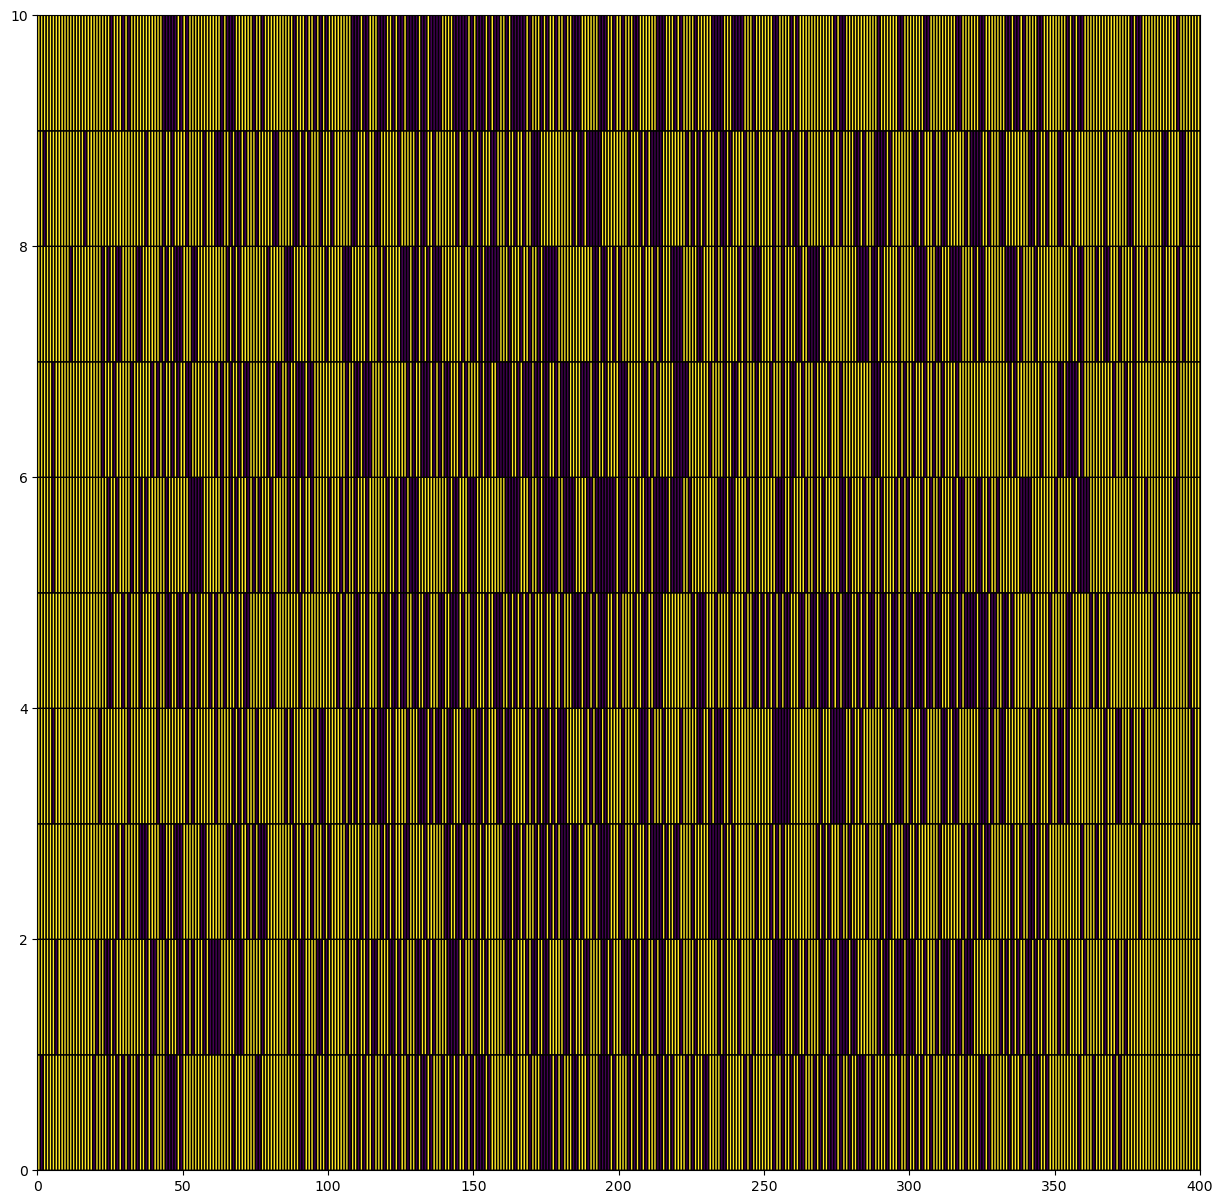

In [34]:
index_list_filled=[]

for j in index_list_list:
    filled=[]
    for i in range(400):
        if i in j:
            filled.append(1)
        else:
            filled.append(0)
    index_list_filled.append(filled)
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(15,15))

ax=axes
#col=ax.pcolor(index_list_filled)

col = ax.pcolor(index_list_filled, edgecolors='k', linewidths=1)
#cbar=plt.colorbar(col, ax=ax)

plt.show()



In [30]:
num_targets=0
for rhohh in rho_hat:
    num_targets+=torch.sum(rhohh>1e-10)
num_targets/len(rho_hat)
stupid=rho_hat[0].detach().cpu().numpy()
sorted_stupid=sorted(stupid)
sorted_stupid[-10:]




[0.31614658,
 0.3364148,
 0.33814406,
 0.36041665,
 0.3971138,
 0.4384456,
 0.44925255,
 0.64228934,
 0.9173248,
 1.0]

In [35]:
super_list=[j for i in index_list_list for j in i]
super_list=list(set(super_list))
len(super_list)


###TRY threshholding the rho_hat to top 4
#AFTER running exp 5 times, can i cluster them into 400 clusters?


#Very good statement. IT says: 'no need to be smart, just increase network'
#The advatnage is we simultanrously need more data, but can still be stupid/just use 'More parameters'
#We have a simple protocol for everyone. Just 

###Foldy lox, she takses steves algo runs it and steves algo feeds her 500 (1.25*K, K=400) vectors. She just takes the top 400 and uses the initialization.



400

In [ ]:
#Raw data training unlabeled no batching
starttime=time.time()
target='raw'
unlabeled_data=4000
batchsize=128
L1_weight=1e-15
layers=[5000,5000,5000,3000,3000,1400,800]
#layers.append(256),0
GELMA_layers=[500,500,500,300,300,400,800]
CE=False
KM_in=False
#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2


encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    #GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
b_train=training_data.b.to(device)
rho_train=training_data.rho.to(device)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    if True:
        b=b_train
        rho=rho_train
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        if KM_in:
            medium_hat=decoder(Complex_eye).squeeze()
            medium_hat=F.normalize(medium_hat, dim=-1)
            Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
            Mhat_imag=-Mhat_imag
            b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
            km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
            km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

            km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
            
        # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
            In_put=torch.cat((b, km_b), dim=-1)

            rho_hat=encoder(In_put)
        else:
            rho_hat=encoder(b)
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        if CE:
            rho_hat_hat=encoder(b_hat)

            CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
            CEloss.backward(retain_graph=True)
            CEloss=CEloss.item()

        
        if GELMA>0 and epoch>100:
            optimizer_GELMA.zero_grad()
            GELMA_out=GELMA_net(b)
            GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
            inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
            inner_loss_term.backward(retain_graph=True)
            inner_loss_term_avg=inner_loss_term.item()/GELMA
            optimizer_GELMA.step()
            
        else:
            inner_loss_term_avg=-1
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    #if epoch%10000==0:
    #   H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


In [ ]:
#Raw data training variational autoencoder (KL replcaed with BCE)
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
layers=[500,500,500,300,300,300,400,800]
G_0=False
Epochs=10000
index_list=[]
KL_weight=1
L1_weight=1e-3

Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=512
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)

encoder=M.variational_enc(training_data.b[0].shape[0]/2, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.fc_net_extra(outdim, [layers[len(layers)-i-1] for i in range(len(layers))],training_data.b[0].shape[0]/2 , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
L1_loss_fn=nn.L1Loss()
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)

lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    encoder.train()
    decoder.train()
    KL_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)

        optimizer.zero_grad()
        optimizer_decod.zero_grad()

        rho_hat_mean, rho_hat_logvar=encoder(b)
        rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
        KLloss=H.KL_divergence(rho_hat_mean, rho_hat_logvar)*KL_weight
        KLloss.backward(retain_graph=True)
        #rho_hat=sigmoid(rho_hat)

        if L1_weight>0:
            L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
            L1_loss.backward(retain_graph=True)  
            L1_loss=L1_loss.item()/L1_weight
        else:
            L1_loss=-1

        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        optimizer_decod.step()
        train_lossavg+=L2_loss.item()/len(trainloader)
        KL_lossavg+=KLloss.item()/len(trainloader)/KL_weight
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat_mean, rho_hat_logvar=encoder(b_val)
    rho_hat=rho_hat_mean+torch.randn_like(rho_hat_logvar)* torch.exp(0.5*rho_hat_logvar)
    #rho_hat=softmax(rho_hat)
    #rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        #Complex_eye=Complex_eye+
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, KL_LOSS: {KL_lossavg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original},  num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
1443504
Data shapes: 1450.0 200.0


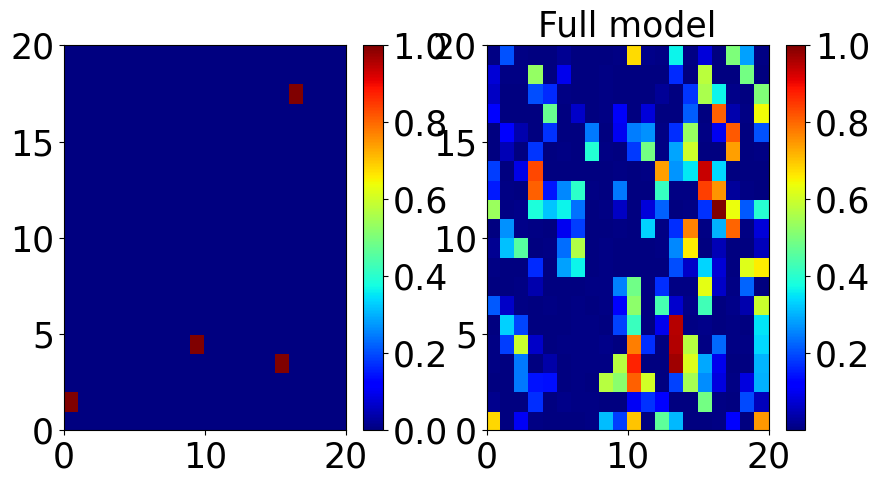

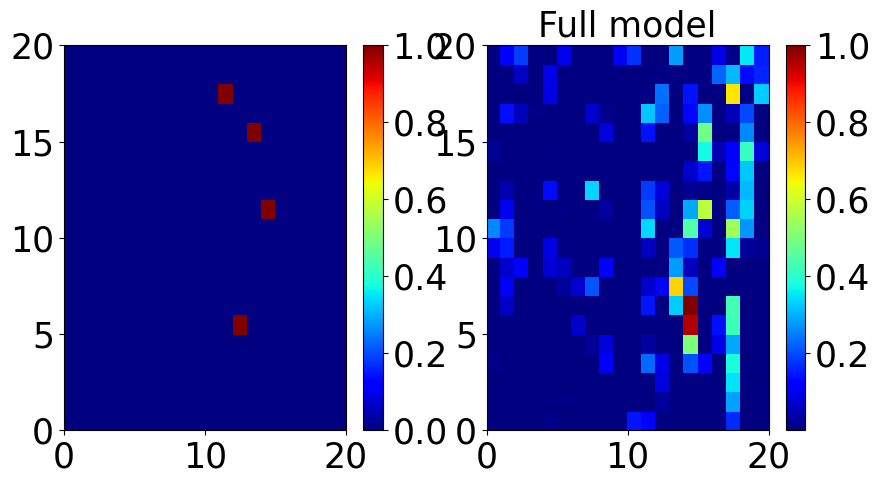

epoch: 0, Encoder train loss: 0.023565415558405224, Decoder train loss: 0.01828765334095806 L1 loss: 0.0, val loss: 0.019556421786546707, max avg inners: 0.4106163380722083, GELMA loss: -0.025, num indices: 0
epoch: 1, Encoder train loss: 0.017231228672899317, Decoder train loss: 0.015566955464892104 L1 loss: 0.0, val loss: 0.01817425712943077, max avg inners: 0.4083732344727594, GELMA loss: -0.025, num indices: 0
epoch: 2, Encoder train loss: 0.015223065649624909, Decoder train loss: 0.014216335716191682 L1 loss: 0.0, val loss: 0.017702864482998848, max avg inners: 0.4173661949090475, GELMA loss: -0.025, num indices: 0
epoch: 3, Encoder train loss: 0.014085013961885117, Decoder train loss: 0.013353442328516391 L1 loss: 0.0, val loss: 0.017497282475233078, max avg inners: 0.425710681000248, GELMA loss: -0.025, num indices: 0
epoch: 4, Encoder train loss: 0.013342573670670396, Decoder train loss: 0.012689744688104843 L1 loss: 0.0, val loss: 0.017305925488471985, max avg inners: 0.444980

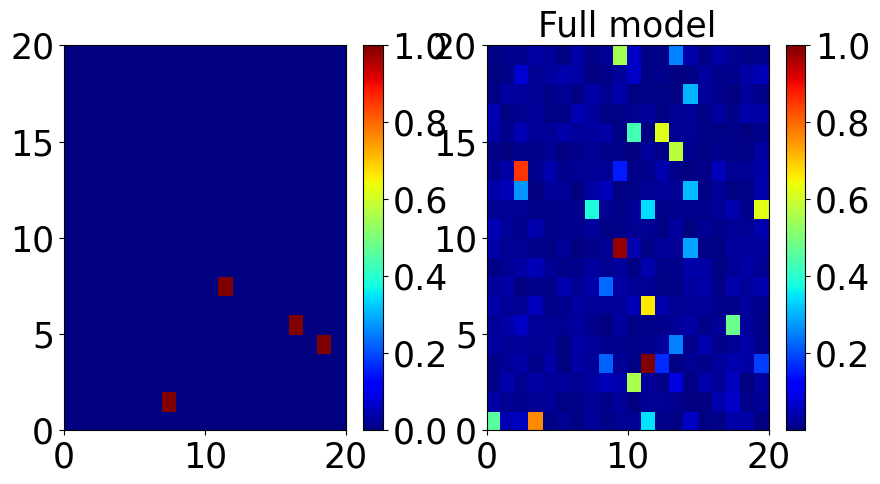

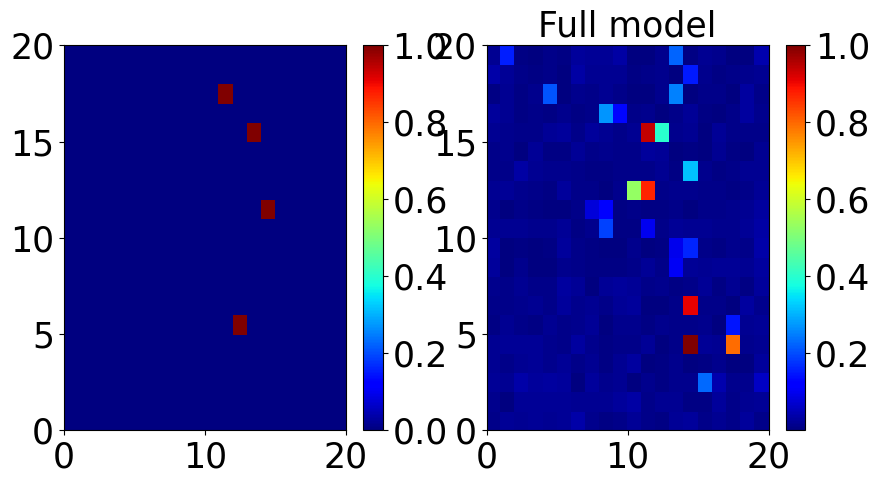

epoch: 50, Encoder train loss: 0.005181140759959813, Decoder train loss: 0.004949148598825557 L1 loss: 0.0, val loss: 0.014578793197870255, max avg inners: 0.6265012563949228, GELMA loss: -0.025, num indices: 28
epoch: 51, Encoder train loss: 0.005151559035293753, Decoder train loss: 0.004862005556933583 L1 loss: 0.0, val loss: 0.014482373371720314, max avg inners: 0.6279539689924657, GELMA loss: -0.025, num indices: 28
epoch: 52, Encoder train loss: 0.005132727129384871, Decoder train loss: 0.00487001842819154 L1 loss: 0.0, val loss: 0.014463216997683048, max avg inners: 0.6279013335628164, GELMA loss: -0.025, num indices: 27
epoch: 53, Encoder train loss: 0.005097154375398531, Decoder train loss: 0.004891866758698596 L1 loss: 0.0, val loss: 0.01445801556110382, max avg inners: 0.6268177916242689, GELMA loss: -0.025, num indices: 27
epoch: 54, Encoder train loss: 0.005109167711343619, Decoder train loss: 0.004816176670137793 L1 loss: 0.0, val loss: 0.014402843080461025, max avg inners

KeyboardInterrupt: 

In [21]:
#Raw data training unlabeled only. Encoder decoder alternation
starttime=time.time()
target='raw'
unlabeled_data=5000
L1_weight=0
GELMA=0
G_0=True
Epochs=10000
layers=[128]*10
GELMA_layers=layers
batchsize=128
ITERS=10
LR=1e-3


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}

training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, normalize=True)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
b=training_data.b.to(device)
rho=training_data.rho.to(device)
rh_t, _=torch.split(rho, 400, dim=-1)


#val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)


encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=0)
#decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}

if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
leaky_relu=nn.LeakyReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)
optimizer_decod = torch.optim.Adam(decoder.parameters(), lr=min(LR*(10**3), 1e-3))
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)

if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=LR, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()


for epoch in range(Epochs):
    encoder.train()
    decoder.train()
    train_lossavg=0
    train_lossavg=0
    train_lossavg_decoder=0
    inner_loss_term_avg=0
    L1_loss_avg=0
    for param in encoder.parameters():
        param.requires_grad = True
    for i in range(ITERS):
        for batch, (b, rho, num_targets) in enumerate(trainloader):
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()


            font_size = 50
            rho_hat=encoder(b)

            #rho_hat=sigmoid(rho_hat)
            #rho_hat=relu(rho_hat)
            rho_hat=leaky_relu(rho_hat)
            max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            rho_hat=rho_hat/max_rho
            #rho_hat=softmax(rho_hat)
            #rho_hat=rescale_rho(rho_hat)
            #rho_hat=Threshold(abs(rho_hat))
            #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            #rho_hat=rho_hat/max_rho
            #rho_hat=tanh(rho_hat)

            b_hat=decoder(rho_hat)
            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss_avg+=L1_loss.item()/L1_weight/ITERS
                #if L1_loss>5e-15:
                    #L1_weight=L1_weight*0.999
            else:
                L1_loss=-1

            if GELMA>0 and epoch>0:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b).squeeze()
                GELMA_out=F.normalize(GELMA_out, dim=-1).squeeze()
                b_hat=b_hat.squeeze()
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/(torch.numel(GELMA_inners))
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg+=inner_loss_term.item()/GELMA/ITERS
                optimizer_GELMA.step()
            
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


        
            optimizer.step()
            train_lossavg+=L2_loss.item()/ITERS
    for param in encoder.parameters():
        param.requires_grad = False


    for i in range(ITERS):
        for batch, (b, rho, num_targets) in enumerate(trainloader):

            optimizer.zero_grad()
            optimizer_decod.zero_grad()

            font_size = 50
            rho_hat=encoder(b)


            #rho_hat=sigmoid(rho_hat)
            #rho_hat=relu(rho_hat)
            rho_hat=leaky_relu(rho_hat)
            max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            rho_hat=rho_hat/max_rho
            #rho_hat=softmax(rho_hat)
            #rho_hat=rescale_rho(rho_hat)
            #rho_hat=Threshold(abs(rho_hat))
            #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            #rho_hat=rho_hat/max_rho
            #rho_hat=tanh(rho_hat)


            b_hat=decoder(rho_hat)


            
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()



            optimizer_decod.step()
            train_lossavg_decoder+=L2_loss.item()/ITERS
        
    
    val_lossavg=0
    if epoch%50==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    rho_hat=encoder(b_val)


    #rho_hat=sigmoid(rho_hat)
    #rho_hat=relu(rho_hat)
    rho_hat=leaky_relu(rho_hat)
    max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
    rho_hat=rho_hat/max_rho
    #rho_hat=softmax(rho_hat)
    #rho_hat=rescale_rho(rho_hat)
    #rho_hat=Threshold(abs(rho_hat))
    #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
    #rho_hat=rho_hat/max_rho
    #rho_hat=tanh(rho_hat)

    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%50==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
            index_of_max=np.argmax(torch_inners[:,i])
            torch_inners[:,index_of_max]=0*torch_inners[index_of_max,:]
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
    index_list=[]
    for i in range(int(outdim*2)):
        if max(torch_inners[:, i])>.95 and i not in index_list:
            index_list.append(i)
        
        
    print(f'epoch: {epoch}, Encoder train loss: {train_lossavg/len(trainloader)}, Decoder train loss: {train_lossavg_decoder/len(trainloader)} L1 loss: {L1_loss_avg/len(trainloader)}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg/len(trainloader)}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)


if Track_run:
    wandb.finish()


In [ ]:
#cc data training
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

labeled_data=400
layer_loss_list=[]
Epochs=3000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)



encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

if torch.allclose(b_train, b_val):
    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.CrossEntropyLoss()   
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    bce_loss.backward() 
    train_lossavg+=bce_loss.item()
    accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    val_loss+=bce_loss.item()
    accuracy_val=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()
    if epoch%1000==0:
        H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, xpix=20, ypix=20, font_size=25)
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}, train accuracy: {accuracy_train}, val accuracy: {accuracy_val}')


torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt')

wand_dict['val loss']=val_loss
print(f'val loss: {val_loss}')
if Track_run:
    wandb.log(wand_dict)


In [ ]:
#loads orderer network, 'orderer' saved Decoder model located at 'locat'. Then reorderes the decoder columns into
#the variable 'G_hat_permed'. Reordering is done by placing the column with the highest probability into the correct predicted position.
#this is repeated until the entire matrix is reordered.
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_lowcow.pt'
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net_highcow.pt'
#save_lcation:"/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)"
orderer.load_state_dict(torch.load(Locat_orderer))

layers=[500,500, 500, 300, 300, 400,800]
training_data=H.data_rho_loaded(data_path+'/train',labeled_data/80000)
decoder=nn.Linear(400,training_data[0][0].shape[0], bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_long_bigdata/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_30-May-2024 (23:10:16)decoder.pt' #.61 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (23:10:30)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (21:26:12)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (23:29:19)decoder.pt' #.92 random init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init


decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
print(cc_medium.shape)
Perm=orderer(cc_medium)

softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
T=[]
print(Perm.shape)
for i in range(len(Perm)):
    largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    Perm[:,indices_1[overall_max_index]]=0


print(G_hat_permed.shape, medium_hat.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 12124.0 400.0
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(12124,) (400, 12124)
torch.Size([400, 24248])
torch.Size([400, 400])
(400, 1450) (400, 1450)
0.9954802301497007


In [ ]:
#function doing above
def reorder_step(medium_hat):
    
    cc_medium=[]
    for i in range(len(medium_hat)):
        outer=np.outer(medium_hat[i],medium_hat[i].conj())
        outer=outer[abs(Mask)>0]
        outer=outer.ravel()
        cc_medium.append(outer)

    cc_medium=np.array(cc_medium)
    print(outer.shape, cc_medium.shape)
    cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1).float()
    print(cc_medium.shape)
    Perm=orderer(cc_medium)

    softmax=nn.Softmax(dim=1)
    Perm=softmax(Perm.squeeze())
    G_hat_permed=np.empty(medium_hat.shape)+1j*np.empty(medium_hat.shape)
    #G_hats_notremapped=[]
    for i in range(len(Perm)):
        largest,indices_1=torch.max(Perm, -1) #where to put the i-th element
        overall_max_index=torch.argmax(largest)
        G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
        Perm[:,indices_1[overall_max_index]]=0


    return G_hat_permed

for i in range(1):
    torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
    print(sum(torch_inners.diagonal())/400)
    G_hat_permed=reorder_step(G_hat_permed)
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Permutes the columns with inerse perm matrix.
Perm=orderer(cc_medium)
softmax=nn.Softmax(dim=1)
Perm=softmax(Perm.squeeze())
hope=torch.tensor(np.linalg.inv(Perm.cpu().detach().numpy())).round()
G_hat_permed_inver=medium_hat.squeeze().T@hope.cpu().detach().numpy().T
G_hat_permed_inver=torch.tensor(G_hat_permed_inver.T)
G_hat_permed_inver=F.normalize(G_hat_permed_inver, dim=-1)

torch_inners=np.abs(np.inner(G_hat_permed_inver,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)


In [ ]:
#Compares the behavior of different decoder networks trained with different random realizations and different
#SGD randomness. 
decoder=nn.Linear(400,1450*2, bias=False)
#locat="/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_40000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (00:41:20)decoder.pt"
locat1='/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' 
locat2='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (10:33:30)decoder.pt'
locat3='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (07:51:38)decoder.pt'
locat4='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_21-May-2024 (02:50:48)decoder.pt'
locat5='/home/achristie/Codes_data/Experiment_data/Low_data_GELMA/0L_5000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (20:36:55)decoder.pt'
locat_list=[locat1, locat2, locat3, locat4, locat5]
locat1_indlist=[]
locat2_indlist=[]
locat3_indlist=[]
locat4_indlist=[]
locat5_indlist=[]
total_list=[locat1_indlist, locat2_indlist, locat3_indlist, locat4_indlist, locat5_indlist]
for j in range(5):
    decoder.load_state_dict(torch.load(locat_list[j]))

    Complex_eye=torch.eye(400).unsqueeze(1)
    medium_hat=decoder(Complex_eye)
    medium_hat=medium_hat.squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
    larger_than=0
    sum_max_noreplace_original=0
    for i in range(400):
        if max(torch_inners[i,:])>.90:
            larger_than+=1
            total_list[j].append(i)
        sum_max_noreplace_original=sum_max_noreplace_original+max(torch_inners[:,i]) #Fix g, find max over ghat
    print(larger_than)    


In [ ]:
####Tests orderer on fully random data  
layers=[250,1000,750,500, 500, 300, 300, 400,800]
labeled_data=400
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
training_data=H.data_rho_CC(data_path+'/train',labeled_data/80000,1)
print(training_data.b.shape)
data_path_G0_list=os.path.join(cwd,'Data/MDS-PNAS-regime-1000real_all_seeds/MDS-PNAS-regime-1000real_seed0') 

#original_G= np.array(mat73.loadmat(data_path_G0_list+'/rtt_array.mat')['RM_realization_list'])
print(original_G.shape)
training_data.b=original_G[58].T
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
softmax=nn.Softmax(dim=1)
orderer=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/4, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data[0][0].shape[0]/2, training_data.rho[0].shape[0]/2)
Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'

orderer.load_state_dict(torch.load(Locat_orderer))
orderer.to(device)
trainloader=DataLoader(training_data,batch_size=400,shuffle=True,num_workers=0)
orderer.train()
accuracy=0
lossavg=0
bce_loss_fn=nn.CrossEntropyLoss()   
for batch, (b,rho,num_targets) in enumerate(trainloader):

    b=b.to(device)
    rho=rho.to(device)    
    rho_hat=orderer(b)
    rh, _=torch.split(rho, 400, dim=-1)
    bce_loss=bce_loss_fn(rho_hat.squeeze(), rh.squeeze())
    lossavg+=bce_loss.item()/len(trainloader)
    H.plot_2_imgs(rho, softmax(rho_hat.squeeze()),ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    accuracy+=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()/len(trainloader)

print(f'accuracy: {accuracy}, loss: {lossavg}')


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
(400, 1450)


NameError: name 'original_G' is not defined

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)
KM_img_hat(rho, medium, medium,xpix=20, ypix=20, SAME_bar=pcol_Used)

ValueError: shapes (400,1450) and (400,1450) not aligned: 1450 (dim 1) != 400 (dim 0)

0.9954802301497007
(1450, 400)


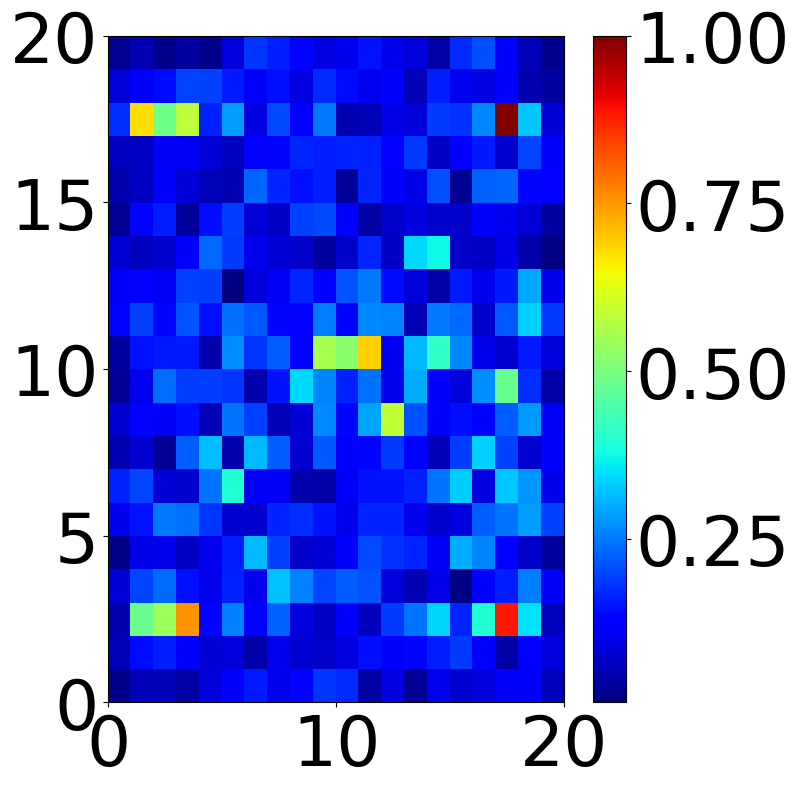

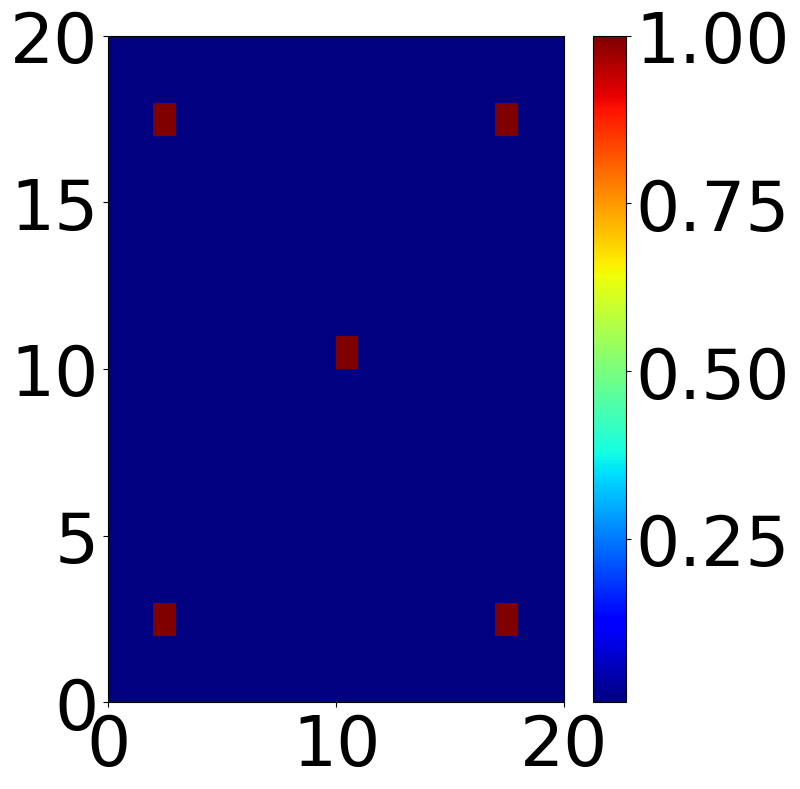

In [ ]:
#Plots the ordered decoder and the original KM image

torch_inners=np.abs(np.inner(G_hat_permed,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
print(sum(torch_inners.diagonal())/400)

def img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()

    b=sensing@rho.T
    img=np.linalg.pinv(sensing_hat)@b
        
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    #cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
img_hat(rho, G_hat_permed.T, medium,xpix=20, ypix=20, file_name='rho_hat',SAME_bar=pcol_Used)
img_hat(rho, medium, medium,xpix=20, ypix=20, file_name='rho',SAME_bar=pcol_Used)

In [ ]:
#Raw data training unlabeled conv layers
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')

unlabeled_data=5000
batchsize=128
L1_weight=0
layers=[500,500,500,300,300,400,800]
#layers.append(256)
GELMA_layers=[32]*11
CE=False
KM_in=False

CONV=True

#GELMA_layers.append(256)

GELMA=0
G_0=True
Epochs=100000
index_list=[]


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2

if CONV:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='conv',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
else:
    encoder=M.fc_net_extra(enc_dim, layers,outdim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
    
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
if G_0:
    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)

relu=nn.ReLU()
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)


softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss()   
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.Adam(GELMA_net.parameters(), lr=.001, maximize=True)
    GELMA_net.to(device)
    GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    #if batchsize<unlabeled_data:
    #    perm=torch.randperm(unlabeled_data)
    #    b=b[perm]
    #    rho=rho[perm]
    #for chunk in range(0, unlabeled_data, batchsize): 
    #    b_chunk=b[chunk:chunk+batchsize]
    #    rho_chunk=rho[chunk:chunk+batchsize]   
    train_lossavg=0
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                
            # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            else:
                rho_hat=encoder(b)
            #if CONV:
            ##    rho_hat=rho_hat.squeeze()
            #    rho_hat=softmax(rho_hat)
            #    rho_hat=rho_hat*4
            #else:
            rho_hat=sigmoid(rho_hat)
            b_hat=decoder(rho_hat)

            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss=L1_loss.item()/L1_weight
            else:
                L1_loss=-1

            if CE:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)/1000
                CEloss.backward(retain_graph=True)
                CEloss=CEloss.item()

            
            if GELMA>0 and epoch>100:
                optimizer_GELMA.zero_grad()
                GELMA_out=GELMA_net(b)
                GELMA_inners=torch.inner(GELMA_out.squeeze(), (b-b_hat).squeeze()).diagonal(dim1=-2, dim2=-1)
                inner_loss_term=GELMA*sum((GELMA_inners))/len(GELMA_inners)
                inner_loss_term.backward(retain_graph=True)
                inner_loss_term_avg=inner_loss_term.item()/GELMA
                optimizer_GELMA.step()
                
            else:
                inner_loss_term_avg=-1
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward()


            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()
    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()




    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
  #  if epoch%10000==0:
      # H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        
    if Track_run:
        wandb.log(wand_dict)

#index_list_list.append(index_list)
print(time.time()-starttime)
torch.save(encoder.state_dict(),f'/home/achristie/RM_imaging/models/med_nets/CCorderer_fc_net_highcow.pt')
torch.save(decoder.state_dict(),f'/home/achristie/RM_imaging/models/med_nets/CCorderer_fc_net_highcow.pt')

if Track_run:
    wandb.finish()


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)


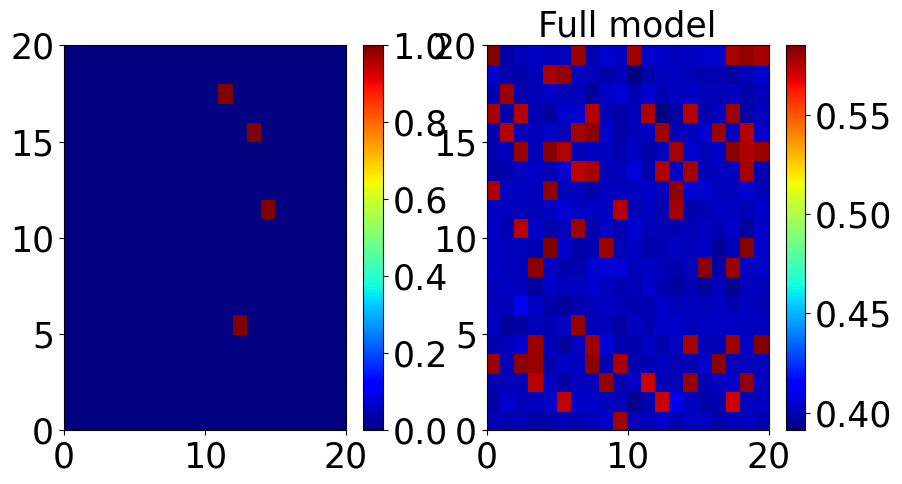

epoch: 0, train loss: 0.08238195357844233, L1 loss: -1, val loss: 0.040840476751327515, max avg inners: 0.06692334081398481, GELMA loss: -1, num indices: 0
epoch: 1, train loss: 0.03906469000503421, L1 loss: -1, val loss: 0.040266502648591995, max avg inners: 0.06693860468066912, GELMA loss: -1, num indices: 0
epoch: 2, train loss: 0.03866398204118013, L1 loss: -1, val loss: 0.04089730978012085, max avg inners: 0.0669359504410034, GELMA loss: -1, num indices: 0
epoch: 3, train loss: 0.03884156616404653, L1 loss: -1, val loss: 0.04138944670557976, max avg inners: 0.06692548815111707, GELMA loss: -1, num indices: 0
epoch: 4, train loss: 0.03890713751316071, L1 loss: -1, val loss: 0.04221049323678017, max avg inners: 0.0669634375464826, GELMA loss: -1, num indices: 0
epoch: 5, train loss: 0.03899692380800843, L1 loss: -1, val loss: 0.04126133769750595, max avg inners: 0.06694207509959113, GELMA loss: -1, num indices: 0
epoch: 6, train loss: 0.038981225993484254, L1 loss: -1, val loss: 0.0

In [ ]:
#raw data training unlabeled with Transformers
starttime=time.time()
target='raw'
unlabeled_data=5000
Epochs=1000  
batchsize=128
#layers.append(256)
layers=[1000,500,200]
Epochs=7000
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')



training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2



encoder_layer = nn.TransformerEncoderLayer(d_model=indim*2, nhead=10)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
connector=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}

trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
L2_loss_fn=nn.MSELoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
optimizer = torch.optim.AdamW(transformer_encoder.parameters(), lr=0.001)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=0.001)
optimizer_connector = torch.optim.AdamW(connector.parameters(), lr=0.001)
transformer_encoder.to(device)
decoder.to(device)
connector.to(device)
transformer_encoder.train()
decoder.train() 
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
sigmoid=nn.Sigmoid()
for epoch in range(Epochs):
    L1_loss=-1
    train_lossavg=0
    val_lossavg=0
    inner_loss_term_avg=-1
    transformer_encoder.train()
    decoder.train() 
    connector.train()
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        rho=rho.to(device)
        optimizer.zero_grad()
        optimizer_decod.zero_grad()
        optimizer_connector.zero_grad()
        rho_hat=connector(transformer_encoder(b))
        rho_hat=sigmoid(rho_hat)
        b_hat=decoder(rho_hat)
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()
        optimizer.step()
        optimizer_decod.step()
        optimizer_connector.step()
        train_lossavg+=L2_loss.item()/len(trainloader)



    transformer_encoder.eval()
    decoder.eval()
    connector.eval()

    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    rho_hat=connector(transformer_encoder(b_val))
    rho_hat=sigmoid(rho_hat)
    b_hat=decoder(rho_hat)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()








    if epoch%10000==0:
        H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
        
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))

        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)


Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
21376002
Data shapes: 725.0 0.5


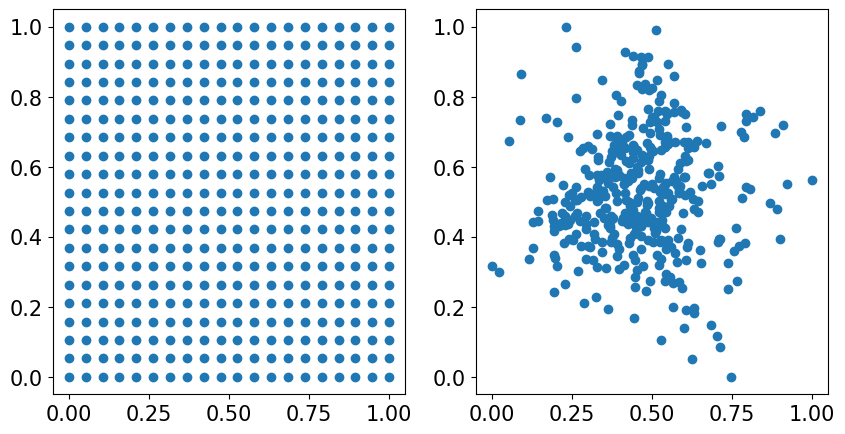

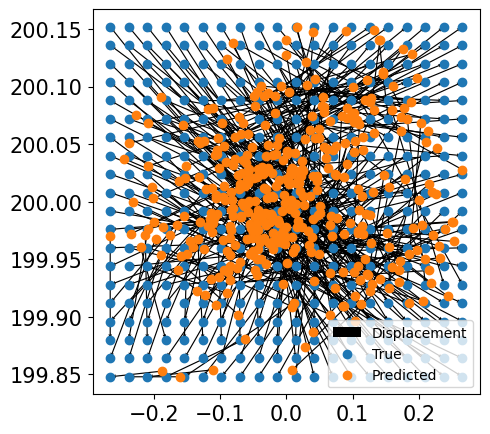

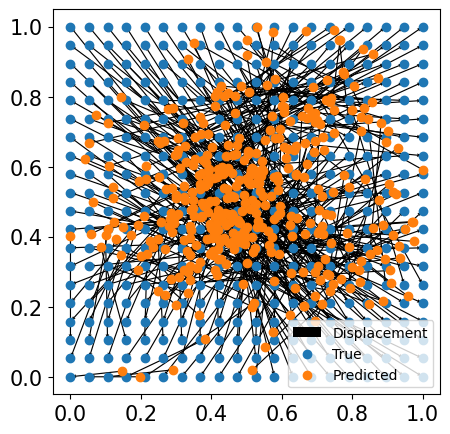

epoch: 0, train loss: 0.12176337838172913, val loss: 0.12387092411518097
epoch: 1, train loss: 0.12012550234794617, val loss: 0.02940676175057888
epoch: 2, train loss: 0.030504021793603897, val loss: 0.027089543640613556
epoch: 3, train loss: 0.027650875970721245, val loss: 0.021044565364718437
epoch: 4, train loss: 0.02285807393491268, val loss: 0.03574623540043831
epoch: 5, train loss: 0.0329553447663784, val loss: 0.015420529060065746
epoch: 6, train loss: 0.01672699861228466, val loss: 0.00910052377730608
epoch: 7, train loss: 0.00917902123183012, val loss: 0.006561975926160812
epoch: 8, train loss: 0.005453960970044136, val loss: 0.0038442069198936224
epoch: 9, train loss: 0.0032416374888271093, val loss: 0.0032740579918026924
epoch: 10, train loss: 0.0033148489892482758, val loss: 0.003200828330591321
epoch: 11, train loss: 0.003105239709839225, val loss: 0.003347425488755107
epoch: 12, train loss: 0.0031791150104254484, val loss: 0.0027710956055670977
epoch: 13, train loss: 0.00

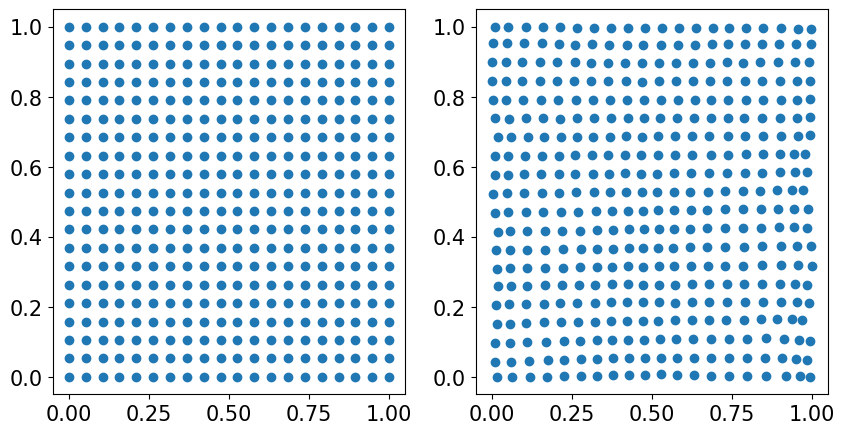

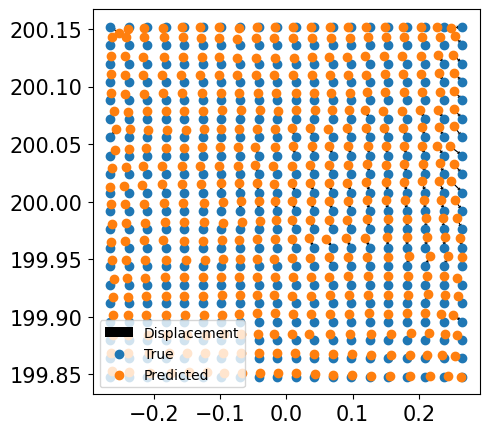

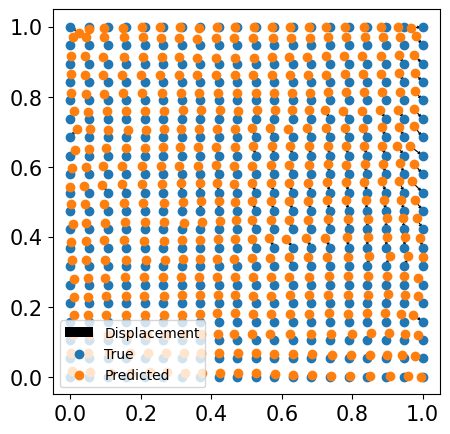

epoch: 500, train loss: 3.426839612075128e-05, val loss: 0.00028098493930883706
epoch: 501, train loss: 3.205119719495997e-05, val loss: 0.00022576286573894322
epoch: 502, train loss: 2.928638059529476e-05, val loss: 0.00022284509032033384
epoch: 503, train loss: 6.98585354257375e-05, val loss: 0.00030079871066845953
epoch: 504, train loss: 0.0001058028792613186, val loss: 0.0004504779353737831
epoch: 505, train loss: 0.00017365887470077723, val loss: 0.000369616667740047
epoch: 506, train loss: 0.0001784349005902186, val loss: 0.00037985018570907414
epoch: 507, train loss: 0.00025317672407254577, val loss: 0.0003055499691981822
epoch: 508, train loss: 0.00010824596392922103, val loss: 0.0003707444993779063
epoch: 509, train loss: 0.00017323765496257693, val loss: 0.00029707810608670115
epoch: 510, train loss: 0.00016958331980276853, val loss: 0.00029803471988998353
epoch: 511, train loss: 0.0001460901548853144, val loss: 0.00036595886922441423
epoch: 512, train loss: 0.000147631668369

KeyboardInterrupt: 

In [33]:
#cc data training #(x, y) coords 
starttime=time.time()
target='raw'
#data_path=os.path.join(cwd,'Data/PNAS-lowcoh_regime_all_seeds/PNAS-lowcoh_regime_seed0')
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
#data_path=os.path.join(cwd,'Data/PNAS-highcoh_regime_all_seeds/PNAS-highcoh_regime_seed0')

grid=np.array(mat73.loadmat(data_path+'/grid.mat')['full_grid'])
b_x=min(grid[:,0])
m_x=(max(grid[:,0])-min(grid[:,0]))
b_y=min(grid[:,1])
m_y=(max(grid[:,1])-min(grid[:,1]))
labeled_data=400
layer_loss_list=[]
Epochs=10000
Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='ENTER YOUR KEY HERE' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='Test runs')
    wandb.config['labeled_data']=labeled_data
wand_dict={}
batchsize=400
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',labeled_data/80000,1, medium='homo')
#trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=4)


b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)


val_data=H.data_rho_CC_XY_targs(data_path+'/val', 3000/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')








In [82]:
decoder=nn.Linear(400,1450*2, bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_long_bigdata/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_30-May-2024 (23:10:16)decoder.pt' #.61 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_20-May-2024 (23:10:30)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (21:26:12)decoder.pt' #.41 G_0 init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_26-May-2024 (23:29:19)decoder.pt' #.92 random init
#locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_19-May-2024 (23:36:13)decoder.pt' #.92 G_0 init


decoder.load_state_dict(torch.load(locat))


Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
cc_medium=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    cc_medium.append(outer)

cc_medium=np.array(cc_medium)
print(outer.shape, cc_medium.shape)
cc_medium=torch.cat((torch.tensor(cc_medium).real, torch.tensor(cc_medium).imag), dim=-1)
cc_medium=cc_medium.to(device)
rho_hat=encoder(cc_medium).squeeze()
rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
rho_hat[:,0]=rho_hat[:,0]*20
rho_hat[:,1]=rho_hat[:,1]*20
rho_hat_t=torch.round(rho_hat)


(12124,) (400, 12124)


(400, 2) (400, 1450)


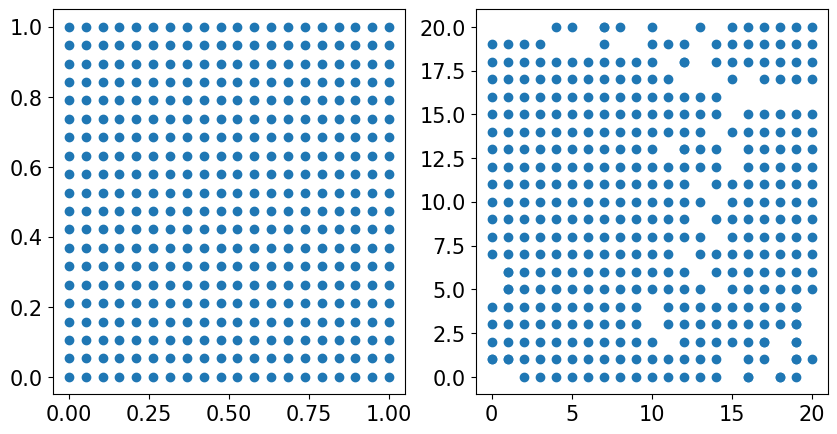

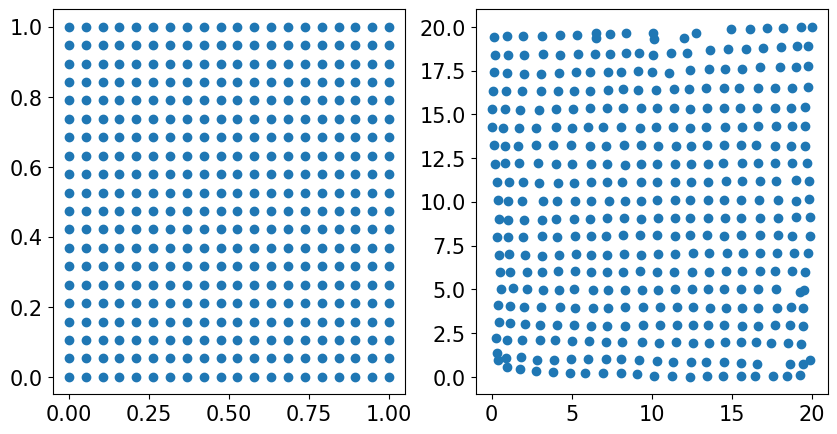

In [83]:
coord_list=rho_hat.detach().cpu().numpy()
column_list=medium_hat
print(coord_list.shape, medium_hat.shape)
coord_list=[tuple(i) for i in coord_list]
pairs=zip(coord_list, column_list)
coord_list_sorted=sorted(coord_list)

sorted_pairs=[(col, xy) for col, xy in sorted(zip(medium_hat, coord_list), key=lambda pair: (pair[1][0], pair[1][1]))]


H.plot_2_imgs_XY(rho, rho_hat_t.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)

In [78]:
for i in range(400):
    if rho_hat[i][0]<1 and rho_hat[i][1]<1:
        print(i)
rho_hat[0]

0


tensor([0.1909, 0.1488], device='cuda:0', grad_fn=<SelectBackward0>)

In [80]:
sorted_pairs[0]

(array([ 0.00542664-0.02640188j, -0.0264063 -0.00375857j,
         0.00323797+0.02652012j, ..., -0.00245878+0.02592956j,
         0.00499327-0.02534299j,  0.02145175+0.01418957j], dtype=complex64),
 (0.0, 14.7246275))

(400, 1450) (400, 1450)
shape of single cc entry: (12124,), norm of single cc entry: 0.999999967304575
(400, 1450)
rearranged average innter product: 0.9302892977489609
number of correctly (>.97 inner) placed elements: 355


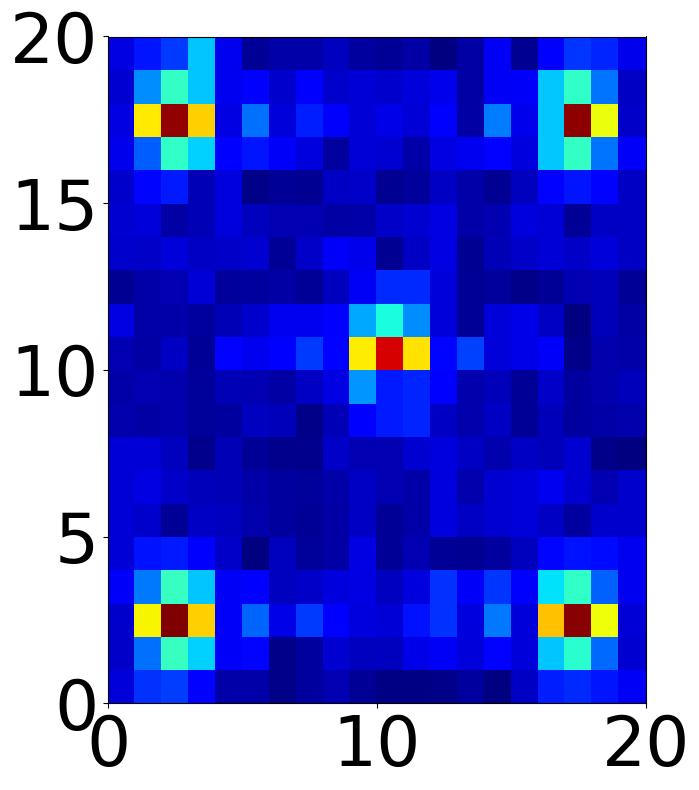

In [ ]:
#Checks if theres a clear 1-1 correspondence b/w ghat ghat^* and g g^*
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
Mask=np.array(mat73.loadmat(data_path+'/M.mat')['M'])

decoder=nn.Linear(400,1450*2, bias=False)
locat= '/home/achristie/Codes_data/Experiment_data/GELMA_Long/0L_160000U_[500, 500, 500, 300, 300, 400, 800]_17-May-2024 (17:39:30)decoder.pt' # .71 G_0 init
decoder.load_state_dict(torch.load(locat))
Complex_eye=torch.eye(400).unsqueeze(1)
medium_hat=decoder(Complex_eye)
medium_hat=medium_hat.squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)
medium=medium.T
print(medium_hat.shape, medium.shape)
cc_medium_hat=[]
for i in range(len(medium_hat)):
    outer=np.outer(medium_hat[i],medium_hat[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium_hat.append(outer)

test_entry=cc_medium_hat[0]
print(f'shape of single cc entry: {test_entry.shape}, norm of single cc entry: {sum(abs(test_entry)**2)}')


cc_medium_hat=np.array(cc_medium_hat)
cc_medium=[]
for i in range(len(medium)):
    outer=np.outer(medium[i],medium[i].conj())
    outer=outer[abs(Mask)>0]
    outer=outer.ravel()
    outer=outer/np.linalg.norm(outer)
    cc_medium.append(outer)
cc_medium=np.array(cc_medium)

G_hat_permed=np.zeros_like(medium_hat)

torch_inners=np.abs(np.inner(cc_medium_hat,cc_medium.conj()) ) #entry i j is ghat_i dot bar(g_j) 
# mean over true max over hats
torch_inners=torch.tensor(torch_inners)
for i in range(400):
    largest,indices_1=torch.max(torch_inners, -1) #where to put the i-th element
    overall_max_index=torch.argmax(largest)
    G_hat_permed[indices_1[overall_max_index],:]=medium_hat[overall_max_index,:]
    torch_inners[:,indices_1[overall_max_index]]=0

print(G_hat_permed.shape)
torch_inners=np.abs(np.inner(G_hat_permed,medium.conj()) ) #entry i j is ghat_i dot bar(g_j)
print(f'rearranged average innter product: {sum(torch_inners.diagonal())/400}')
print(f'number of correctly (>.97 inner) placed elements: {sum(torch_inners.diagonal()>.97)}')



rho=np.zeros((400))
rho=np.zeros((400))
rho[37+20]=1
rho[22+20]=1
rho[400-22-1-20]=1
rho[400-37-1-20]=1
rho[210]=1




sensing_hat=medium.T
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(20, 20)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, G_hat_permed.T, medium.T,xpix=20, ypix=20, SAME_bar=pcol_Used)




In [ ]:
#KM images with specifed grids

data_path=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])








def KM_img_hat(rho, sensing_hat,sensing,figsize=8,scaling='Linf',font_size=50, file_name=None, xpix=31, ypix=21,WAND=False, SAME_bar=None):
    plt.close()
    b=sensing@rho.T
    img=sensing_hat.T.conj()@b
    
    figsize=(figsize,figsize)
    fig=plt.figure(figsize=figsize)

    tick_params = {'labelsize': font_size}



    output=img

    output=np.abs(output)/np.max(np.abs((output)))
    
    output=output.reshape(xpix, ypix)

    ax=plt.gca()
    pcol=ax.pcolor(output,cmap='jet')
    if SAME_bar!=None:
        cbar=plt.colorbar(SAME_bar, ax=ax)
    else:
        cbar=plt.colorbar(pcol, ax=ax)
    
    cbar.ax.tick_params(labelsize=font_size)
    cbar.remove()
    ax.tick_params(axis='both', **tick_params)
    if file_name!=None:
        plt.savefig(f'/home/achristie/Codes_data/E_D_figs/{file_name}.pdf')
    plt.tight_layout()
    if WAND:
        
        
        buf = io.BytesIO()
        fig.savefig(buf)
        buf.seek(0)
        img = Image.open(buf)
        
        del fig, buf
        return [wandb.Image(img)]
    else:
        plt.show()



print(medium.shape)
rho=np.zeros((3600))
#rho[37+20]=1
#rho[22+20]=1
#rho[400-22-1-20]=1
#rho[400-37-1-20]=1
rho[int(60*60/2)+30]=1


#rho[0]=1
sensing_hat=medium
b=sensing_hat@rho
img=sensing_hat.T.conj()@b

figsize=(15,15)
fig=plt.figure(figsize=figsize)

tick_params = {'labelsize': 15}



output=img

output=np.abs(output)/np.max(np.abs((output)))

output=output.reshape(60, 60)

ax=plt.gca()
pcol_Used=ax.pcolor(output,cmap='jet')
KM_img_hat(rho, medium, medium,xpix=60, ypix=60, SAME_bar=pcol_Used)

In [31]:
#cc data training #(x, y) coords. Uses largexlarge grid for homo, and 20x20 for random
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
print

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
layers=[250,1000,750,500, 500, 300, 300, 400,800]
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo', grid='grid_100by100.mat')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
print('billy')
data_path_val=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1)
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)



encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)

        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/achristie/RM_imaging/RM_imaging/Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0//G_0.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
training data passed
Medium: (1450, 10000), Rho: (10000, 10000), B: (10000, 1450)
Data shapes: 725.0 0.5
15318018
Data shapes: 725.0 0.5


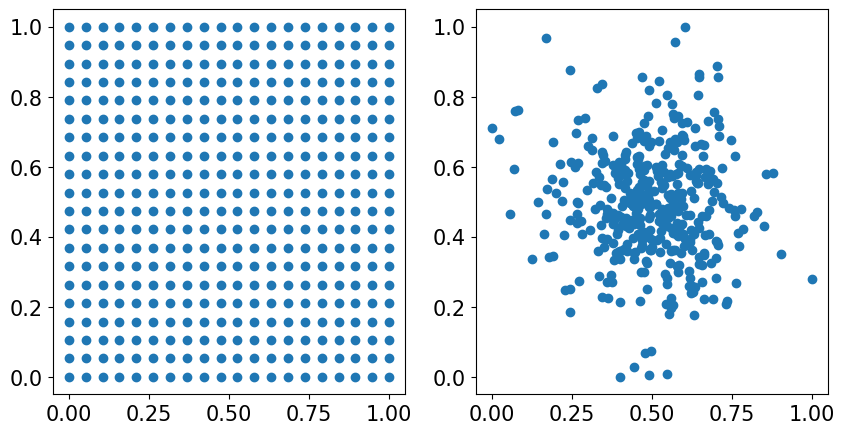

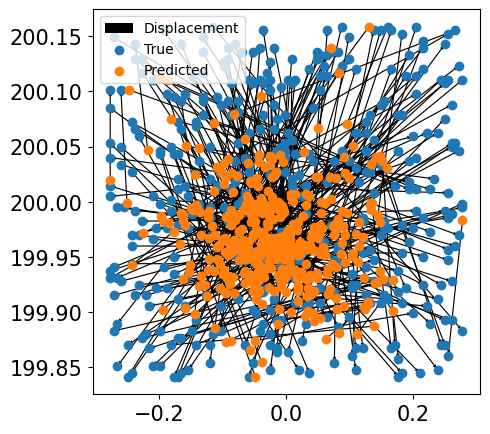

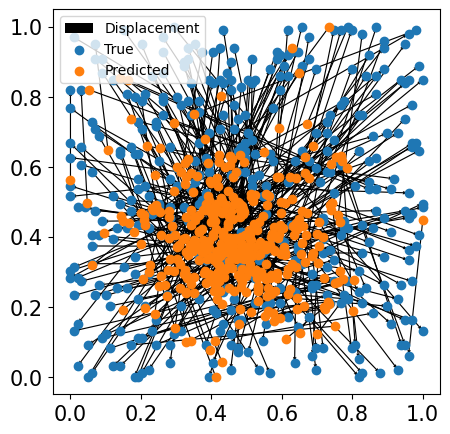

epoch: 0, train loss: 0.10964679718017578, val loss: 0.102324940264225
epoch: 1, train loss: 0.11038937419652939, val loss: 0.03773479536175728
epoch: 2, train loss: 0.04436033219099045, val loss: 0.031763363629579544
epoch: 3, train loss: 0.03935588151216507, val loss: 0.04567313939332962
epoch: 4, train loss: 0.04750855267047882, val loss: 0.03048943541944027
epoch: 5, train loss: 0.037528641521930695, val loss: 0.033223956823349
epoch: 6, train loss: 0.03136741742491722, val loss: 0.020269932225346565
epoch: 7, train loss: 0.028289124369621277, val loss: 0.021753644570708275
epoch: 8, train loss: 0.02356659062206745, val loss: 0.015623974613845348
epoch: 9, train loss: 0.01712782122194767, val loss: 0.006437072530388832
epoch: 10, train loss: 0.007199085783213377, val loss: 0.006126978434622288
epoch: 11, train loss: 0.005708849523216486, val loss: 0.006049929186701775
epoch: 12, train loss: 0.0050404807552695274, val loss: 0.005209791474044323
epoch: 13, train loss: 0.0040909182280

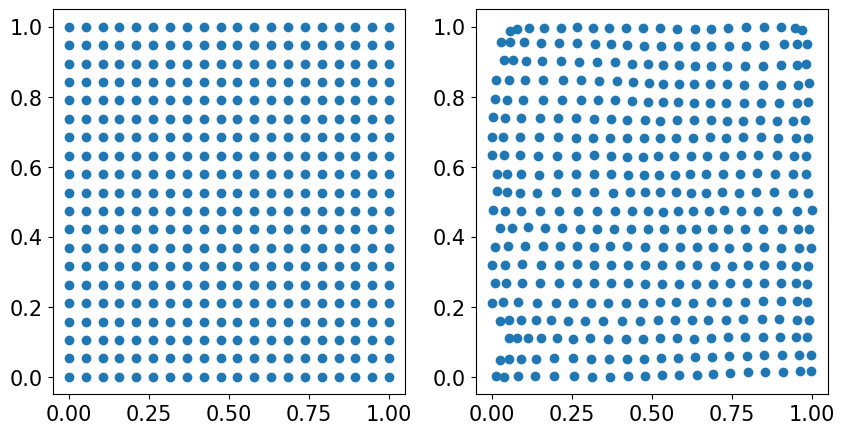

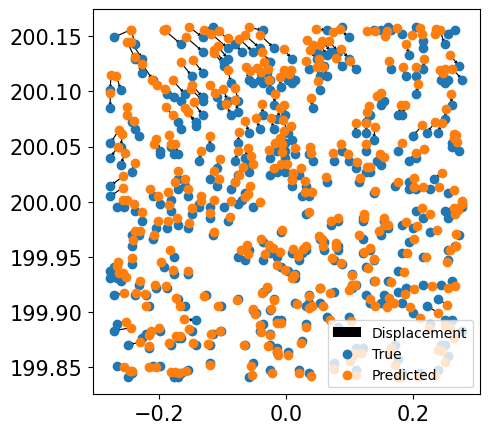

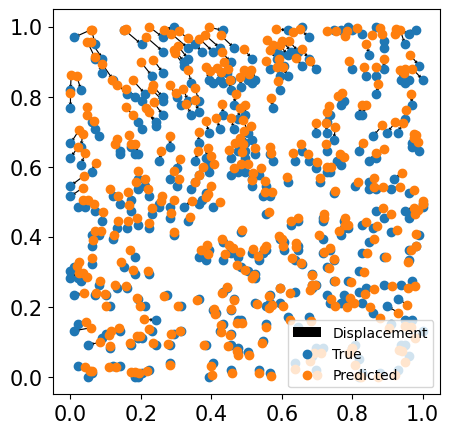

epoch: 500, train loss: 6.675811164313927e-05, val loss: 0.00036187819205224514
epoch: 501, train loss: 6.6179214627482e-05, val loss: 0.00039212731644511223
epoch: 502, train loss: 5.938792310189456e-05, val loss: 0.0004493830492720008
epoch: 503, train loss: 6.044939800631255e-05, val loss: 0.0004898191546089947
epoch: 504, train loss: 6.0963862779317424e-05, val loss: 0.0004986588610336185
epoch: 505, train loss: 5.4436510254163295e-05, val loss: 0.00047361277393065393
epoch: 506, train loss: 4.629682734957896e-05, val loss: 0.0004430038679856807
epoch: 507, train loss: 4.295409598853439e-05, val loss: 0.00041608570609241724
epoch: 508, train loss: 4.338523285696283e-05, val loss: 0.0004259468405507505
epoch: 509, train loss: 3.8851962017361075e-05, val loss: 0.0004436512535903603
epoch: 510, train loss: 3.38804857165087e-05, val loss: 0.00043952642590738833
epoch: 511, train loss: 3.1003670301288366e-05, val loss: 0.00044887192780151963
epoch: 512, train loss: 3.527619628584944e-05

KeyboardInterrupt: 

In [2]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a 400 point random sample from 100x100 grid for random
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_2xgrid_all_seeds/PNAS-regime_2xgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_100by100.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)
perm=np.random.permutation(len(b_val))
b_val=b_val[perm]
b_val=b_val[:400]
rho_val=rho_val[perm]
rho_val=rho_val[:400]

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
training data passed
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
15318018
Data shapes: 725.0 0.5


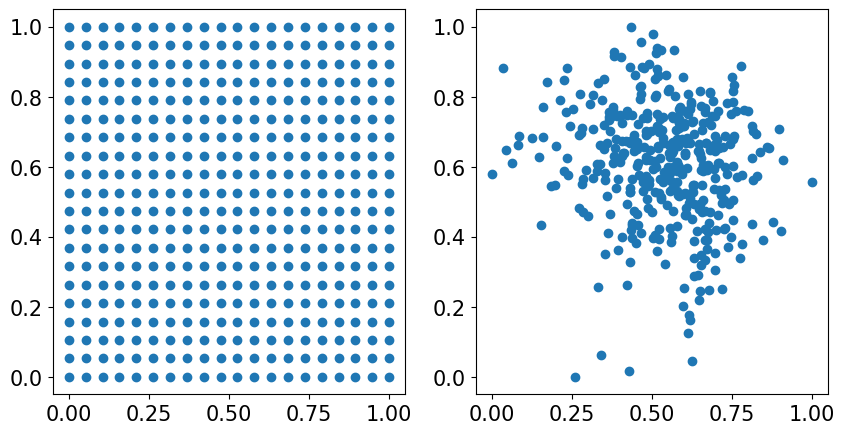

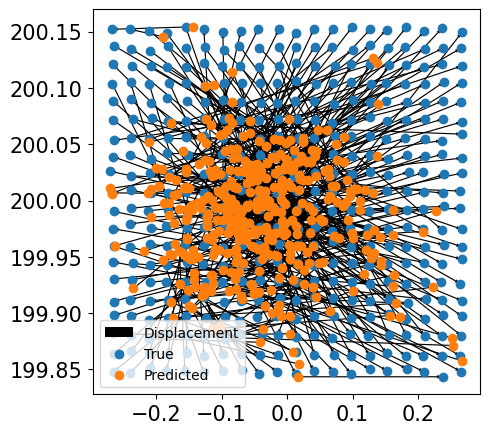

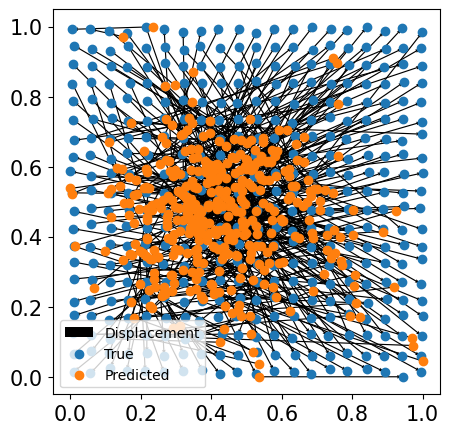

epoch: 0, train loss: 0.1267431676387787, val loss: 0.1263132393360138
epoch: 1, train loss: 0.13081583380699158, val loss: 0.05952858924865723
epoch: 2, train loss: 0.058279797434806824, val loss: 0.035395558923482895
epoch: 3, train loss: 0.033558476716279984, val loss: 0.03034847229719162
epoch: 4, train loss: 0.028636593371629715, val loss: 0.039494793862104416
epoch: 5, train loss: 0.04291418939828873, val loss: 0.01872166059911251
epoch: 6, train loss: 0.01902756094932556, val loss: 0.022871213033795357
epoch: 7, train loss: 0.023592161014676094, val loss: 0.013477480039000511
epoch: 8, train loss: 0.014043347910046577, val loss: 0.013094880618155003
epoch: 9, train loss: 0.012897399254143238, val loss: 0.008511563763022423
epoch: 10, train loss: 0.00921604223549366, val loss: 0.009209358133375645
epoch: 11, train loss: 0.008644070476293564, val loss: 0.007893454283475876
epoch: 12, train loss: 0.008094287477433681, val loss: 0.00580469099804759
epoch: 13, train loss: 0.006202532

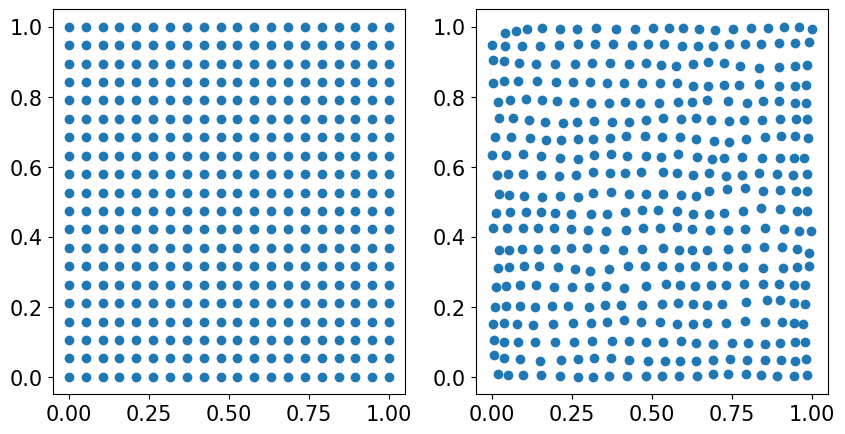

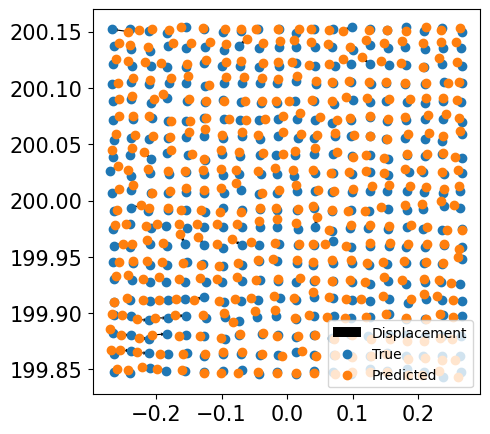

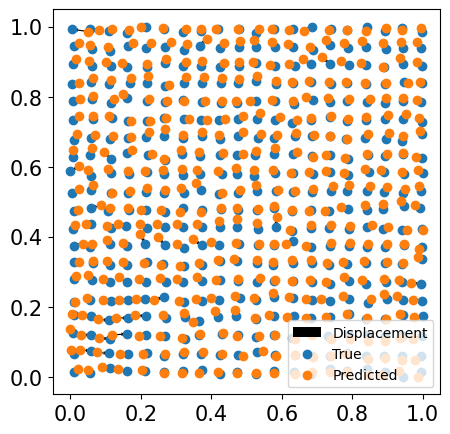

epoch: 50, train loss: 6.96190691087395e-05, val loss: 0.00011859729420393705
epoch: 51, train loss: 5.337270340532996e-05, val loss: 0.00012257680646143854
epoch: 52, train loss: 4.6153170842444524e-05, val loss: 0.00013125120312906802
epoch: 53, train loss: 4.276382605894469e-05, val loss: 0.0001410124241374433
epoch: 54, train loss: 4.619118044502102e-05, val loss: 0.0001323891046922654
epoch: 55, train loss: 4.607157825375907e-05, val loss: 0.00012471905210986733
epoch: 56, train loss: 4.3103424104629084e-05, val loss: 0.00013343685714062303
epoch: 57, train loss: 3.7919289752608165e-05, val loss: 0.00011294843716314062
epoch: 58, train loss: 3.5158715036232024e-05, val loss: 0.00010023895447375253
epoch: 59, train loss: 3.458117134869099e-05, val loss: 9.616103488951921e-05
epoch: 60, train loss: 3.253613249398768e-05, val loss: 8.400225488003343e-05
epoch: 61, train loss: 2.7609752578428015e-05, val loss: 7.584406557725742e-05
epoch: 62, train loss: 2.616396341181826e-05, val los

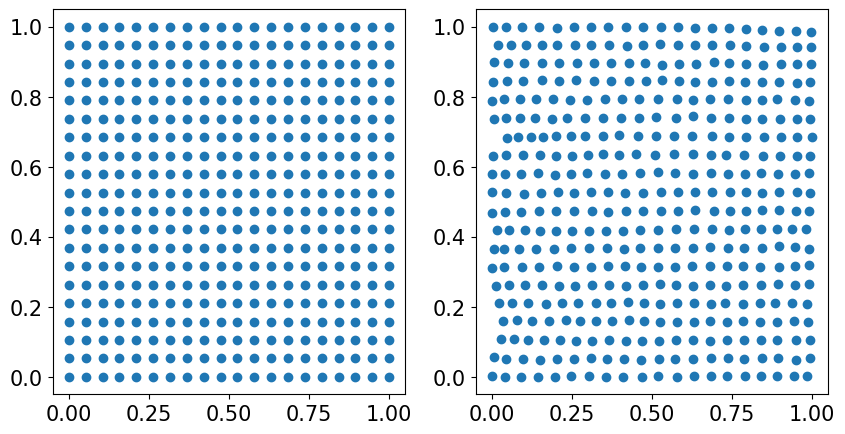

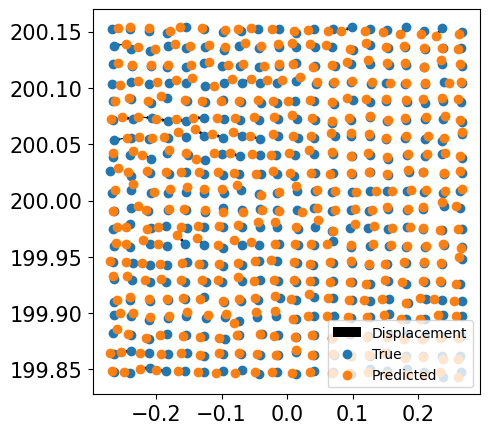

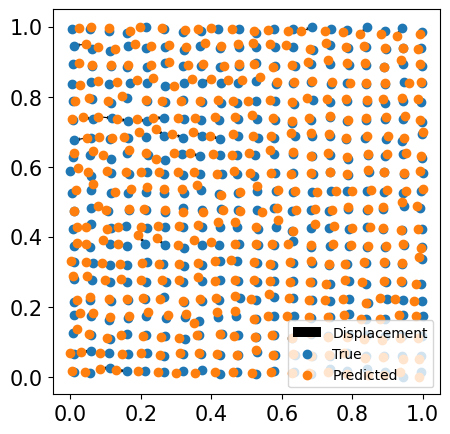

epoch: 100, train loss: 4.714634997071698e-05, val loss: 0.00010185094288317487
epoch: 101, train loss: 4.803955744137056e-05, val loss: 9.825317101785913e-05
epoch: 102, train loss: 3.9136426494224e-05, val loss: 9.825469896895811e-05
epoch: 103, train loss: 3.081217801081948e-05, val loss: 9.649094863561913e-05
epoch: 104, train loss: 2.6838430130737834e-05, val loss: 9.973004489438608e-05
epoch: 105, train loss: 2.8180382287246175e-05, val loss: 0.00010620012471918017
epoch: 106, train loss: 2.7849215257447213e-05, val loss: 0.00010558091889834031
epoch: 107, train loss: 2.5200319214491174e-05, val loss: 9.872391819953918e-05
epoch: 108, train loss: 2.257449523312971e-05, val loss: 9.54813658609055e-05
epoch: 109, train loss: 1.8872082364396192e-05, val loss: 8.340251224581152e-05
epoch: 110, train loss: 2.3358181351795793e-05, val loss: 8.80863590282388e-05
epoch: 111, train loss: 2.523806324461475e-05, val loss: 9.659722854848951e-05
epoch: 112, train loss: 2.5794715838856064e-05,

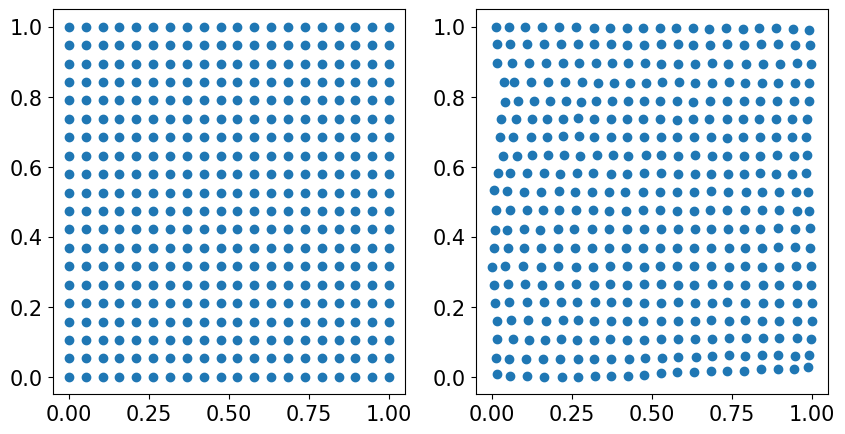

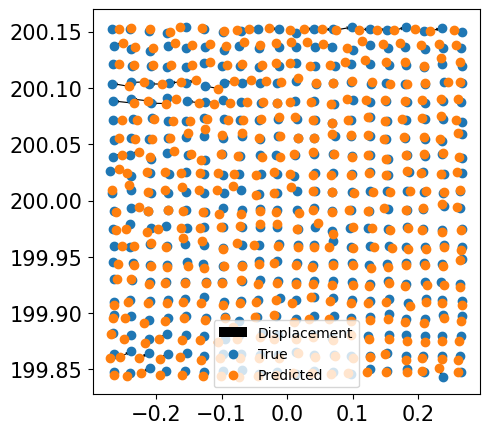

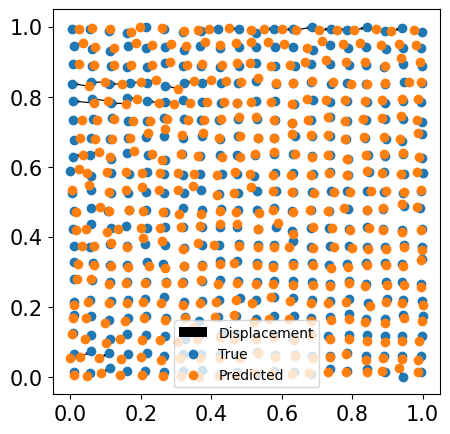

epoch: 150, train loss: 4.062683365191333e-05, val loss: 0.00010869685502257198
epoch: 151, train loss: 4.4369073293637484e-05, val loss: 0.00011331846326356754
epoch: 152, train loss: 3.888171340804547e-05, val loss: 0.00010812034452101216
epoch: 153, train loss: 3.6810979509027675e-05, val loss: 0.0001143063636845909
epoch: 154, train loss: 3.824149462161586e-05, val loss: 0.00011147712939418852
epoch: 155, train loss: 3.404081508051604e-05, val loss: 0.00010861425107577816
epoch: 156, train loss: 3.184889646945521e-05, val loss: 8.94349068403244e-05
epoch: 157, train loss: 2.7423295250628144e-05, val loss: 0.00010597296932246536
epoch: 158, train loss: 3.1042811315273866e-05, val loss: 8.250719110947102e-05
epoch: 159, train loss: 3.698872751556337e-05, val loss: 0.0001141661123256199
epoch: 160, train loss: 4.081599399796687e-05, val loss: 7.868412649258971e-05
epoch: 161, train loss: 5.919801697018556e-05, val loss: 7.439642649842426e-05
epoch: 162, train loss: 4.82634459331166e-0

KeyboardInterrupt: 

In [4]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a slightly (.1% pertrubed grid)
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_20by20_pert.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%50==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%50==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
training data passed
Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)
Data shapes: 725.0 0.5
15318018
Data shapes: 725.0 0.5


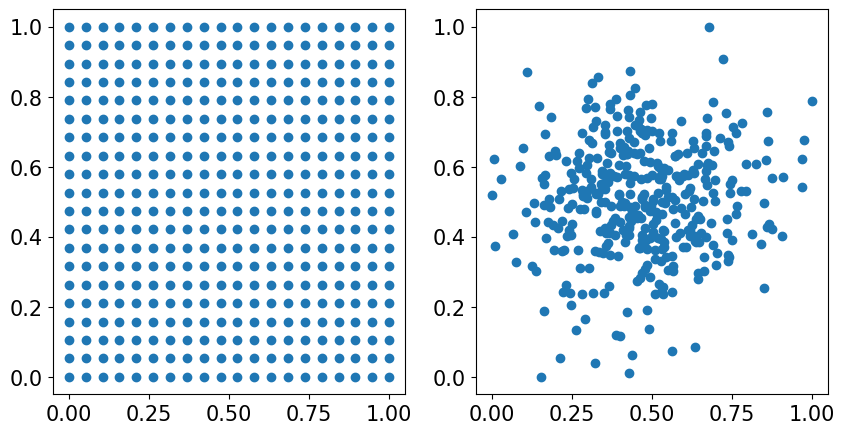

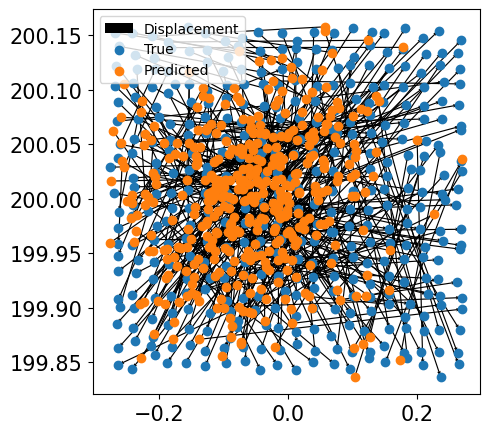

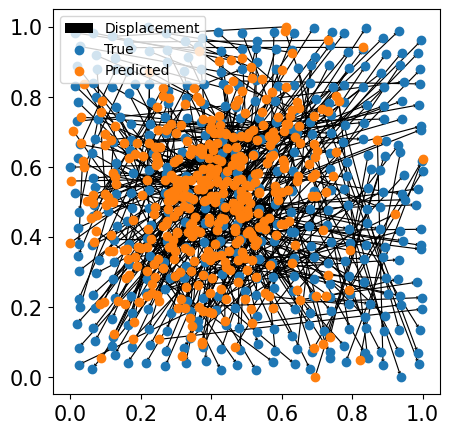

epoch: 0, train loss: 0.12340526282787323, val loss: 0.1204628273844719
epoch: 1, train loss: 0.11893302947282791, val loss: 0.06053002178668976
epoch: 2, train loss: 0.07745221257209778, val loss: 0.04269828647375107
epoch: 3, train loss: 0.050710245966911316, val loss: 0.035274870693683624
epoch: 4, train loss: 0.03803901746869087, val loss: 0.0358956977725029
epoch: 5, train loss: 0.04027658328413963, val loss: 0.03296419605612755
epoch: 6, train loss: 0.03467050567269325, val loss: 0.028187202289700508
epoch: 7, train loss: 0.03673727437853813, val loss: 0.01952737756073475
epoch: 8, train loss: 0.021937832236289978, val loss: 0.022791678085923195
epoch: 9, train loss: 0.025311598554253578, val loss: 0.012530447915196419
epoch: 10, train loss: 0.01281258650124073, val loss: 0.01197547372430563
epoch: 11, train loss: 0.011724316515028477, val loss: 0.006865429691970348
epoch: 12, train loss: 0.0063678547739982605, val loss: 0.005962336901575327
epoch: 13, train loss: 0.0057122311554

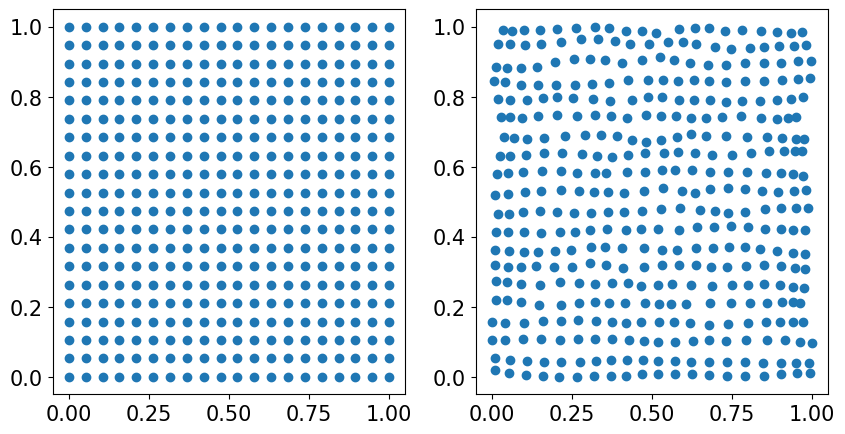

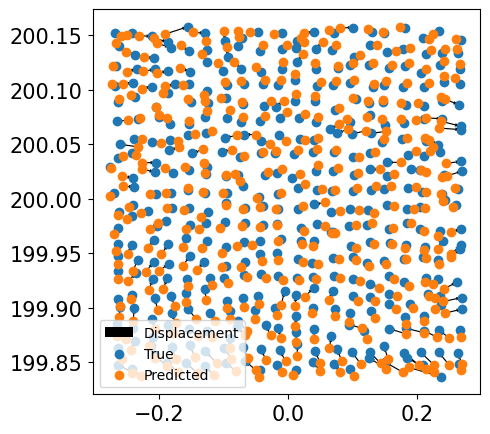

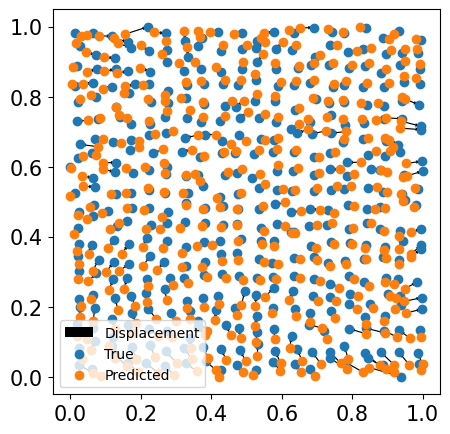

epoch: 50, train loss: 8.29203418106772e-05, val loss: 0.00033919885754585266
epoch: 51, train loss: 7.477666076738387e-05, val loss: 0.00032214372185990214
epoch: 52, train loss: 7.234322401927784e-05, val loss: 0.00030452111968770623
epoch: 53, train loss: 6.580054468940943e-05, val loss: 0.00028942464268766344
epoch: 54, train loss: 6.379644037224352e-05, val loss: 0.0002753270964603871
epoch: 55, train loss: 5.9191061154706404e-05, val loss: 0.00027033925289288163
epoch: 56, train loss: 5.374649481382221e-05, val loss: 0.00025666659348644316
epoch: 57, train loss: 5.003743353881873e-05, val loss: 0.0002580891887191683
epoch: 58, train loss: 4.656855890061706e-05, val loss: 0.00026938432711176574
epoch: 59, train loss: 4.517479828791693e-05, val loss: 0.0002783068921416998
epoch: 60, train loss: 4.2859173845499754e-05, val loss: 0.0002589798823464662
epoch: 61, train loss: 3.509104863042012e-05, val loss: 0.00023766205413267016
epoch: 62, train loss: 3.231436130590737e-05, val loss:

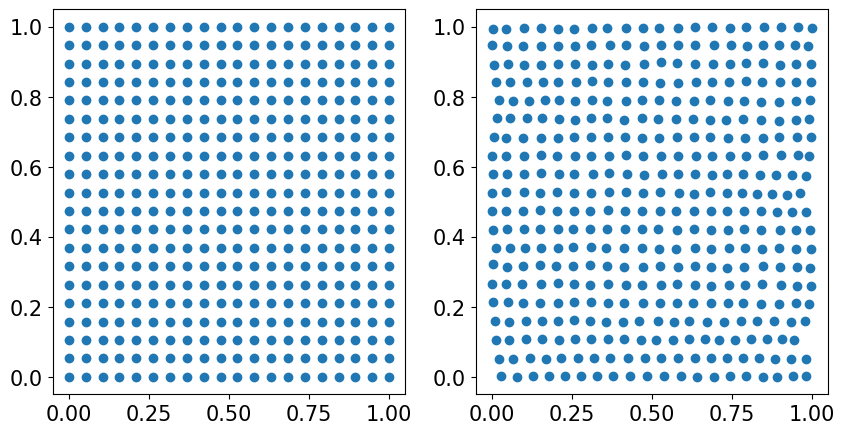

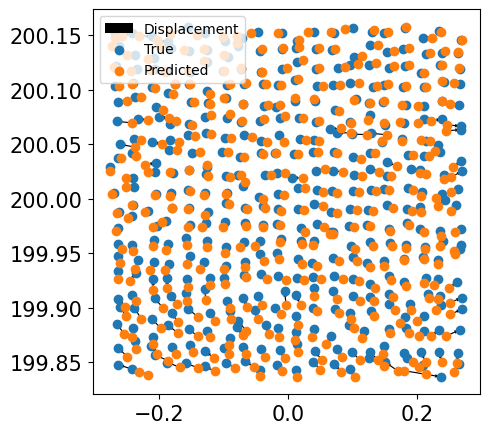

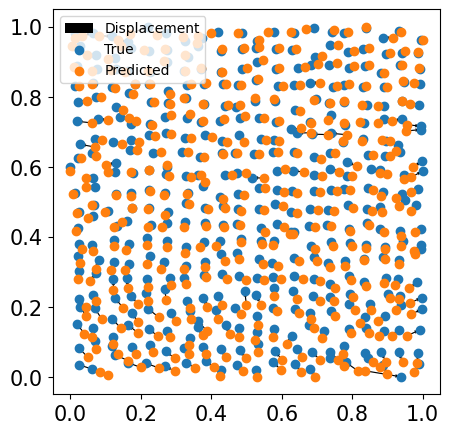

epoch: 100, train loss: 3.967042357544415e-05, val loss: 0.0002382663224125281
epoch: 101, train loss: 2.9296023058122955e-05, val loss: 0.0002560355933383107
epoch: 102, train loss: 2.737324575718958e-05, val loss: 0.00027857342502102256
epoch: 103, train loss: 3.084865238633938e-05, val loss: 0.0002511186758056283
epoch: 104, train loss: 2.9945244023110718e-05, val loss: 0.00024363247212022543
epoch: 105, train loss: 2.931435483333189e-05, val loss: 0.00024262172519229352
epoch: 106, train loss: 2.9423474188661203e-05, val loss: 0.0002483910648152232
epoch: 107, train loss: 2.2856022042105906e-05, val loss: 0.000246521201916039
epoch: 108, train loss: 2.229472556791734e-05, val loss: 0.00023614754900336266
epoch: 109, train loss: 3.0632952984888107e-05, val loss: 0.00024296446645166725
epoch: 110, train loss: 2.63412748608971e-05, val loss: 0.0002556453109718859
epoch: 111, train loss: 2.216221037087962e-05, val loss: 0.00025212010950781405
epoch: 112, train loss: 2.3641150619369e-05

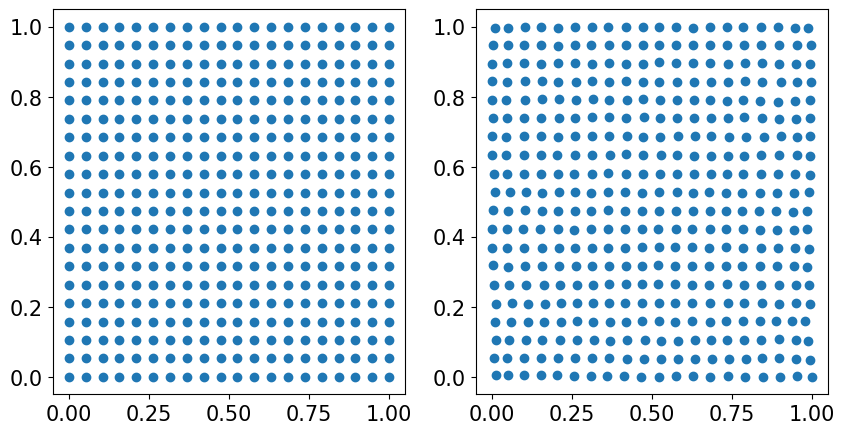

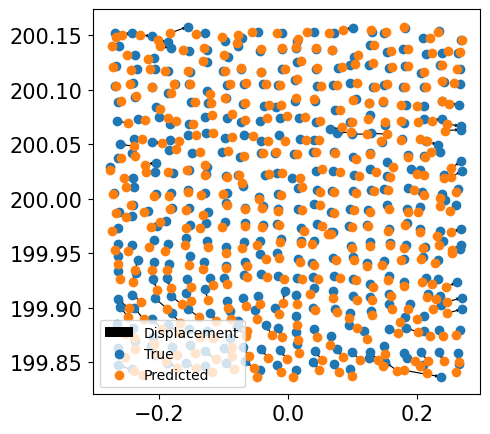

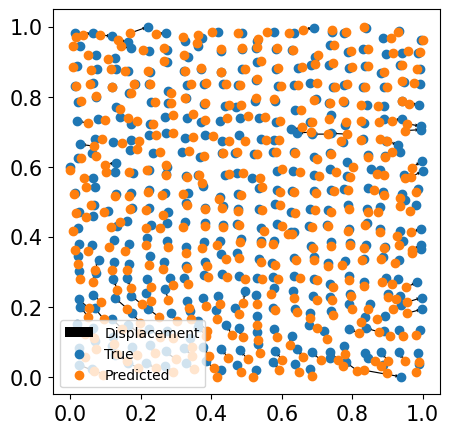

epoch: 150, train loss: 1.1716846529452596e-05, val loss: 0.00022801727754995227
epoch: 151, train loss: 1.7585709429113194e-05, val loss: 0.0002219059388153255
epoch: 152, train loss: 1.8175718651036732e-05, val loss: 0.00023272437101695687
epoch: 153, train loss: 1.2558128219097853e-05, val loss: 0.00024233061412815005
epoch: 154, train loss: 1.5022936167952139e-05, val loss: 0.0002525283198338002
epoch: 155, train loss: 2.4300970835611224e-05, val loss: 0.00026338486350141466
epoch: 156, train loss: 2.5163795726257376e-05, val loss: 0.0002644346677698195
epoch: 157, train loss: 3.160720370942727e-05, val loss: 0.00023830738791730255
epoch: 158, train loss: 4.9118891183752567e-05, val loss: 0.0002646694774739444
epoch: 159, train loss: 4.6797020331723616e-05, val loss: 0.00021980589372105896
epoch: 160, train loss: 5.1991100917803124e-05, val loss: 0.00022140837972983718
epoch: 161, train loss: 4.234100924804807e-05, val loss: 0.00024386891163885593
epoch: 162, train loss: 4.86474709

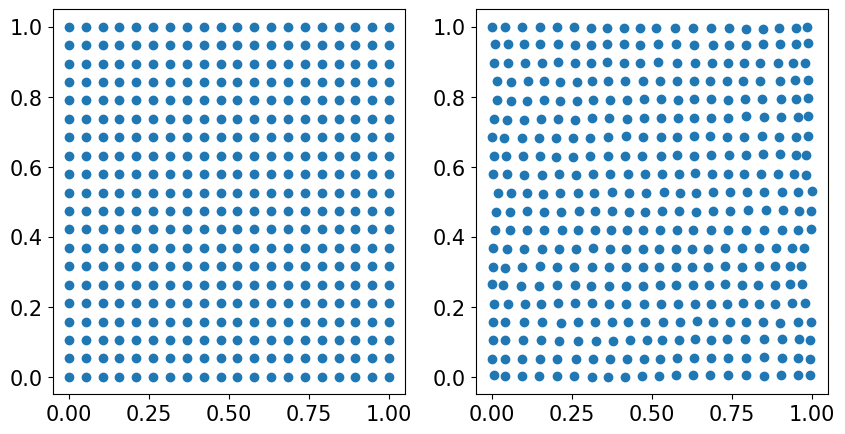

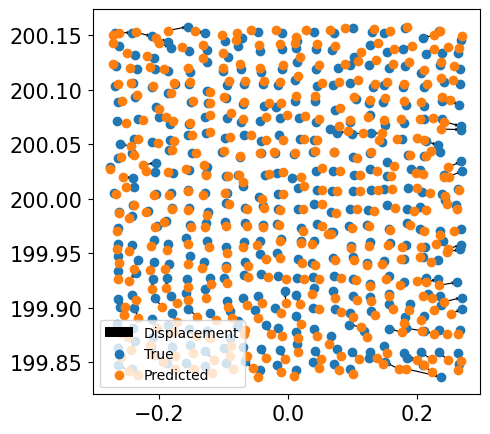

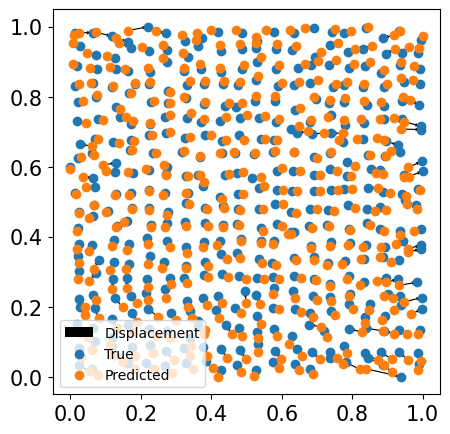

epoch: 200, train loss: 2.932423012680374e-05, val loss: 0.0002321318897884339
epoch: 201, train loss: 2.664485145942308e-05, val loss: 0.00022297585383057594
epoch: 202, train loss: 2.6569074179860763e-05, val loss: 0.00021894874225836247
epoch: 203, train loss: 2.7057123588747345e-05, val loss: 0.00021821685368195176
epoch: 204, train loss: 2.3944377971929498e-05, val loss: 0.00022039253963157535
epoch: 205, train loss: 1.9647248336696066e-05, val loss: 0.00022020726464688778
epoch: 206, train loss: 1.771419010765385e-05, val loss: 0.00023423696984536946
epoch: 207, train loss: 1.7014008335536346e-05, val loss: 0.00022880463802721351
epoch: 208, train loss: 2.1993042537360452e-05, val loss: 0.00022734689991921186
epoch: 209, train loss: 2.0554251022986136e-05, val loss: 0.00022968325356487185
epoch: 210, train loss: 1.724615322018508e-05, val loss: 0.00023536330263596028
epoch: 211, train loss: 1.6851985492394306e-05, val loss: 0.00020876992493867874
epoch: 212, train loss: 1.8202203

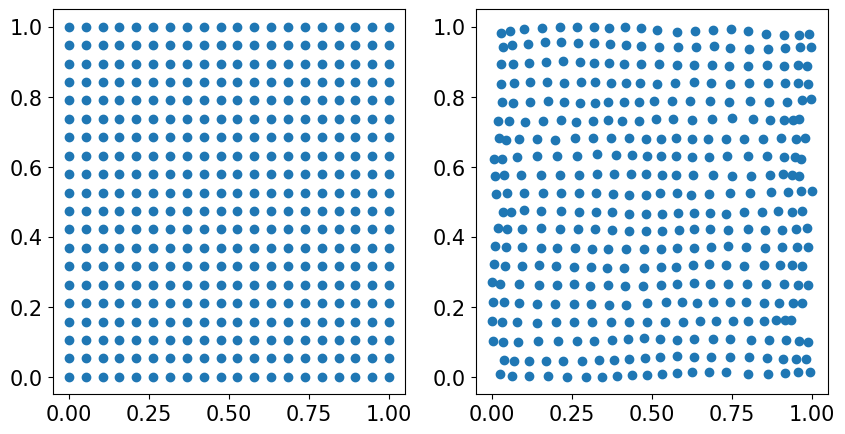

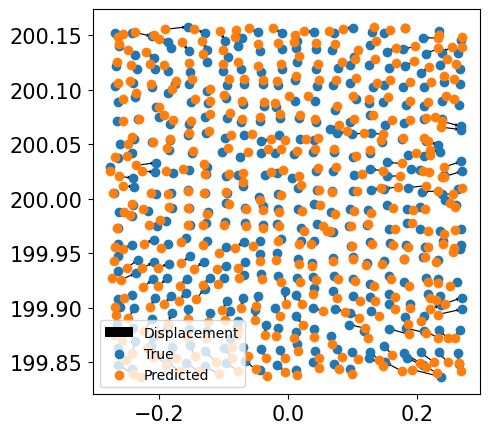

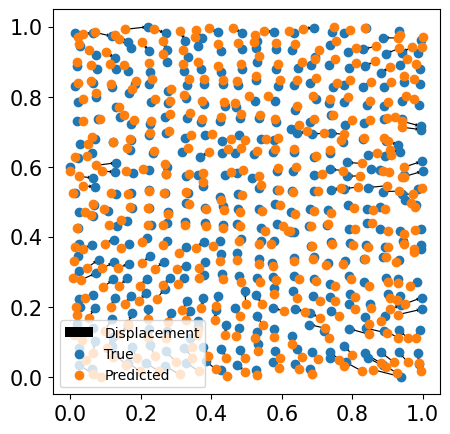

epoch: 250, train loss: 0.00010193332855124027, val loss: 0.0003265797276981175
epoch: 251, train loss: 9.302465332439169e-05, val loss: 0.000326138804666698
epoch: 252, train loss: 8.988763875095174e-05, val loss: 0.000321607367368415
epoch: 253, train loss: 7.750261283945292e-05, val loss: 0.000306437024846673
epoch: 254, train loss: 7.281755097210407e-05, val loss: 0.000294723198749125
epoch: 255, train loss: 5.97858706896659e-05, val loss: 0.0002787828561849892
epoch: 256, train loss: 6.554427091032267e-05, val loss: 0.00028021621983498335
epoch: 257, train loss: 5.77725913899485e-05, val loss: 0.0002658729499671608
epoch: 258, train loss: 5.0876558816526085e-05, val loss: 0.0002594121906440705
epoch: 259, train loss: 4.630662442650646e-05, val loss: 0.00025439661112613976
epoch: 260, train loss: 4.243640069034882e-05, val loss: 0.00024161956389434636
epoch: 261, train loss: 3.568628380890004e-05, val loss: 0.0002266042574774474
epoch: 262, train loss: 3.286074206698686e-05, val lo

In [6]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a slightly (.01% pertrubed grid)
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_25percent_pertgrid_all_seeds/PNAS-regime_25percent_pertgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_20by20_pert.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%50==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%50==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






In [ ]:
#Raw data training unlabeled, only solving b---->b
target='raw'
unlabeled_data=5000
batchsize=128
layers=[1000]*8

Epochs=7000


Track_run=False
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
val_data=H.data_rho_loaded(data_path+'/val', 3000/80000)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2


encoder=M.fc_net_batch(enc_dim, layers,enc_dim , net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=0.001)
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
for epoch in range(Epochs):
    train_lossavg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        b=b.to(device)
        b=F.normalize(b, dim=-1)
        optimizer.zero_grad()

        b_hat=encoder(b)
        b_hat=F.normalize(b_hat, dim=-1)
    
        L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
        L2_loss.backward()


        
        optimizer.step()
        train_lossavg+=L2_loss.item()
    val_lossavg=0
    if epoch%100==0:
       H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    optimizer.zero_grad()
    b_hat=encoder(b_val)
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()





   
   
   
    if epoch%10000==0:
       H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
       
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.95 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))
 
        print(f'epoch: {epoch}, train loss: {train_lossavg},val loss: {val_lossavg}')
        

In [ ]:
#cc data training #(x, y) coords. Uses small grid for homo (20x20) and a slightly (.1% pertrubed grid)
starttime=time.time()
target='raw'
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')

Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_20by20_pert.mat')
b_val,rho_val=val_data.get_data()
b_val=b_val.to(device)
rho_val=rho_val.to(device)


encoder=M.fc_net_batch(training_data[0][0].shape[0]/2, layers, training_data.rho[0].shape[0]/2, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None)
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
#Locat_orderer='/home/achristie/RM_imaging/models/CCorderer_fc_net.pt'
#encoder.load_state_dict(torch.load(Locat_orderer))
print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)

#if torch.allclose(b_train, b_val):
#    print('b and b_val are the same')
relu=nn.ReLU()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
softmax=nn.Softmax(dim=1)
L2_loss_fn=nn.MSELoss()
for epoch in range(Epochs):
    b=b_train
    rho=rho_train
    train_lossavg=0
    train_lossavg=0
    encoder.train()
    optimizer.zero_grad()

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    L2_loss.backward() 
    train_lossavg+=L2_loss.item()
    #accuracy_train=H.accuracy(torch.round(softmax(rho_hat.squeeze())), rh.squeeze()).item()

    optimizer.step()
    
    if epoch%500==0:
        #rho[:,0]=x_rescal(rho[:,0])
        #rho[:,1]=y_rescal(rho[:,1])
        #rho_hat[:,0]=x_rescal(rho_hat[:,0])
        #rho_hat[:,1]=y_rescal(rho_hat[:,1])
        H.plot_2_imgs_XY(rho, rho_hat.squeeze(), figsize=5,  xpix=20, ypix=20, font_size=15)
    val_loss=0
#encoder.eval()
    b=b_val
    rho=rho_val

    rho_hat=encoder(b).squeeze()
    rho_hat[:,0]=(rho_hat[:,0]-min(rho_hat[:,0]))/(max(rho_hat[:,0])-min(rho_hat[:,0]))
    rho_hat[:,1]=(rho_hat[:,1]-min(rho_hat[:,1]))/(max(rho_hat[:,1])-min(rho_hat[:,1]))
    L2_loss=L2_loss_fn(rho_hat.squeeze(), rho.squeeze())
    val_loss+=L2_loss.item()
    if epoch%500==0:
   
        
        H.plot_2_imgs_XY_displacments(rescale_for_img(rho.squeeze(), val_data), rescale_for_img(rho_hat.squeeze(),val_data), figsize=5, xpix=20, ypix=20, font_size=15)
        H.plot_2_imgs_XY_displacments((rho.squeeze()), (rho_hat.squeeze()), figsize=5, xpix=20, ypix=20, font_size=15)
        
    print(f'epoch: {epoch}, train loss: {train_lossavg}, val loss: {val_loss}')






Medium: (1450, 400), Rho: (400, 400), B: (400, 1450)


(tensor(-0.2660), tensor(-0.2660))

In [ ]:
def rescale_for_img(r,transform):
    r[:,0]=(r[:,0]*transform.slope_x)+transform.intercept_x
    r[:,1 ]=(r[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r.detach())

rho.shape
#rescale_for_img(rho.squeeze(), val_data)


torch.Size([400, 2])

In [ ]:
stupid=[[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5],[1,3,45,6,7,8,9,5]]
len(set(stupid[0]))!=5

True

In [ ]:
for curr_row in range(0, 9, 3):
    print(curr_row)


Epochs=10000
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
#layers=[250,1000,750,500, 500, 300, 300, 400,800]
layers=[256]*12
training_data=H.data_rho_CC_XY_targs(data_path+'/train',2/80000,1, medium='homo')

print('training data passed')
b_train,rho_train=training_data.get_data()
b_train=b_train.to(device)
rho_train=rho_train.to(device)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)

def rescale_for_img(r,transform):
    r_ret=copy.deepcopy(r.detach())
    r_ret[:,0]=(r_ret[:,0]*transform.slope_x)+transform.intercept_x
    r_ret[:,1 ]=(r_ret[:,1]*transform.slope_y)+transform.intercept_y
    return copy.deepcopy(r_ret.detach())


data_path_val=os.path.join(cwd,'Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0')
val_data=H.data_rho_CC_XY_targs(data_path_val+'/val', 2/80000,1, grid='grid_20by20_pert.mat')
scp -r /Users/alexchristie/Downloads/Codes_data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0/  achristie@gp-workstation.stanford.edu:/home/achristie/RM_imaging/RM_imaging/Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0/

0
3
6


In [58]:
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')


grid='/grid.mat'
grid_1=np.array(mat73.loadmat(data_path+grid)['full_grid'])
data_path_val=os.path.join(cwd,'Data/PNAS-regime_10percent_pertgrid_all_seeds/PNAS-regime_10percent_pertgrid_seed0')
grid='/grid_20by20_pert.mat'
grid_2=np.array(mat73.loadmat(data_path_val+grid)['full_grid'])



In [59]:
np.allclose(grid_1 ,grid_2)

True